# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [1]:
from pprint import pformat as pf, pprint as pp
from datetime import datetime, timezone
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
from influxdb import DataFrameClient
import pandas as pd
import numpy as np

import statsmodels
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
np.random.seed(3)


import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://ipykernel.pylab.backend_inline
0.10.2
1.17.4
0.25.3


# Fetch Data

In [2]:
client = DataFrameClient(host='192.168.0.156', port=8086, database='metrics')
data =     client.query(
        '''
            SELECT 
                mean("value") 
            FROM "temperature" 
            WHERE 
                ("sensor_id" = 'RPI4-DHT22') 
                AND time >= now() - 90d 
            GROUP BY time(1h) fill(null);
        ''',
        bind_params={}, chunked=True, chunk_size=10000
    )

data = data['temperature']
data.columns = ['value']
data.describe()

,value
count,1747.000000
mean,24.545565
std,2.644811
min,17.413257
25%,22.571800
50%,24.397883
75%,26.645631
max,30.254950


In [3]:
df = data.dropna()
df_temp = df[['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00+00:00', '2019-09-22 08:00:00+00:00',
               '2019-09-22 09:00:00+00:00', '2019-09-22 10:00:00+00:00',
               '2019-09-22 11:00:00+00:00', '2019-09-22 12:00:00+00:00',
               '2019-09-22 13:00:00+00:00', '2019-09-22 14:00:00+00:00',
               '2019-09-22 15:00:00+00:00', '2019-09-22 16:00:00+00:00',
               ...
               '2019-12-06 22:00:00+00:00', '2019-12-06 23:00:00+00:00',
               '2019-12-07 00:00:00+00:00', '2019-12-07 01:00:00+00:00',
               '2019-12-07 02:00:00+00:00', '2019-12-07 03:00:00+00:00',
               '2019-12-07 04:00:00+00:00', '2019-12-07 05:00:00+00:00',
               '2019-12-07 06:00:00+00:00', '2019-12-07 07:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1825, freq='H')

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


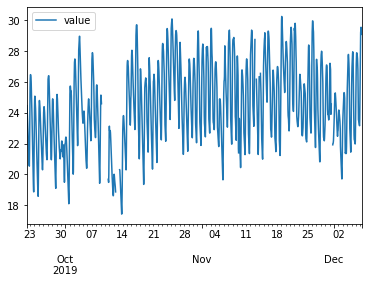

In [4]:
df_temp.plot()

# Differencing

In [5]:
df_diff = df_temp.diff().dropna()

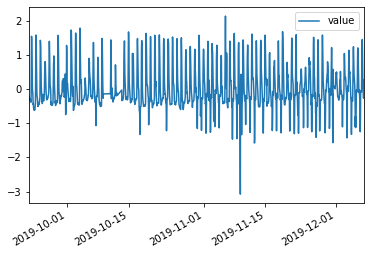

In [6]:
df_diff.plot()

# Stationarity Tests
## Augmented Dickey-Fuller Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

> Null Hypothesis (H0): Time Series is NOT stationary. 

**adf**: `float`

Test statistic

**pvalue**: `float`

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

**usedlag**: `int`

Number of lags used

**nobs**: `int`

Number of observations used for the ADF regression and calculation of the critical values

**critical values**: `dict`

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

**icbest**: `float`
The maximized information criterion if autolag is not None.

In [7]:
print("TEMPERATURE")
results = stattools.adfuller(df_temp['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

TEMPERATURE
p-value: 8.23641059925593e-05
Reject H0. Reject non-stationary. It could be stationary.


In [8]:
print("DIFFERENCED")
results = stattools.adfuller(df_diff['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

DIFFERENCED
p-value: 7.210846589028062e-15
Reject H0. Reject non-stationary. It could be stationary.


## KPSS Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html#statsmodels.tsa.stattools.kpss

> Null Hypothesis (H0): Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

**kpss_stat**: `float`

The KPSS test statistic

**p_value**: `float`

The p-value of the test. The p-value is interpolated from Table 1 in Kwiatkowski et al. (1992), and a boundary point is returned if the test statistic is outside the table of critical values, that is, if the p-value is outside the interval (0.01, 0.1).

**lags**: `int`

The truncation lag parameter

**crit**: `dict`

The critical values at 10%, 5%, 2.5% and 1%. Based on Kwiatkowski et al. (1992).


In [9]:
print("TEMPERATURE")
results = stattools.kpss(df_temp['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

TEMPERATURE
p-value: 0.01
Reject H0. Reject stationary. It could be non-stationary.


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [10]:
print("DIFFERENCED")
results = stattools.kpss(df_diff['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

DIFFERENCED
p-value: 0.1
Could not reject H0. It is likely stationary.


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Auto Correlation Plots

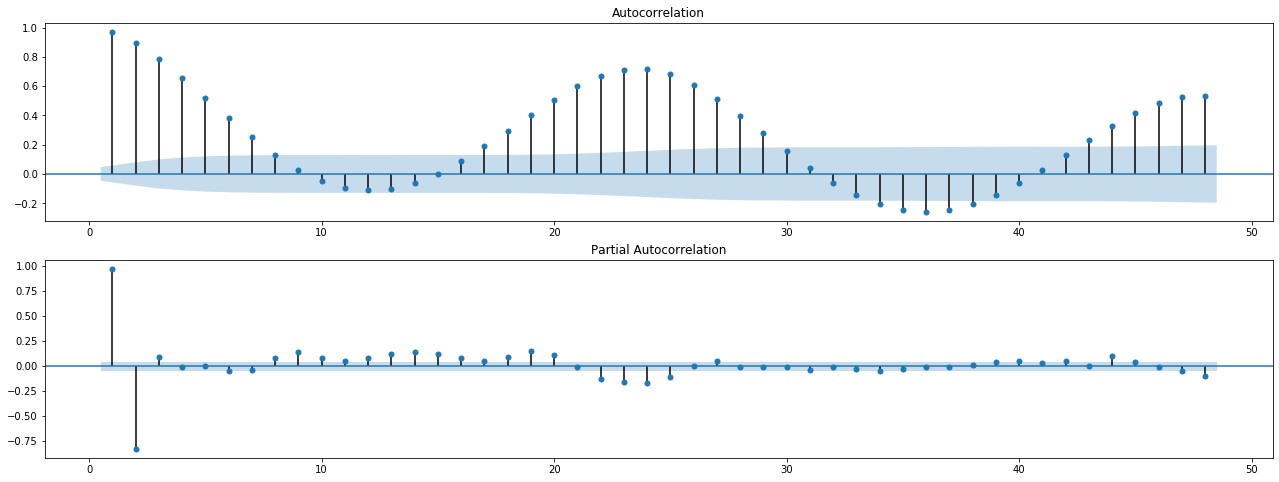

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,8))
plot_acf(df_temp.dropna(), lags=48, zero=False, ax=ax1)
plot_pacf(df_temp.dropna(), lags=48, zero=False, ax=ax2)
plt.show()

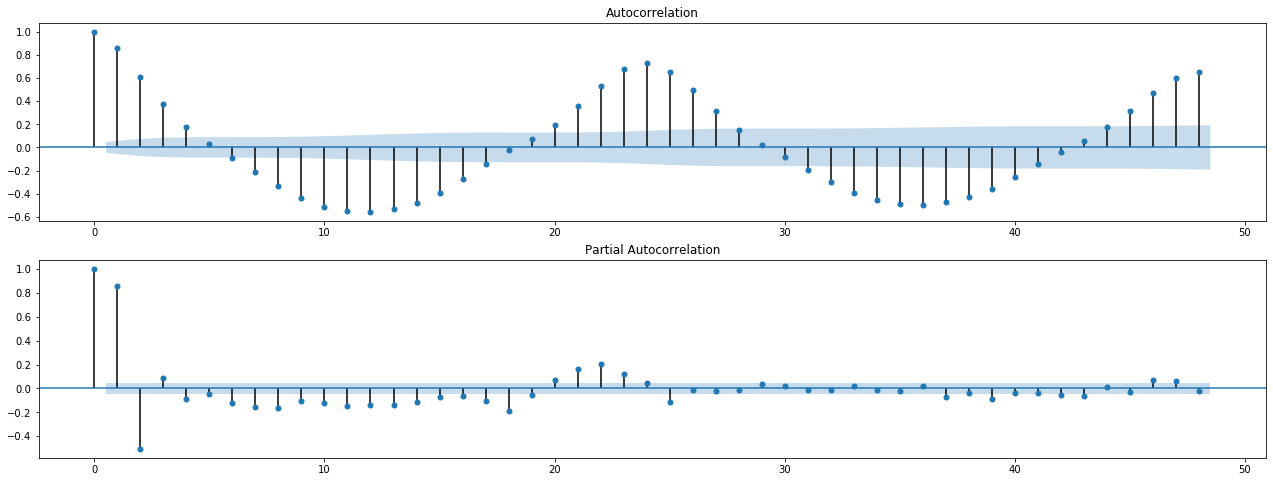

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,8))
plot_acf(df_diff.dropna(), lags=48, zero=True, ax=ax1)
plot_pacf(df_diff.dropna(), lags=48, zero=True, ax=ax2)
plt.show()

## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# ARIMA

In [13]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from multiprocessing import Pool

from itertools import product

# Setup list of experiments

seasonal_list = list(product(range(0,5),[0,1],range(0,5), [0,12]))
non_seasonal_list = list(product(range(1,5),[1],range(1,5)))
pdqPDQS = list(product(seasonal_list, non_seasonal_list))

print(len(seasonal_list))
print(len(non_seasonal_list))
print(len(pdqPDQS))
start = datetime.now()
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))

# Define a fitting task
def fit_sarimax(pdqPDQS):
    non_seasonal = pdqPDQS[1]
    seasonal = pdqPDQS[0]
    try:
        model = SARIMAX(df_temp['value'], order=non_seasonal, seasonal_order=seasonal)
        results = model.fit()
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'), non_seasonal, seasonal, results.aic, results.bic)
        return (non_seasonal, seasonal, results.aic, results.bic)
    except:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'), non_seasonal, seasonal, None, None)
        return (non_seasonal, seasonal, None, None)

# Multiprocess a season at a time    
order_aic_bic = []
with ThreadPoolExecutor() as pool:
    for result in pool.map(fit_sarimax, pdqPDQS):
        print(result)
        order_aic_bic.append(result)
    
print("EVALUATING")
order_aic_bic


100
16
1600
2019-12-07 18:27:03.848520


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2019-12-07 18:27:16.979449 (1, 1, 1) (0, 0, 0, 0) 434.7094531532325 451.23581466513536
((1, 1, 1), (0, 0, 0, 0), 434.7094531532325, 451.23581466513536)
2019-12-07 18:27:18.126992 (1, 1, 1) (0, 0, 0, 12) 434.7094531532325 451.23581466513536
2019-12-07 18:27:19.653028 (2, 1, 1) (0, 0, 0, 0) 373.48994542955967 395.5250941120968
2019-12-07 18:27:22.092787 (2, 1, 1) (0, 0, 0, 12) 373.48994542955967 395.5250941120968
2019-12-07 18:27:26.908834 (1, 1, 1) (0, 0, 1, 0) 400.48373009999057 422.5188787825277
2019-12-07 18:27:28.352852 (1, 1, 3) (0, 0, 0, 0) 383.2762906302108 410.82022648338216
2019-12-07 18:27:32.339270 (1, 1, 3) (0, 0, 0, 12) 383.2762906302108 410.82022648338216
2019-12-07 18:27:34.483469 (3, 1, 1) (0, 0, 0, 0) 374.0634849536174 401.60742080678875
2019-12-07 18:27:34.876467 (3, 1, 1) (0, 0, 0, 12) 374.0634849536174 401.60742080678875
2019-12-07 18:27:39.063560 (1, 1, 1) (0, 0, 1, 12) 426.05351483913614 448.08866352167325
2019-12-07 18:27:43.660828 (1, 1, 2) (0, 0, 0, 12) 384.0996

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:28:36.146585 (1, 1, 2) (0, 0, 2, 0) 378.64477909894117 411.6975021227468


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:28:37.367651 (2, 1, 3) (0, 0, 0, 0) 186.38103631370558 219.43375933751122
((2, 1, 3), (0, 0, 0, 0), 186.38103631370558, 219.43375933751122)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:28:46.466042 (3, 1, 1) (0, 0, 1, 0)2019-12-07 18:28:46.637044 (4, 1, 1) (0, 0, 0, 12) 151.39395967035497 184.44668269416064
 187.0492397627743 220.10196278657997
2019-12-07 18:28:48.592046 (4, 1, 1) (0, 0, 0, 0) 151.39395967035497 184.44668269416064
2019-12-07 18:28:56.796897 (3, 1, 2) (0, 0, 0, 12) 187.07371274391724 220.12643576772292019-12-07 18:28:57.395415 
(3, 1, 2) (0, 0, 0, 0) 187.07371274391724 220.1264357677229


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:29:01.999593 (4, 1, 3) (0, 0, 0, 12) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:29:07.880347 (4, 1, 3) (0, 0, 0, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:29:13.870858 (3, 1, 3) (0, 0, 0, 0) 181.62321105631202 220.18472125075195
2019-12-07 18:29:21.438275 (1, 1, 4) (0, 0, 1, 12) 431.88128768360207 470.44279787804203


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:29:22.856532 (3, 1, 2) (0, 0, 1, 0) 181.1538246235778 219.71533481801774
2019-12-07 18:29:25.273532 (2, 1, 4) (0, 0, 1, 0) 367.04672679635587 411.1170241614301
2019-12-07 18:29:27.268117 (3, 1, 3) (0, 0, 0, 12) 181.62321105631202 220.18472125075195
2019-12-07 18:29:27.496117 (1, 1, 4) (0, 0, 1, 0) 409.4109578799422 447.97246807438216
2019-12-07 18:29:35.795797 (2, 1, 4) (0, 0, 0, 12) 14.109572121965613 52.671082316405545
2019-12-07 18:29:38.249754 (2, 1, 1) (0, 0, 2, 0) 186.38103772862888 219.43376075243452


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:29:43.728891 (1, 1, 1) (0, 0, 2, 12) 223.5986723803564 251.14260823352777


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:29:52.781367 (2, 1, 4) (0, 0, 0, 0) 14.109572121965613 52.671082316405545
((2, 1, 4), (0, 0, 0, 0), 14.109572121965613, 52.671082316405545)
((3, 1, 1), (0, 0, 0, 0), 374.0634849536174, 401.60742080678875)
((3, 1, 2), (0, 0, 0, 0), 187.07371274391724, 220.1264357677229)
((3, 1, 3), (0, 0, 0, 0), 181.62321105631202, 220.18472125075195)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:29:57.747452 (2, 1, 3) (0, 0, 1, 0) 118.87045368360327 157.4319638780432
2019-12-07 18:29:57.983423 (3, 1, 4) (0, 0, 0, 0) 348.54052016726996

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 392.6108175323442
((3, 1, 4), (0, 0, 0, 0), 348.54052016726996, 392.6108175323442)
((4, 1, 1), (0, 0, 0, 0), 151.39395967035497, 184.44668269416064)
((4, 1, 2), (0, 0, 0, 0), 362.49362769442064, 401.0551378888606)
((4, 1, 3), (0, 0, 0, 0), None, None)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:30:04.442067 (1, 1, 2) (0, 0, 2, 12) 202.8698156491709 235.92253867297654
2019-12-07 18:30:07.885086 (4, 1, 2) (0, 0, 1, 0) 190.61408533902983 234.68438270410405
2019-12-07 18:30:11.171094 (4, 1, 1) (0, 0, 1, 12) 152.78891770354227 191.3504278979822


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:30:12.860315 (3, 1, 3) (0, 0, 1, 0) 187.15395577547096 231.22425314054516
2019-12-07 18:30:14.343318 (3, 1, 4) (0, 0, 0, 12) 348.54052016726996 392.6108175323442
2019-12-07 18:30:14.963316 (3, 1, 4) (0, 0, 1, 0) 365.88951645538447 415.46860099109296
2019-12-07 18:30:15.254315 (1, 1, 3) (0, 0, 2, 0) 365.1067314033161 403.66824159775604


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:30:16.893319 (4, 1, 3) (0, 0, 1, 0) 178.09275220762635 227.67183674333484
2019-12-07 18:30:21.625347 (2, 1, 1)2019-12-07 18:30:21.919347 (2, 1, 2) (0, 0, 2, 0) 182.53508069354424 221.09659088798418
 (0, 0, 2, 12) 200.67165284598124 233.7243758697869


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:30:27.305893 (1, 1, 3) (0, 0, 2, 12) 204.63602170519468 243.1975318996346
2019-12-07 18:30:29.116929 (3, 1, 1) (0, 0, 2, 0) 187.67874960894292 226.24025980338286
2019-12-07 18:30:37.052522 (4, 1, 4) (0, 0, 0, 12) 193.17208253221435 242.75116706792284
2019-12-07 18:30:45.927557 (1, 1, 1) (0, 0, 3, 0) 383.842347076323 416.89507010012863
2019-12-07 18:30:47.593807 (4, 1, 4) (0, 0, 0, 0) 193.17208253221435 242.75116706792284
((4, 1, 4), (0, 0, 0, 0), 193.17208253221435, 242.75116706792284)
((1, 1, 1), (0, 0, 0, 12), 434.7094531532325, 451.23581466513536)
((1, 1, 2), (0, 0, 0, 12), 384.0996014047028, 406.1347500872399)
((1, 1, 3), (0, 0, 0, 12), 383.2762906302108, 410.82022648338216)
((1, 1, 4), (0, 0, 0, 12), 472.8843078337197, 505.9370308575253)
((2, 1, 1), (0, 0, 0, 12), 373.48994542955967, 395.5250941120968)
((2, 1, 2), (0, 0, 0, 12), 185.80046933931746, 213.34440519248884)
((2, 1, 3), (0, 0, 0, 12), 186.38103631370558, 219.43375933751122)
((2, 1, 4), (0, 0, 0, 12), 14.109

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:31:45.056401 (2, 1, 3) (0, 0, 2, 0) 367.33367615341433 411.40397351848856
2019-12-07 18:31:51.337458 (3, 1, 1) (0, 0, 2, 12) 202.00588854525142 240.56739873969136
2019-12-07 18:31:57.865821 (2, 1, 3) (0, 0, 1, 12) 188.37174195452548 226.9332521489654
2019-12-07 18:31:59.367352 (1, 1, 2) (0, 0, 3, 0) 365.10676332812375 403.6682735225637


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:32:10.393997 (3, 1, 2) (0, 0, 2, 0) 307.3188164964528 351.38911386152705


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:32:22.626317 (4, 1, 2) (0, 0, 2, 0) 369.90583157443115 419.48491611013964
2019-12-07 18:32:37.850704 (4, 1, 1) (0, 0, 2, 0) 188.71084951255065 232.78114687762485


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:32:44.255389 (4, 1, 4) (0, 0, 1, 0) 201.7449346878834 256.83280639422617
((4, 1, 4), (0, 0, 1, 0), 201.7449346878834, 256.83280639422617)
((1, 1, 1), (0, 0, 1, 12), 426.05351483913614, 448.08866352167325)
((1, 1, 2), (0, 0, 1, 12), 374.4358686342517, 401.97980448742305)
((1, 1, 3), (0, 0, 1, 12), 373.03696773190376, 406.0896907557094)
((1, 1, 4), (0, 0, 1, 12), 431.88128768360207, 470.44279787804203)
((2, 1, 1), (0, 0, 1, 12), 363.78570540103306, 391.32964125420443)
((2, 1, 2), (0, 0, 1, 12), 187.67730082238887, 220.7300238461945)
((2, 1, 3), (0, 0, 1, 12), 188.37174195452548, 226.9332521489654)
2019-12-07 18:32:49.880531 (1, 1, 4) (0, 0, 2, 0) 269.2038111844961 313.2741085495703


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:33:06.074804 (3, 1, 3) (0, 0, 2, 0) 365.91950790463056 415.49859244033905
2019-12-07 18:33:19.499109 (2, 1, 4) (0, 0, 2, 0) 369.07846053572405 418.65754507143254
2019-12-07 18:33:28.799839 (3, 1, 3) (0, 0, 1, 12) 188.13860036706402 232.2088977321382
2019-12-07 18:33:50.247709 (2, 1, 2) (0, 0, 2, 12) 54.63291033667315 93.19442053111308
2019-12-07 18:33:51.525711 (2, 1, 2) (0, 0, 3, 0) 105.16007812659603 149.23037549167026


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:34:06.229513 (3, 1, 2) (0, 0, 2, 12) 204.67162063180237 248.74191799687657
2019-12-07 18:34:21.995796 (1, 1, 4) (0, 0, 2, 12) 216.30672404712547 260.37702141219967
2019-12-07 18:34:27.145164 (3, 1, 4) (0, 0, 2, 0) 366.1745059217599 421.2623776281026


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:34:37.354049 (1, 1, 1) (0, 0, 3, 12) 219.68224081007673 252.73496383388238


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:34:54.1454132019-12-07 18:34:54.367471 (2, 1, 1) (0, 0, 3, 0) 115.9706800464761 154.53219024091604
 (1, 1, 2) (0, 0, 3, 12) 197.85088925022092 236.41239944466085
2019-12-07 18:34:56.024439 (2, 1, 1) (0, 0, 3, 12) 195.30418289528484 233.86569308972477
2019-12-07 18:34:59.081438 (2, 1, 4) (0, 0, 1, 12) 58.4854638250099 102.55576119008411
((2, 1, 4), (0, 0, 1, 12), 58.4854638250099, 102.55576119008411)
((3, 1, 1), (0, 0, 1, 12), 364.76601864908685, 397.8187416728925)
((3, 1, 2), (0, 0, 1, 12), 367.6869898498992, 406.24850004433915)
((3, 1, 3), (0, 0, 1, 12), 188.13860036706402, 232.2088977321382)
2019-12-07 18:35:05.024163 (3, 1, 4) (0, 0, 1, 12) 118.4438219352952 168.0229064710037
((3, 1, 4), (0, 0, 1, 12), 118.4438219352952, 168.0229064710037)
((4, 1, 1), (0, 0, 1, 12), 152.78891770354227, 191.3504278979822)
((4, 1, 2), (0, 0, 1, 12), 357.53977167920834, 401.61006904428257)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:35:23.280021 (4, 1, 3) (0, 0, 2, 0) 185.66439138324242 240.7522630895852
2019-12-07 18:35:23.880058 (3, 1, 1) (0, 0, 3, 0) 190.16556669341406 234.2358640584883


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:36:05.774758 (1, 1, 3) (0, 0, 3, 0) 366.88369017809896 410.9539875431732
2019-12-07 18:36:10.338340 (1, 1, 3) (0, 0, 3, 12) 199.55195652240724 243.62225388748146
2019-12-07 18:36:14.903359 (4, 1, 3) (0, 0, 1, 12) 184.53290700978306 234.11199154549155
((4, 1, 3), (0, 0, 1, 12), 184.53290700978306, 234.11199154549155)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2019-12-07 18:36:50.421253 (4, 1, 4) (0, 0, 1, 12) 188.98501655240435 244.07288825874713
((4, 1, 4), (0, 0, 1, 12), 188.98501655240435, 244.07288825874713)
((1, 1, 1), (0, 0, 2, 0), 383.27628825854833, 410.8202241117197)
((1, 1, 2), (0, 0, 2, 0), 378.64477909894117, 411.6975021227468)
((1, 1, 3), (0, 0, 2, 0), 365.1067314033161, 403.66824159775604)
((1, 1, 4), (0, 0, 2, 0), 269.2038111844961, 313.2741085495703)
((2, 1, 1), (0, 0, 2, 0), 186.38103772862888, 219.43376075243452)
((2, 1, 2), (0, 0, 2, 0), 182.53508069354424, 221.09659088798418)
((2, 1, 3), (0, 0, 2, 0), 367.33367615341433, 411.40397351848856)
((2, 1, 4), (0, 0, 2, 0), 369.07846053572405, 418.65754507143254)
((3, 1, 1), (0, 0, 2, 0), 187.67874960894292, 226.24025980338286)
((3, 1, 2), (0, 0, 2, 0), 307.3188164964528, 351.38911386152705)
((3, 1, 3), (0, 0, 2, 0), 365.91950790463056, 415.49859244033905)
((3, 1, 4), (0, 0, 2, 0), 366.1745059217599, 421.2623776281026)
((4, 1, 1), (0, 0, 2, 0), 188.71084951255065, 232.781146877

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:36:59.416670 (4, 1, 4) (0, 0, 2, 0) 367.17231382141784 427.7689726983949
((4, 1, 4), (0, 0, 2, 0), 367.17231382141784, 427.7689726983949)
((1, 1, 1), (0, 0, 2, 12), 223.5986723803564, 251.14260823352777)
((1, 1, 2), (0, 0, 2, 12), 202.8698156491709, 235.92253867297654)
((1, 1, 3), (0, 0, 2, 12), 204.63602170519468, 243.1975318996346)
((1, 1, 4), (0, 0, 2, 12), 216.30672404712547, 260.37702141219967)
((2, 1, 1), (0, 0, 2, 12), 200.67165284598124, 233.7243758697869)
((2, 1, 2), (0, 0, 2, 12), 54.63291033667315, 93.19442053111308)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:37:29.257768 (4, 1, 1) (0, 0, 3, 0) 190.95931239453301 240.5383969302415
2019-12-07 18:37:44.278579 (3, 1, 2) (0, 0, 3, 0) 365.8914962130233 415.4705807487318
2019-12-07 18:38:03.686248 (2, 1, 3) (0, 0, 3, 0) 108.25173611654702 157.8308206522555
2019-12-07 18:38:04.053250 (1, 1, 1) (0, 1, 0, 0) None None
2019-12-07 18:38:04.058250 (1, 1, 2) (0, 1, 0, 0) None None
2019-12-07 18:38:06.371251 (1, 1, 3) (0, 1, 0, 0) None None
2019-12-07 18:38:08.792971 (1, 1, 4) (0, 1, 0, 0) None None
2019-12-07 18:38:10.309013 (2, 1, 1) (0, 1, 0, 0) None None
2019-12-07 18:38:10.970385 (2, 1, 2) (0, 1, 0, 0) None None
2019-12-07 18:38:12.956963 (2, 1, 3) (0, 1, 0, 0) None None
2019-12-07 18:38:14.781999 (2, 1, 4) 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0, 0) None None
2019-12-07 18:38:16.029964 (3, 1, 1) (0, 1, 0, 0) None None
2019-12-07 18:38:16.458963 (3, 1, 2) (0, 1, 0, 0) None None
2019-12-07 18:38:17.432015 (3, 1, 3) (0, 1, 0, 0) None None
2019-12-07 18:38:19.295013 (3, 1, 4) (0, 1, 0, 0) None None
2019-12-07 18:38:21.255032 (4, 1, 1) (0, 1, 0, 0) None None
2019-12-07 18:38:27.416322 (4, 1, 2) (0, 1, 0, 0) None None
2019-12-07 18:38:31.719285 (4, 1, 3) (0, 1, 0, 0) None None
2019-12-07 18:38:32.929286 (4, 1, 4) (0, 1, 0, 0) None None
2019-12-07 18:38:42.596351 (3, 1, 1) (0, 0, 3, 12) 196.61345122926997 240.6837485943442
2019-12-07 18:39:13.370217 (3, 1, 3) (0, 0, 3, 0) 372.11219529185826 427.200066998201
2019-12-07 18:40:08.650621 (4, 1, 1) (0, 0, 2, 12) 33.33399141976048 77.40428878483469
2019-12-07 18:40:27.884729 (2, 1, 3) (0, 0, 4, 0) 370.6423197532744 425.7301914596172


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:40:59.561450 (1, 1, 2) (0, 0, 4, 0) 366.88454912704617 410.9548464921204
2019-12-07 18:41:02.101148 (1, 1, 1) (0, 1, 0, 12) 1784.2334188051514 1800.7399782649602
2019-12-07 18:41:04.690898 (1, 1, 1) (0, 0, 4, 12)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 139.65941202237286 178.2209222168128
2019-12-07 18:41:41.666493 (2, 1, 4) (0, 0, 3, 0) 370.6294977695645 425.7173694759073
2019-12-07 18:41:46.766063 (1, 1, 1) (0, 0, 4, 0) 365.1067326880108 403.6682428824507


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:42:15.083528 (4, 1, 2) (0, 0, 3, 0) 131.42499817056856 186.51286987691134
2019-12-07 18:42:16.361037 (4, 1, 2) (0, 0, 2, 12) 192.84675893929244 242.42584347500093
2019-12-07 18:42:32.372031 (1, 1, 2) (0, 1, 0, 12) 1725.8324457540361 1747.8411917004478


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:42:41.706429 (1, 1, 4) (0, 0, 3, 0) 265.6736713765017 315.2527559122102
2019-12-07 18:42:45.889595 (3, 1, 4) (0, 0, 3, 0) 369.33379569690186 429.93045457387893


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:43:34.042689 (4, 1, 4) (0, 0, 3, 0) 372.50764706942624 438.6130931170376


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:43:43.618541 (2, 1, 3) (0, 0, 2, 12) 61.05434351048689 105.1246408755611
((2, 1, 3), (0, 0, 2, 12), 61.05434351048689, 105.1246408755611)
2019-12-07 18:43:45.199745 (1, 1, 1) (0, 1, 1, 0) None None
2019-12-07 18:43:45.615781 (1, 1, 2) (0, 1, 1, 0) None None
2019-12-07 18:43:46.8797472019-12-07 18:43:46.890749 (1, 1, 3) (0, 1, 1, 0)  None(2, 1, 2) (0, 0, 3, 12)  None
2019-12-07 18:43:48.34378155.85363575715854 99.92393312223275 (1, 1, 4) 
2019-12-07 18:43:49.979807 (2, 1, 1) (0, 1, 1, 0)(0, 1, 1, 0) None  None
2019-12-07 18:43:50.598829 (2, 1, 2)None None
2019-12-07 18:43:50.734805 (2, 1, 3) (0, 1, 1, 0) None  None
(0, 1, 1, 0) None 2019-12-07 18:43:53.974157 (2, 1, 4) None(0, 1, 1, 0)
 None 2019-12-07 18:43:54.916158 (3, 1, 1) (0, 1, 1, 0) None None
None
2019-12-07 18:43:55.242156 (3, 1, 3)2019-12-07 18:43:55.787158 (3, 1, 2) (0, 1, 1, 0) None None
 2019-12-07 18:43:56.791739 (3, 1, 4) (0, 1, 1, 0) None (0, 1, 1, 0) NoneNone None

2019-12-07 18:43:59.434509 (4, 1, 1) (0, 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:44:34.1498302019-12-07 18:44:34.166830 (2, 1, 1) (0, 0, 4, 0) 53.001221521840705  (1, 1, 3) (0, 1, 0, 12) 1724.9934024658319 1752.5043348988465
97.07151888691492
2019-12-07 18:44:36.953055 (3, 1, 3) (0, 0, 2, 12) 57.48256793464918 107.06165247035767
2019-12-07 18:45:08.967648 (2, 1, 1) (0, 1, 0, 12) 1701.1840628218008 1723.1928087682124
2019-12-07 18:45:19.011954 (1, 1, 3) (0, 0, 4, 0) 368.542175411077 418.1212599467855
2019-12-07 18:45:20.830990 (2, 1, 4) (0, 0, 2, 12) -82.43473046227967 -32.855645926571185
((2, 1, 4), (0, 0, 2, 12), -82.43473046227967, -32.855645926571185)
((3, 1, 1), (0, 0, 2, 12), 202.00588854525142, 240.56739873969136)
((3, 1, 2), (0, 0, 2, 12), 204.67162063180237, 248.74191799687657)
((3, 1, 3), (0, 0, 2, 12), 57.48256793464918, 107.06165247035767)
2019-12-07 18:45:27.433095 (1, 1, 4) (0, 1, 0, 12) 2019-12-07 18:45:29.530378 (1, 1, 2) (0, 0, 4, 12) 124.78846779770333 1660.8044432883103168.85876516277756
 1693.8175622079277
2019-12-07 18:45:43.012513

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:46:05.413960 (1, 1, 4) (0, 0, 3, 12) 203.01742540623923 252.59650994194772


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:47:07.978297 (4, 1, 3) (0, 0, 2, 12) 48.60713089344068 103.69500259978345
2019-12-07 18:47:26.130351 (2, 1, 2) (0, 0, 4, 0) 106.33679882712815 155.91588336283664
2019-12-07 18:47:27.423327 (3, 1, 1) (0, 0, 4, 0) 116.06478161601251

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 165.643866151721
2019-12-07 18:47:27.834358 (1, 1, 1) (0, 1, 2, 0) None None
2019-12-07 18:47:30.354125 (1, 1, 2) (0, 1, 2, 0) None None
2019-12-07 18:47:30.559126 (1, 1, 3) (0, 1, 2, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:47:31.1891262019-12-07 18:47:31.631124 (1, 1, 4) (0, 1, 2, 0)  None(3, 1, 2) (0, 0, 4, 0) 367.5474514987984 422.63532320514116
 None
2019-12-07 18:47:32.889137 (2, 1, 2) (0, 1, 2, 0) None None2019-12-07 18:47:32.960173 (2, 1, 1) (0, 1, 2, 0)
 2019-12-07 18:47:33.608135None (2, 1, 3) (0, 1, 2, 0) None  2019-12-07 18:47:33.809135None
2019-12-07 18:47:33.847135 (2, 1, 4) (0, 1, 2, 0) None None
2019-12-07 18:47:33.859136 (3, 1, 1) (0, 1, 2, 0) (2, 1, 4)None
 (0, 0, 4, 0) 367.7137387535446 428.3103976305216
 None2019-12-07 18:47:34.740136  (3, 1, 2) (0, 1, 2, 0) None None
None
2019-12-07 18:47:35.871136 (3, 1, 3) (0, 1, 2, 0) None None
2019-12-07 18:47:36.065135 (4, 1, 1) (0, 1, 2, 0) None None2019-12-07 18:47:36.440138 
2019-12-07 18:47:37.410171 (4, 1, 2) (0, 1, 2, 0) None None
(3, 1, 4) (0, 1, 2, 0) 2019-12-07 18:47:37.767135 (4, 1, 3) (0, 1, 2, 0) None2019-12-07 18:47:38.183135None None (4, 1, 4) (0, 1, 2, 0) None None None


2019-12-07 18:48:28.731532 (3, 1, 3) (0, 0, 4, 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:48:41.779102 (3, 1, 4) (0, 0, 2, 12) 192.4494143289259 247.53728603526866


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((3, 1, 4), (0, 0, 2, 12), 192.4494143289259, 247.53728603526866)
((4, 1, 1), (0, 0, 2, 12), 33.33399141976048, 77.40428878483469)
((4, 1, 2), (0, 0, 2, 12), 192.84675893929244, 242.42584347500093)
((4, 1, 3), (0, 0, 2, 12), 48.60713089344068, 103.69500259978345)
2019-12-07 18:49:03.691102 (3, 1, 1) (0, 1, 0, 12) 1695.579698061687 1723.0906304947016


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:49:38.271024 (1, 1, 4) 2019-12-07 18:49:39.091030 (3, 1, 4) (0, 0, 4, 0) 370.24959477454394 436.3550408221553
(0, 0, 4, 0) 271.0023796053851 326.09025131172785


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:50:03.032185 (1, 1, 1) (0, 1, 1, 12) 248.39294543150237 270.40169137791406
2019-12-07 18:50:06.812185 (4, 1, 2) (0, 0, 4, 0) 369.40134127819795 429.99800015517496
2019-12-07 18:50:11.731548 (4, 1, 1) (0, 0, 4, 0) 124.67167748254215 179.75954918888493


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:50:36.474555 (2, 1, 2) (0, 1, 0, 12) 1284.6936418697283 1312.204574302743
2019-12-07 18:50:50.792745 (4, 1, 3) (0, 0, 4, 0) 371.61688745749393 437.7223335051052
2019-12-07 18:51:02.029553 (4, 1, 1) (0, 0, 3, 12) 35.08831432643569 84.66739886214418
2019-12-07 18:51:41.071401 (4, 1, 4) (0, 0, 2, 12) 44.121611959599534 104.71827083657658
((4, 1, 4), (0, 0, 2, 12), 44.121611959599534, 104.71827083657658)
((1, 1, 1), (0, 0, 3, 0), 383.842347076323, 416.89507010012863)
((1, 1, 2), (0, 0, 3, 0), 365.10676332812375, 403.6682735225637)
((1, 1, 3), (0, 0, 3, 0), 366.88369017809896, 410.9539875431732)
((1, 1, 4), (0, 0, 3, 0), 265.6736713765017, 315.2527559122102)
((2, 1, 1), (0, 0, 3, 0), 115.9706800464761, 154.53219024091604)
((2, 1, 2), (0, 0, 3, 0), 105.16007812659603, 149.23037549167026)
((2, 1, 3), (0, 0, 3, 0), 108.25173611654702, 157.8308206522555)
((2, 1, 4), (0, 0, 3, 0), 370.6294977695645, 425.7173694759073)
((3, 1, 1), (0, 0, 3, 0), 190.16556669341406, 234.2358640584883)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:55:02.279061 (4, 1, 2) (0, 0, 3, 12) 188.20904564595745 243.29691735230023
2019-12-07 18:55:11.457337 (3, 1, 1) (0, 1, 1, 12) 222.92914932147687 255.9422682410944


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:55:32.416952 (2, 1, 3) (0, 1, 0, 12) 1263.9117896947869 1296.9249086144043
2019-12-07 18:55:42.138383 (1, 1, 3) (0, 1, 1, 12) 231.3165107907557 264.32962971037324
2019-12-07 18:55:43.590713 (4, 1, 4) (0, 0, 4, 0) 372.4526903893769 444.0669236076225
2019-12-07 18:55:49.497401 (2, 1, 2) (0, 1, 1, 12) 3.303551505080634 36.31667042469818
2019-12-07 18:56:15.170876 (3, 1, 3) (0, 1, 0, 12) 1201.945106675667 1240.4604120818874


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:56:52.814122 (3, 1, 3) (0, 0, 3, 12) 59.409704255985616 114.49757596232838
2019-12-07 18:57:07.623653 (1, 1, 1) (0, 1, 2, 12) 120.64968753976615 148.16061997278078


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:57:24.304582 (2, 1, 3) (0, 0, 3, 12) 58.75122291994609 108.33030745565458
((2, 1, 3), (0, 0, 3, 12), 58.75122291994609, 108.33030745565458)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:58:20.180964 (4, 1, 1) (0, 1, 0, 12) 1210.7651379602025 1243.77825687982


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 18:59:21.833730 (3, 1, 4) (0, 0, 3, 12) 177.34257542921293 237.93923430618997
2019-12-07 18:59:35.476973 (1, 1, 4) (0, 1, 1, 12) 219.06822424301293 257.5835296492334
2019-12-07 18:59:43.452935 (2, 1, 4) (0, 0, 3, 12) 9.885826225191124 64.97369793153389
2019-12-07 18:59:47.707934 ((2, 1, 4), (0, 0, 3, 12), 9.885826225191124, 64.97369793153389)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 1, 4) (0, 1, 0, 12) 1557.268454827678 1595.7837602338984
2019-12-07 18:59:49.362934 (1, 1, 1) (0, 1, 4, 0)
((3, 1, 1), (0, 0, 3, 12), 196.61345122926997, 240.6837485943442)
 None None
2019-12-07 18:59:52.700576 (1, 1, 2) (0, 1, 4, 0) None None
2019-12-07 18:59:53.459428 (1, 1, 3) (0, 1, 4, 0) None None
2019-12-07 18:59:54.278902 (1, 1, 4) (0, 1, 4, 0) None None
2019-12-07 18:59:58.132953 (2, 1, 1) (0, 1, 4, 0) None None
2019-12-07 19:00:01.087903 (2, 1, 2) (0, 1, 4, 0) None None
2019-12-07 19:00:02.566901 (2, 1, 3) (0, 1, 4, 0) None None
2019-12-07 19:00:03.500934 (2, 1, 4) (0, 1, 4, 0) None None
2019-12-07 19:00:03.500934 (3, 1, 1) (0, 1, 4, 0) None None
2019-12-07 19:00:06.748101 (3, 1, 2) (0, 1, 4, 0) None None
2019-12-07 19:00:09.124132 (3, 1, 3) (0, 1, 4, 0) None None
2019-12-07 19:00:11.615048 (3, 1, 4) (0, 1, 4, 0) None None
2019-12-07 19:00:13.021057 (4, 1, 1) (0, 1, 4, 0) None None
2019-12-07 19:00:20.124056 (4, 1, 2) (0, 1, 4, 0) None None
2019-12-07 19:00:23.509158 (3, 1

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:01:14.638550 (2, 1, 2) (0, 0, 4, 12) 10.066740548084738 59.64582508379323
2019-12-07 19:01:49.674395 (1, 1, 2) (0, 1, 2, 12) 115.7235505627898 148.73666948240734
2019-12-07 19:01:55.082658 (3, 1, 2) (0, 0, 3, 12) 90.22400268645958 139.80308722216807
((3, 1, 2), (0, 0, 3, 12), 90.22400268645958, 139.80308722216807)
((3, 1, 3), (0, 0, 3, 12), 59.409704255985616, 114.49757596232838)
((3, 1, 4), (0, 0, 3, 12), 177.34257542921293, 237.93923430618997)
((4, 1, 1), (0, 0, 3, 12), 35.08831432643569, 84.66739886214418)
((4, 1, 2), (0, 0, 3, 12), 188.20904564595745, 243.29691735230023)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:02:54.177870 (4, 1, 2) (0, 1, 0, 12) 1230.2521404483723 1268.7674458545928
2019-12-07 19:03:02.390932

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (1, 1, 4) (0, 0, 4, 12) 113.5826029512487 168.67047465759146
2019-12-07 19:04:51.754951 (3, 1, 2) (0, 1, 0, 12) 1271.9848357796793 1304.9979546992968


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:06:45.320751 (4, 1, 4) (0, 0, 3, 12) 45.89089706825024 111.99634311586155
2019-12-07 19:06:53.788908 (4, 1, 3) (0, 1, 0, 12) 1128.250456149844 1172.2679480426675
2019-12-07 19:07:00.073230 (1, 1, 1) (0, 1, 3, 12) 57.08254101505992 90.09565993467746
2019-12-07 19:07:19.172256 (2, 1, 1) (0, 1, 2, 12) 114.29636588357181 147.30948480318935


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:08:56.977969 (4, 1, 3) (0, 0, 3, 12) 49.29971005188219 109.89636892885923
((4, 1, 3), (0, 0, 3, 12), 49.29971005188219, 109.89636892885923)
((4, 1, 4), (0, 0, 3, 12), 45.89089706825024, 111.99634311586155)
((1, 1, 1), (0, 0, 4, 0), 365.1067326880108, 403.6682428824507)
((1, 1, 2), (0, 0, 4, 0), 366.88454912704617, 410.9548464921204)
((1, 1, 3), (0, 0, 4, 0), 368.542175411077, 418.1212599467855)
((1, 1, 4), (0, 0, 4, 0), 271.0023796053851, 326.09025131172785)
((2, 1, 1), (0, 0, 4, 0), 53.001221521840705, 97.07151888691492)
((2, 1, 2), (0, 0, 4, 0), 106.33679882712815, 155.91588336283664)
((2, 1, 3), (0, 0, 4, 0), 370.6423197532744, 425.7301914596172)
((2, 1, 4), (0, 0, 4, 0), 367.7137387535446, 428.3103976305216)
((3, 1, 1), (0, 0, 4, 0), 116.06478161601251, 165.643866151721)
((3, 1, 2), (0, 0, 4, 0), 367.5474514987984, 422.63532320514116)
((3, 1, 3), (0, 0, 4, 0), 370.0625673121667, 430.65922618914374)
((3, 1, 4), (0, 0, 4, 0), 370.24959477454394, 436.3550408221553)
((4, 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:14:06.139954 (1, 1, 4) (0, 1, 2, 12) 114.47878340527939 158.49627529810277
2019-12-07 19:14:08.369132 (2, 1, 3) (0, 1, 1, 12) 67.35441379138376 105.86971919760424
2019-12-07 19:15:54.231493 (4, 1, 2) (0, 0, 4, 12) 116.36475338696977 176.9614122639468
2019-12-07 19:16:55.709581 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 1) (0, 1, 1, 12) -42.42131115012177 -3.9060057439012965
2019-12-07 19:17:43.163819 (3, 1, 3) (0, 1, 1, 12) 21.136158070651845 65.15364996347523


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:20:05.353502 (3, 1, 1) (0, 1, 2, 12) 113.98369413182115 152.49899953804163
2019-12-07 19:20:36.699397 (2, 1, 3) (0, 0, 4, 12) 15.880183564424499 70.96805527076727
((2, 1, 3), (0, 0, 4, 12), 15.880183564424499, 70.96805527076727)
2019-12-07 19:21:08.585580 (2, 1, 4) (0, 1, 1, 12) 215.59991927640704 259.6174111692304


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:23:39.636870 (4, 1, 1) (0, 0, 4, 12) -3.0406067063233877 52.04726500001938


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:26:17.837460 2019-12-07 19:26:22.323408(2, 1, 2) (0, 1, 2, 12) (2, 1, 1) (0, 1, 3, 12) 54.97636855703763 93.49167396325811
 -39.14137349429063 -0.6260680880701628
2019-12-07 19:26:45.0535052019-12-07 19:26:46.595501 (3, 1, 4) (0, 1, 1, 12) 206.02257437854365 255.54225275796998
 (1, 1, 1) (0, 1, 4, 12) -9.717530741987332 28.79777466423314


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:28:27.656817 (3, 1, 2) (0, 0, 4, 12) 19.004957945226977 74.09282965156974
2019-12-07 19:28:45.511968 (1, 1, 3) (0, 1, 3, 12) 57.20404664700942 101.2215385398328


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:29:45.652214 (1, 1, 2) (1, 0, 0, 0) 378.3805927981676 405.92452865133896
2019-12-07 19:30:40.052786 (1, 1, 1) (1, 0, 0, 0) 377.1797031910994 399.2148518736365


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:30:52.450067 (1, 1, 2) (0, 1, 3, 12) 55.22170255066766 93.73700795688814


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:32:15.953968 (3, 1, 3) (0, 0, 4, 12) 14.056717608956149 74.6533764859332
2019-12-07 19:33:28.665962 (2, 1, 4) (0, 0, 4, 12) -4.667853215096102 55.92880566188094
((2, 1, 4), (0, 0, 4, 12), -4.667853215096102, 55.92880566188094)
((3, 1, 1), (0, 0, 4, 12), 124.14498522743196, 173.72406976314045)
((3, 1, 2), (0, 0, 4, 12), 19.004957945226977, 74.09282965156974)
((3, 1, 3), (0, 0, 4, 12), 14.056717608956149, 74.6533764859332)
2019-12-07 19:34:14.702780 (4, 1, 2) (0, 1, 1, 12) -253.6535471271069 -209.6360552342835
2019-12-07 19:35:11.228301 (3, 1, 2) (0, 1, 2, 12) -44.13987935392146 -0.12238746109806442
2019-12-07 19:35:49.567584 (4, 1, 4) (0, 0, 4, 12) -1.677615535092059 69.93661768315353


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:39:57.307984 (2, 1, 3) (1, 0, 0, 0) 382.38039498594503 420.941905180385


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:40:37.262671 (2, 1, 1) (1, 0, 0, 0) 374.06348958543896 401.60742543861033
2019-12-07 19:40:51.569295 (1, 1, 3) (1, 0, 0, 0) 252.92872926207133 285.98145228587697
2019-12-07 19:40:58.767993 (4, 1, 3) (0, 1, 1, 12) 8.549887301080275 58.0695656805066
2019-12-07 19:41:01.606027 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 1, 4) (0, 1, 3, 12) 55.14052657656305 104.66020495598937
2019-12-07 19:41:46.182288 (1, 1, 1) (1, 0, 0, 12) 416.48223692109383 438.51738560363094
2019-12-07 19:42:04.792366 (4, 1, 1) (0, 1, 2, 12) -82.18796621727094 -38.17047432444755
2019-12-07 19:43:07.095373 (3, 1, 1) (0, 1, 3, 12) 56.52375381612785 100.54124570895124
2019-12-07 19:43:42.097393 (1, 1, 2) (1, 0, 0, 12) 364.5812675267322 392.12520337990355
2019-12-07 19:44:08.836987 (2, 1, 3) (0, 1, 2, 12) -17.317595918545408 26.699895974277986
2019-12-07 19:44:30.403984 (1, 1, 3) (0, 1, 4, 12) -7.761231450383434 41.75844692904289
2019-12-07 19:45:07.125277 (3, 1, 4) (0, 0, 4, 12) 4.156167682793011 70.26161373040432
((3, 1, 4), (0, 0, 4, 12), 4.156167682793011, 70.26161373040432)
((4, 1, 1), (0, 0, 4, 12), -3.0406067063233877, 52.04726500001938)
2019-12-07 19:45:10.285869((4, 1, 2), (0, 0, 4, 12), 116.36475338696977, 176.9614122639468)
 (4, 1, 3) (0, 0, 4, 12) 9.161299317199507 75.26674536481082
((4, 1, 3), (0, 0, 4, 12), 9.161299

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:46:40.228161 (2, 1, 1) (0, 1, 4, 12) -9.82585634827376 34.191635544549634


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:47:49.821198 (1, 1, 3) (1, 0, 0, 12) 362.59893775151636 395.651660775322
2019-12-07 19:47:53.061198 (2, 1, 2) (0, 1, 3, 12) -74.41546394809524 -30.397972055271843
2019-12-07 19:48:35.928475 (2, 1, 1) (1, 0, 0, 12) 353.69402694365624 381.2379627968276
2019-12-07 19:49:46.208937 (4, 1, 4) (0, 1, 1, 12) 20.68566268952776 75.70752755555701
((4, 1, 4), (0, 1, 1, 12), 20.68566268952776, 75.70752755555701)
((1, 1, 1), (0, 1, 2, 0), None, None)
((1, 1, 2), (0, 1, 2, 0), None, None)
((1, 1, 3), (0, 1, 2, 0), None, None)
((1, 1, 4), (0, 1, 2, 0), None, None)
((2, 1, 1), (0, 1, 2, 0), None, None)
((2, 1, 2), (0, 1, 2, 0), None, None)
((2, 1, 3), (0, 1, 2, 0), None, None)
((2, 1, 4), (0, 1, 2, 0), None, None)
((3, 1, 1), (0, 1, 2, 0), None, None)
((3, 1, 2), (0, 1, 2, 0), None, None)
((3, 1, 3), (0, 1, 2, 0), None, None)
((3, 1, 4), (0, 1, 2, 0), None, None)
((4, 1, 1), (0, 1, 2, 0), None, None)
((4, 1, 2), (0, 1, 2, 0), None, None)
((4, 1, 3), (0, 1, 2, 0), None, None)
((4, 1, 4), (

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:51:35.606785 (1, 1, 4) (1, 0, 0, 0) 257.56925852006145 296.13076871450136
2019-12-07 19:52:02.354554 (2, 1, 2) (1, 0, 0, 0) 192.97422711406554 226.0269501378712


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:54:33.962762 (3, 1, 1) (1, 0, 0, 0) 375.61151455503784 408.6642375788435


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:56:05.397573 (3, 1, 1) (0, 1, 4, 12) -7.994551068801343 41.52512731062498


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:57:03.281960 (4, 1, 1) (1, 0, 0, 0) 323.56992081738963 362.1314310118296
2019-12-07 19:57:09.856959 (4, 1, 2) (0, 1, 2, 12) -231.852169330116 -182.33249095068967
2019-12-07 19:57:12.421962 (3, 1, 2) (1, 0, 0, 0) 377.4050139819525 415.96652417639245


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:57:49.100427 (1, 1, 1) (1, 0, 1, 0) 378.40420389971484 405.9481397528862
2019-12-07 19:58:07.945177 (2, 1, 4) (1, 0, 0, 0) 379.4491950166913 423.51949238176553


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:58:42.034619 (3, 1, 1) (1, 0, 0, 12) 354.9101679520828 387.96289097588846


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 19:59:18.893820 (4, 1, 3) (0, 1, 2, 12) -43.343766091955786 11.678098774073462


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:00:41.3997102019-12-07 20:00:44.614713 (3, 1, 3) (1, 0, 0, 0) 189.91601860384074 233.98631596891494
 (3, 1, 2) (0, 1, 3, 12) -78.57151236168869 -29.051833982262366


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:01:52.938340 (2, 1, 4) (0, 1, 2, 12) -143.94760384778584 -94.42792546835952
((2, 1, 4), (0, 1, 2, 12), -143.94760384778584, -94.42792546835952)
((3, 1, 1), (0, 1, 2, 12), 113.98369413182115, 152.49899953804163)
((3, 1, 2), (0, 1, 2, 12), -44.13987935392146, -0.12238746109806442)
((3, 1, 3), (0, 1, 2, 12), -42.67915835338226, 6.840520026044061)
2019-12-07 20:02:20.097090 (4, 1, 1) (0, 1, 3, 12) -113.64786107591658 -64.12818269649026


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:03:03.655230 (3, 1, 4) (1, 0, 0, 0) 188.46484340676378 238.04392794247227
2019-12-07 20:03:33.817735 (2, 1, 2) (1, 0, 0, 12) 187.581682214322 220.63440523812767


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:04:04.562330 (1, 1, 4) (0, 1, 4, 12) -9.539178647778783 45.482686218250464
2019-12-07 20:04:13.211329 (4, 1, 2) (1, 0, 0, 0) 364.7523423808664 408.82263974594065


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:04:58.180218 (3, 1, 4) (0, 1, 2, 12) -184.99374173163343 -129.9718768656042
((3, 1, 4), (0, 1, 2, 12), -184.99374173163343, -129.9718768656042)
((4, 1, 1), (0, 1, 2, 12), -82.18796621727094, -38.17047432444755)
((4, 1, 2), (0, 1, 2, 12), -231.852169330116, -182.33249095068967)
((4, 1, 3), (0, 1, 2, 12), -43.343766091955786, 11.678098774073462)
2019-12-07 20:05:24.450804 (4, 1, 3) (1, 0, 0, 0) 195.3821026954934 244.96118723120188
2019-12-07 20:05:26.881805 (2, 1, 4) (0, 1, 3, 12) -204.65916665621785 -149.6373017901886


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:06:10.039092 (1, 1, 4) (1, 0, 0, 12) 393.50613328194186 432.0676434763818


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:07:11.190468 (4, 1, 2) (0, 1, 3, 12) -86.22431029463115 -31.202445428601905


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:08:04.164704 (1, 1, 2) (0, 1, 4, 12) -9.76083169175439 34.256660201069


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:09:06.535785 (2, 1, 2) (0, 1, 4, 12) -111.43205060486062 -61.9123722254343


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:09:11.126062 (1, 1, 2) (1, 0, 1, 0) 380.3830021988701 413.4357252226757
2019-12-07 20:09:17.958030 (3, 1, 3) (0, 1, 3, 12) -77.26001853355444 -22.238153667525197
2019-12-07 20:10:17.182061 (3, 1, 4) (0, 1, 3, 12) 44.409483232231196 104.93353458486337
2019-12-07 20:10:38.837516 (4, 1, 4) (1, 0, 0, 0) 178.75243241408378 233.84030412042654
2019-12-07 20:10:42.022327 (2, 1, 3) (0, 1, 3, 12) -31.69404219374951 17.825636185676814


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:11:27.931704 (2, 1, 3) (1, 0, 0, 12) 188.3380367835902 2019-12-07 20:11:28.477696 (1, 1, 3) 226.89954697803014
(1, 0, 1, 0) 382.19558005479325 420.7570902492332
2019-12-07 20:11:54.982796 (2, 1, 1) (1, 0, 1, 0) 187.05173668635078 220.10445971015645


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:13:19.476962 (4, 1, 4) (0, 1, 2, 12) -50.32335237696225 10.200698975669923
((4, 1, 4), (0, 1, 2, 12), -50.32335237696225, 10.200698975669923)
((1, 1, 1), (0, 1, 3, 0), None, None)
((1, 1, 2), (0, 1, 3, 0), None, None)
((1, 1, 3), (0, 1, 3, 0), None, None)
((1, 1, 4), (0, 1, 3, 0), None, None)
((2, 1, 1), (0, 1, 3, 0), None, None)
((2, 1, 2), (0, 1, 3, 0), None, None)
((2, 1, 3), (0, 1, 3, 0), None, None)
((2, 1, 4), (0, 1, 3, 0), None, None)
((3, 1, 1), (0, 1, 3, 0), None, None)
((3, 1, 2), (0, 1, 3, 0), None, None)
((3, 1, 3), (0, 1, 3, 0), None, None)
((3, 1, 4), (0, 1, 3, 0), None, None)
((4, 1, 1), (0, 1, 3, 0), None, None)
((4, 1, 2), (0, 1, 3, 0), None, None)
((4, 1, 3), (0, 1, 3, 0), None, None)
((4, 1, 4), (0, 1, 3, 0), None, None)
((1, 1, 1), (0, 1, 3, 12), 57.08254101505992, 90.09565993467746)
((1, 1, 2), (0, 1, 3, 12), 55.22170255066766, 93.73700795688814)
((1, 1, 3), (0, 1, 3, 12), 57.20404664700942, 101.2215385398328)
((1, 1, 4), (0, 1, 3, 12), 55.14052657656

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:14:55.912364 (2, 1, 3) (1, 0, 1, 0) 384.2468126626361 428.3171100277103


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:15:39.911113 (3, 1, 2) (0, 1, 4, 12) -116.02368793579996 -61.00182306977071


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:15:54.859302 (1, 1, 1) (1, 0, 1, 12) -82.82604429003604 -55.282108436864654
2019-12-07 20:16:06.064709 (2, 1, 3) (0, 1, 4, 12) -89.2137119814983 -34.19184711546906


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:16:31.845803 (3, 1, 1) (1, 0, 1, 0) 377.88910140091775 416.4506115953577
2019-12-07 20:16:34.958301 (4, 1, 1) (0, 1, 4, 12) -146.8014297205749 -91.77956485454565


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:17:33.895866 (4, 1, 2) (0, 1, 4, 12) -132.1931165386892 -71.66906518605703
2019-12-07 20:17:52.322097 (4, 1, 1) (1, 0, 0, 12) 152.35457851280455 190.916088707244482019-12-07 20:17:56.446046 (3, 1, 2) (1, 0, 0, 12) 
206.6530963944503 245.21460658889023
2019-12-07 20:17:58.542048 (1, 1, 2) (1, 0, 2, 0) 382.38203136674207 420.943541561182
2019-12-07 20:18:04.280141 (2, 1, 4) (0, 1, 4, 12) -90.93600296433999 -30.41195161170782
2019-12-07 20:18:17.053224 (2, 1, 4) (1, 0, 1, 0) 365.9745034455228 415.5535879812313


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:19:19.374929 (3, 1, 3) (1, 0, 0, 12) 189.07330093050263 233.14359829557685


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 20:19:52.786724 (1, 1, 4) (1, 0, 1, 0) 256.69819551794376 300.768492883018


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:20:17.992772 (4, 1, 4) (0, 1, 3, 12) -73.05208647619384 -7.025848636958742
((4, 1, 4), (0, 1, 3, 12), -73.05208647619384, -7.025848636958742)
((1, 1, 1), (0, 1, 4, 0), None, None)
((1, 1, 2), (0, 1, 4, 0), None, None)
((1, 1, 3), (0, 1, 4, 0), None, None)
((1, 1, 4), (0, 1, 4, 0), None, None)
((2, 1, 1), (0, 1, 4, 0), None, None)
((2, 1, 2), (0, 1, 4, 0), None, None)
((2, 1, 3), (0, 1, 4, 0), None, None)
((2, 1, 4), (0, 1, 4, 0), None, None)
((3, 1, 1), (0, 1, 4, 0), None, None)
((3, 1, 2), (0, 1, 4, 0), None, None)
((3, 1, 3), (0, 1, 4, 0), None, None)
((3, 1, 4), (0, 1, 4, 0), None, None)
((4, 1, 1), (0, 1, 4, 0), None, None)
((4, 1, 2), (0, 1, 4, 0), None, None)
((4, 1, 3), (0, 1, 4, 0), None, None)
((4, 1, 4), (0, 1, 4, 0), None, None)
((1, 1, 1), (0, 1, 4, 12), -9.717530741987332, 28.79777466423314)
((1, 1, 2), (0, 1, 4, 12), -9.76083169175439, 34.256660201069)
((1, 1, 3), (0, 1, 4, 12), -7.761231450383434, 41.75844692904289)
((1, 1, 4), (0, 1, 4, 12), -9.53917864777

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-134.39622918866178 -101.34350616485612
2019-12-07 20:20:48.991762 (2, 1, 4) (1, 0, 0, 12) 12.474787408703975 56.545084773778186
2019-12-07 20:20:51.465762 (3, 1, 4) (1, 0, 1, 0) 367.74327813487264 422.8311498412154
2019-12-07 20:20:51.574759 (2, 1, 1) (1, 0, 1, 12) -164.27023592059624 -131.2175128967906
2019-12-07 20:20:59.221331 (3, 1, 3) (0, 1, 4, 12) -123.5820941860205 -63.05804283338833
((3, 1, 3), (0, 1, 4, 12), -123.5820941860205, -63.05804283338833)
2019-12-07 20:21:10.871485 (3, 1, 4) (1, 0, 0, 12) 191.8406277765255 241.419712312234
2019-12-07 20:21:18.914322 (1, 1, 1) (1, 0, 2, 0) 380.38298470825293 413.4357077320586


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:21:33.103519 (4, 1, 2) (1, 0, 1, 0) 208.54882309546937 258.1279076311779
2019-12-07 20:21:57.946708 (1, 1, 4) (1, 0, 1, 12) -175.37444947268386 -131.30415210760964
2019-12-07 20:21:59.091033 (3, 1, 2) (1, 0, 1, 0) 201.36418703760773 245.43448440268196


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:22:40.389212 (3, 1, 4) (0, 1, 4, 12) -121.16794492510022 -55.14170708586512
((3, 1, 4), (0, 1, 4, 12), -121.16794492510022, -55.14170708586512)
((4, 1, 1), (0, 1, 4, 12), -146.8014297205749, -91.77956485454565)
((4, 1, 2), (0, 1, 4, 12), -132.1931165386892, -71.66906518605703)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:22:47.544537 (4, 1, 3) (1, 0, 1, 0) 183.35384672390296 238.44171843024571


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 20:23:06.841071 (2, 1, 2) (1, 0, 1, 12) -144.85150638957865 -106.28999619513871


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:23:28.487528 (1, 1, 3) (1, 0, 1, 12) -129.71777442802554 -91.1562642335856
2019-12-07 20:23:36.258452 (2, 1, 1) (1, 0, 2, 0) 145.26718505751063 183.82869525195056
2019-12-07 20:23:44.819582 (4, 1, 3) (1, 0, 0, 12) 192.16051327166167 241.73959780737016
2019-12-07 20:23:45.994586 (4, 1, 4) (0, 1, 4, 12) -77.94442766136336 -6.416003335525346
2019-12-07 20:23:47.1245812019-12-07 20:23:47.268583 (4, 1, 4) (4, 1, 3) (0, 1, 4, 12) -127.95327054241577 -61.92703270318067
 ((4, 1, 3), (0, 1, 4, 12), -127.95327054241577, -61.92703270318067)
(1, 0, 0, 12) 180.0784961219619 ((4, 1, 4), (0, 1, 4, 12), -77.94442766136336, -6.416003335525346)
((1, 1, 1), (1, 0, 0, 0), 377.1797031910994, 399.2148518736365)
((1, 1, 2), (1, 0, 0, 0), 378.3805927981676, 405.92452865133896)235.16636782830466

((1, 1, 3), (1, 0, 0, 0), 252.92872926207133, 285.98145228587697)
((1, 1, 4), (1, 0, 0, 0), 257.56925852006145, 296.13076871450136)
((2, 1, 1), (1, 0, 0, 0), 374.06348958543896, 401.60742543861033)
((2, 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 20:24:11.114916 (1, 1, 3) (1, 0, 2, 0) 367.9364643380412 412.00676170311544
2019-12-07 20:24:17.145602 (2, 1, 2) (1, 0, 2, 0) 125.18311918197622 169.25341654705045
2019-12-07 20:24:18.2626032019-12-07 20:24:18.533645 (3, 1, 1) (1, 0, 2, 0) 189.77030178180675 233.84059914688095
 (2, 1, 3) (1, 0, 2, 0) 368.7957711697834 418.3748557054919


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:24:28.588400 (1, 1, 4) (1, 0, 2, 0) 344.2001635599044 393.7792480956129
2019-12-07 20:24:46.619198 (3, 1, 2) (1, 0, 2, 0) 371.54911398769866 421.12819852340715


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:25:26.885424 (3, 1, 3) (1, 0, 2, 0) 367.55439878708506 422.6422704934278
2019-12-07 20:25:30.326942 (1, 1, 3) (1, 0, 3, 0) 386.2552943562247 435.83437889193317


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:25:48.716551 (2, 1, 4) (1, 0, 2, 0) 370.84748927568086 425.9353609820236
2019-12-07 20:25:53.363431 (4, 1, 1) (1, 0, 1, 12) -206.91479196469237 -162.84449459961814


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:26:26.456634 (2, 1, 3) (1, 0, 1, 12) -204.51103265548767 -160.44073529041344
((2, 1, 3), (1, 0, 1, 12), -204.51103265548767, -160.44073529041344)
2019-12-07 20:26:31.185168 (3, 1, 2) (1, 0, 1, 12) -202.2486842048708 -158.1783868397966


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:26:49.228106 (4, 1, 2) (1, 0, 1, 12) -173.8942180514912 -124.31513351578272
2019-12-07 20:26:51.126888 (4, 1, 2) (1, 0, 2, 0) 367.8579404559114 422.94581216225413


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:27:08.681065 (3, 1, 4) (1, 0, 2, 0) 369.61624013666733 430.21289901364435


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:27:44.252962 (1, 1, 1) (1, 0, 2, 12) -125.25815185576391 -92.20542883195826


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:27:54.764986 (1, 1, 2) (1, 0, 2, 12) -169.76455571710164 -131.2030455226617
2019-12-07 20:27:59.160824 (4, 1, 1) (1, 0, 2, 0) 192.4567564600688 242.03584099577728


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:28:17.473092 (2, 1, 1) (1, 0, 2, 12) -190.9072099542875 -152.34569975984758
2019-12-07 20:28:23.916667 (2, 1, 4) (1, 0, 1, 12) -179.66137664964813 -130.08229211393964
((2, 1, 4), (1, 0, 1, 12), -179.66137664964813, -130.08229211393964)
((3, 1, 1), (1, 0, 1, 12), -165.24978210849287, -126.68827191405293)
((3, 1, 2), (1, 0, 1, 12), -202.2486842048708, -158.1783868397966)
2019-12-07 20:28:32.774405 (3, 1, 3) (1, 0, 1, 12) -197.4793537450896 -147.90026920938112
((3, 1, 3), (1, 0, 1, 12), -197.4793537450896, -147.90026920938112)
2019-12-07 20:28:42.018176 (4, 1, 3)2019-12-07 20:28:43.271809  (1, 1, 1) (1, 0, 3, 0) 382.1955628808905 420.7570730753305
(1, 0, 1, 12) -197.81680920381137 -142.72893749746862


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 20:29:28.526979 (2, 1, 1) (1, 0, 3, 0) 190.02615147112078 234.096448836195
2019-12-07 20:29:34.317178 (1, 1, 2) (1, 0, 3, 0) 368.9751602607148 413.045457625789


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:29:40.073548 (4, 1, 3) (1, 0, 2, 0) 366.64615231749406 427.2428111944711
2019-12-07 20:29:47.181776 (2, 1, 2) (1, 0, 3, 0) 112.02237933703182 161.6014638727403
2019-12-07 20:29:59.110650 (4, 1, 4) (1, 0, 2, 0) 370.07980121174 436.1852472593513
2019-12-07 20:30:11.380716 (2, 1, 3) (1, 0, 3, 0) 370.81388841642274 425.9017601227655


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 20:31:00.973326 (3, 1, 1) (1, 0, 3, 0) 191.28035975414596 240.85944428985445
2019-12-07 20:31:26.3183542019-12-07 20:31:26.957353 (3, 1, 4) (1, 0, 1, 12) -200.7502365734697 -145.66236486712694
 (2, 1, 2) (1, 0, 2, 12) -190.62554250017405 -146.55524513509982
((3, 1, 4), (1, 0, 1, 12), -200.7502365734697, -145.66236486712694)
((4, 1, 1), (1, 0, 1, 12), -206.91479196469237, -162.84449459961814)
((4, 1, 2), (1, 0, 1, 12), -173.8942180514912, -124.31513351578272)
((4, 1, 3), (1, 0, 1, 12), -197.81680920381137, -142.72893749746862)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:31:33.251112 (2, 1, 4) (1, 0, 3, 0) 369.3187317841895 429.9153906611665
2019-12-07 20:31:52.399818 (1, 1, 3) (1, 0, 2, 12) -137.6886304342399 -93.6183330691657
2019-12-07 20:32:17.024584 (1, 1, 4) (1, 0, 3, 0) 268.00981617940903 323.0976878857518


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 20:33:10.869810 (3, 1, 1) (1, 0, 2, 12) -191.51833179915826 -147.44803443408404


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:33:40.115146 (3, 1, 3) (1, 0, 3, 0) 369.6810172480093 430.27767612498633
2019-12-07 20:33:44.595361 (3, 1, 2) (1, 0, 3, 0) 369.5450453063031 424.63291701264586
2019-12-07 20:33:46.988217 (4, 1, 1) (1, 0, 3, 0) 176.3703503543262 231.45822206066896
2019-12-07 20:33:51.842950 (4, 1, 4) (1, 0, 1, 12) -161.78182283395086 -101.18516395697381
((4, 1, 4), (1, 0, 1, 12), -161.78182283395086, -101.18516395697381)
((1, 1, 1), (1, 0, 2, 0), 380.38298470825293, 413.4357077320586)
((1, 1, 2), (1, 0, 2, 0), 382.38203136674207, 420.943541561182)
((1, 1, 3), (1, 0, 2, 0), 367.9364643380412, 412.00676170311544)
((1, 1, 4), (1, 0, 2, 0), 344.2001635599044, 393.7792480956129)
((2, 1, 1), (1, 0, 2, 0), 145.26718505751063, 183.82869525195056)
((2, 1, 2), (1, 0, 2, 0), 125.18311918197622, 169.25341654705045)
((2, 1, 3), (1, 0, 2, 0), 368.7957711697834, 418.3748557054919)
((2, 1, 4), (1, 0, 2, 0), 370.84748927568086, 425.9353609820236)
((3, 1, 1), (1, 0, 2, 0), 189.77030178180675, 233.8405991468

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:34:49.028197 (2, 1, 3) (1, 0, 2, 12) -233.44540925357165 -183.86632471786317


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:36:10.902744 (1, 1, 4) (1, 0, 2, 12) -212.9193311027023 -163.3402465669938
((1, 1, 4), (1, 0, 2, 12), -212.9193311027023, -163.3402465669938)
((2, 1, 1), (1, 0, 2, 12), -190.9072099542875, -152.34569975984758)
((2, 1, 2), (1, 0, 2, 12), -190.62554250017405, -146.55524513509982)
((2, 1, 3), (1, 0, 2, 12), -233.44540925357165, -183.86632471786317)
2019-12-07 20:36:13.189805 (1, 1, 1) (1, 1, 0, 0) None None
2019-12-07 20:36:14.594758 (1, 1, 2) (1, 1, 0, 0) None None
2019-12-07 20:36:15.666799 (1, 1, 3) (1, 1, 0, 0) None None
2019-12-07 20:36:17.003576 (3, 1, 4) (1, 0, 3, 0) 371.40259398021762019-12-07 20:36:20.100667 (1, 1, 4) (1, 1, 0, 0)  None 437.5080400278289None

2019-12-07 20:36:22.017427 (2, 1, 2) (1, 1, 0, 0) None2019-12-07 20:36:22.712425 (2, 1, 1) (1, 1, 0, 0) None None
2019-12-07 20:36:23.267427 (3, 1, 3) (1, 0, 2, 12) -196.99508268346187  None
2019-12-07 20:36:24.304038 (2, 1, 4) (1, 1, 0, 0) None None
2019-12-07 20:36:24.304038-141.90721097711912
 (2, 1, 3) (1, 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:37:11.358506 (4, 1, 1) (1, 0, 2, 12) -231.2784209678834 -181.6993364321749


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:38:11.543172 (4, 1, 3) (1, 0, 3, 0) 219.0281879651722 285.13363401278355
2019-12-07 20:38:37.209451 (4, 1, 2) (1, 0, 3, 0) 152.868897049128 213.46555592610505
2019-12-07 20:38:45.066627 (4, 1, 4) (1, 0, 3, 0) 370.8756715440495 442.4899047622951


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:39:29.959466 (1, 1, 1) (1, 0, 3, 12) -187.24593628793218 -148.68442609349225


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:40:12.820822 (2, 1, 1) (1, 0, 3, 12) -233.2587183649852 -189.188420999911
2019-12-07 20:40:18.269854 (1, 1, 2) (1, 0, 4, 0) 343.87828196801115 393.45736650371964
2019-12-07 20:41:10.111912 (2, 1, 4) (1, 0, 2, 12) -200.59693911633752 -145.50906740999477
2019-12-07 20:41:13.503217 (1, 1, 1) (1, 0, 4, 0) 256.9644717172722 301.03476908234643
((2, 1, 4), (1, 0, 2, 12), -200.59693911633752, -145.50906740999477)
((3, 1, 1), (1, 0, 2, 12), -191.51833179915826, -147.44803443408404)
((3, 1, 2), (1, 0, 2, 12), -188.5455252063993, -138.96644067069082)
((3, 1, 3), (1, 0, 2, 12), -196.99508268346187, -141.90721097711912)
2019-12-07 20:41:27.641159 (4, 1, 2) (1, 0, 2, 12) -202.94334210323584 -147.85547039689305
2019-12-07 20:41:38.940654 (2, 1, 3) (1, 0, 4, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:43:30.337662 (1, 1, 2) (1, 0, 3, 12) -220.61372773059867 -176.54343036552444
2019-12-07 20:43:36.893425 (1, 1, 1) (1, 1, 0, 12) 403.82951901107435 425.83826495748605
2019-12-07 20:43:51.698028 (1, 1, 3) (1, 0, 4, 0) 266.249921193588 321.3377928999308
2019-12-07 20:43:52.898890 (1, 1, 1) (1, 1, 1, 0) None None
2019-12-07 20:43:54.562888 (1, 1, 2) (1, 1, 1, 0) None None
2019-12-07 20:43:55.677889 (1, 1, 3) (1, 1, 1, 0) None None
2019-12-07 20:44:01.046900 (1, 1, 4) (1, 1, 1, 0) None None
2019-12-07 20:44:04.984833 (2, 1, 1) (1, 1, 1, 0) None None
2019-12-07 20:44:06.573872 (2, 1, 2) (1, 1, 1, 0) None None
2019-12-07 20:44:06.666872 (2, 1, 3) (1, 1, 1, 0) None None
2019-12-07 20:44:09.009872 (2, 1, 4) (1, 1, 1, 0) None None
2019-12-07 20:44:14.116871 (3, 1, 1) (1, 1, 1, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:44:16.077116 (3, 1, 2) (1, 1, 1, 0) None None
2019-12-07 20:44:17.825830 (3, 1, 3) (1, 1, 1, 0) None None
2019-12-07 20:44:18.879419 (3, 1, 4) (1, 1, 1, 0) None None
2019-12-07 20:44:20.114906 (4, 1, 1) (1, 1, 1, 0) None None
2019-12-07 20:44:23.993999 (4, 1, 2) (1, 1, 1, 0) None None
2019-12-07 20:44:25.7130052019-12-07 20:44:25.899036 (4, 1, 3)  (1, 1, 3) (1, 0, 3, 12) -199.0355780535658 -149.45649351785733
2019-12-07 20:44:26.686000 (4, 1, 4) (1, 1, 1, 0) (1, 1, 1, 0)None None  None
None
2019-12-07 20:44:48.737341 (4, 1, 3) (1, 0, 2, 12) -227.04094576800668 -166.44428689102963


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:45:46.135457 (2, 1, 2) (1, 0, 3, 12) -248.38058320892412 -198.80149867321563
2019-12-07 20:46:07.319522 (3, 1, 4) (1, 0, 2, 12) -230.53462695177052 -169.93796807479347
((3, 1, 4), (1, 0, 2, 12), -230.53462695177052, -169.93796807479347)
((4, 1, 1), (1, 0, 2, 12), -231.2784209678834, -181.6993364321749)
((4, 1, 2), (1, 0, 2, 12), -202.94334210323584, -147.85547039689305)
((4, 1, 3), (1, 0, 2, 12), -227.04094576800668, -166.44428689102963)
2019-12-07 20:46:41.257180 (2, 1, 1) (1, 0, 4, 0) 256.1616668021989 305.7407513379074


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:47:44.405773 (1, 1, 2) (1, 1, 0, 12) 402.8572964539709 430.3682288869855


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:48:03.554454 (2, 1, 3) (1, 0, 3, 12) -272.59223601280036 -217.5043643064576
2019-12-07 20:48:20.582617

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (3, 1, 1) (1, 0, 4, 0) 190.39686274685428 245.48473445319706
2019-12-07 20:48:51.692321 (1, 1, 4) (1, 0, 3, 12) -263.653050484305 -208.56517877796227
2019-12-07 20:48:54.360840 (3, 1, 1) (1, 0, 3, 12) -232.54002453007055 -182.96093999436206


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:49:35.5238582019-12-07 20:49:36.240859 (2, 1, 1) (3, 1, 2) (1, 0, 3, 12)  -230.41761828094457 -175.3297465746018
(1, 1, 0, 12) 403.54815182217646 431.05908425519107
2019-12-07 20:49:58.096507 (4, 1, 4) (1, 0, 2, 12) -207.40833068934234 -141.30288464173103


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((4, 1, 4), (1, 0, 2, 12), -207.40833068934234, -141.30288464173103)
((1, 1, 1), (1, 0, 3, 0), 382.1955628808905, 420.7570730753305)
((1, 1, 2), (1, 0, 3, 0), 368.9751602607148, 413.045457625789)
((1, 1, 3), (1, 0, 3, 0), 386.2552943562247, 435.83437889193317)
((1, 1, 4), (1, 0, 3, 0), 268.00981617940903, 323.0976878857518)
((2, 1, 1), (1, 0, 3, 0), 190.02615147112078, 234.096448836195)
((2, 1, 2), (1, 0, 3, 0), 112.02237933703182, 161.6014638727403)
((2, 1, 3), (1, 0, 3, 0), 370.81388841642274, 425.9017601227655)
((2, 1, 4), (1, 0, 3, 0), 369.3187317841895, 429.9153906611665)
((3, 1, 1), (1, 0, 3, 0), 191.28035975414596, 240.85944428985445)
((3, 1, 2), (1, 0, 3, 0), 369.5450453063031, 424.63291701264586)
((3, 1, 3), (1, 0, 3, 0), 369.6810172480093, 430.27767612498633)
((3, 1, 4), (1, 0, 3, 0), 371.4025939802176, 437.5080400278289)
((4, 1, 1), (1, 0, 3, 0), 176.3703503543262, 231.45822206066896)
((4, 1, 2), (1, 0, 3, 0), 152.868897049128, 213.46555592610505)
((4, 1, 3), (1, 0, 3, 0), 2

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:51:23.790175 (1, 1, 4) (1, 0, 4, 0) 328.0053723008197 388.60203117779682019-12-07 20:51:25.810225 (4, 1, 1)
 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 3, 12) -269.98688777634914 -214.89901607000638
2019-12-07 20:51:30.755233 (1, 1, 1) (1, 1, 2, 0) None None
2019-12-07 20:51:32.121294 (1, 1, 2) (1, 1, 2, 0) None None
2019-12-07 20:51:32.959762 (1, 1, 3) (1, 1, 2, 0) None None
2019-12-07 20:51:39.578533 (1, 1, 4) (1, 1, 2, 0) None None
2019-12-07 20:51:43.031672 (2, 1, 1) (1, 1, 2, 0) None None
2019-12-07 20:51:43.280707 (2, 1, 2) (1, 1, 2, 0) None None
2019-12-07 20:51:44.334670 (2, 1, 3) (1, 1, 2, 0) None None
2019-12-07 20:51:44.778669 (2, 1, 4) (1, 1, 2, 0) None None
2019-12-07 20:51:47.592668 (3, 1, 1) (1, 1, 2, 0) None None
2019-12-07 20:51:50.206499 (3, 1, 2) (1, 1, 2, 0) None None
2019-12-07 20:51:53.398496 (3, 1, 3) (1, 1, 2, 0) None None
2019-12-07 20:51:56.332499 (3, 1, 4) (1, 1, 2, 0) None None
2019-12-07 20:52:00.395572 (4, 1, 1) (1, 1, 2, 0) None None
2019-12-07 20:52:04.923990 (4, 1, 2) (1, 1, 2, 0) None None
2019-12-07 20:52:06.894625 (4, 1, 3) (1, 1, 2, 0) None None
2019-12-07 20:52:10.507800 (4, 1, 4) (1, 1, 2,

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:53:28.556209 (1, 1, 3) (1, 1, 0, 12) 403.5360802177136 436.5491991373312

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2019-12-07 20:54:27.039764 (4, 1, 2) (1, 0, 4, 0) 249.02314976130856 315.12859580891984


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:54:32.611858 (1, 1, 1) (1, 1, 1, 12) 38.08955889252394 65.60049132553857
2019-12-07 20:54:37.072674 (1, 1, 4) (1, 1, 0, 12) 402.77469615926935 441.29000156548983
2019-12-07 20:54:41.062395 (4, 1, 2) (1, 0, 3, 12) -238.01883283073664 -177.4221739537596


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:55:20.714369 (2, 1, 4) (1, 0, 4, 0) 247.07685355414296 313.18229960175427


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:56:17.2212402019-12-07 20:56:17.405236 (3, 1, 3) (1, 0, 3, 12) -252.4987974489111 -191.90213857193405 
(1, 1, 1) (1, 0, 4, 12) -215.80624062720375 -171.73594326212952
2019-12-07 20:57:11.031025 (3, 1, 4) (1, 0, 4, 0) 294.15244161508065 365.76667483332625


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:57:31.097268 (3, 1, 4) (1, 0, 3, 12) -259.8127896377638 -193.70734359015248


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 20:59:14.773219 (2, 1, 4) (1, 0, 3, 12) -235.98165091667443 -175.38499203969738
((2, 1, 4), (1, 0, 3, 12), -235.98165091667443, -175.38499203969738)
((3, 1, 1), (1, 0, 3, 12), -232.54002453007055, -182.96093999436206)
((3, 1, 2), (1, 0, 3, 12), -230.41761828094457, -175.3297465746018)
((3, 1, 3), (1, 0, 3, 12), -252.4987974489111, -191.90213857193405)
((3, 1, 4), (1, 0, 3, 12), -259.8127896377638, -193.70734359015248)
((4, 1, 1), (1, 0, 3, 12), -269.98688777634914, -214.89901607000638)
((4, 1, 2), (1, 0, 3, 12), -238.01883283073664, -177.4221739537596)
2019-12-07 20:59:38.144760 (4, 1, 3) (1, 0, 4, 0) 298.74570579107404 370.35993900931965


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:00:25.109555 2019-12-07 21:00:27.267563 (3, 1, 3) (1, 0, 4, 0)(2, 1, 2) (1, 1, 0, 12) 319.9993114029775  253.9848723044469 320.0903183520582
353.0124303225951
2019-12-07 21:00:28.993214 (1, 1, 2) (1, 1, 3, 0) None None
2019-12-07 21:00:30.563215 (1, 1, 3)2019-12-07 21:00:30.678216 (1, 1, 1) (1, 1, 3, 0)  (1, 1, 3, 0) None NoneNone
 None
2019-12-07 21:00:33.3192982019-12-07 21:00:33.576359 (2, 1, 1) (1, 1, 3, 0)  (1, 1, 4) (1, 1, 3, 0) None None
None None
2019-12-07 21:00:37.043830 (2, 1, 2) (1, 1, 3, 0) None None
2019-12-07 21:00:37.6347962019-12-07 21:00:37.667796 (2, 1, 3) (1, 1, 3, 0) None None
 (2, 1, 4) (1, 1, 3, 0) 2019-12-07 21:00:38.787796 (3, 1, 1) (1, 1, 3, 0) None None
2019-12-07 21:00:39.160795 (3, 1, 2) None None
(1, 1, 3, 0)2019-12-07 21:00:40.564795 None None
 2019-12-07 21:00:41.480322 (3, 1, 4) (1, 1, 3, 0) None None
(3, 1, 3) (1, 1, 3, 0) None None
2019-12-07 21:00:43.529321 (4, 1, 1) (1, 1, 3, 0) 2019-12-07 21:00:44.279319 None None
2019-12-07 21:00:45.

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:02:27.583014 (1, 1, 2) (1, 1, 1, 12) 37.98544890828657 70.99856782790411


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:04:08.709234 (2, 1, 1) (1, 0, 4, 12) -256.4762364963927 -206.8971519606842
2019-12-07 21:04:17.491003 (1, 1, 3) (1, 0, 4, 12) -229.52505092814815 -174.43717922180537
2019-12-07 21:04:38.278024 (2, 1, 3)2019-12-07 21:04:39.872022 (1, 1, 0, 12) 324.33311223697694 362.8484176431974
 (1, 1, 3) (1, 1, 1, 12) 39.96546238772913 78.48076779394961


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:05:21.066758 (4, 1, 4) (1, 0, 4, 0) 268.2332859045737 345.35630629345354


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:06:44.309332 (2, 1, 2) (1, 0, 4, 12) -280.0658911513539 -224.97801944501117
2019-12-07 21:07:17.562317 (4, 1, 2) (1, 1, 0, 12) 314.29781863936853 358.3153105321919
2019-12-07 21:07:27.782143 (2, 1, 1) (1, 1, 1, 12) 37.88634027188732 70.89945919150486
2019-12-07 21:07:33.427184 (3, 1, 3) (1, 1, 0, 12) 324.1483953693932 368.1658872622166


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:08:05.763919 (4, 1, 3) (1, 0, 3, 12) -268.3850742290862019-12-07 21:08:07.177920 (4, 1, 1)  -202.2796281814747
(1, 1, 0, 12)((4, 1, 3), (1, 0, 3, 12), -268.385074229086, -202.2796281814747) 325.8295271430537
 364.3448325492742


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:08:52.471678 (4, 1, 4) (1, 0, 3, 12) -254.79076470480965 -183.17653148656404
((4, 1, 4), (1, 0, 3, 12), -254.79076470480965, -183.17653148656404)
((1, 1, 1), (1, 0, 4, 0), 256.9644717172722, 301.03476908234643)
((1, 1, 2), (1, 0, 4, 0), 343.87828196801115, 393.45736650371964)
((1, 1, 3), (1, 0, 4, 0), 266.249921193588, 321.3377928999308)
((1, 1, 4), (1, 0, 4, 0), 328.0053723008197, 388.6020311777968)
((2, 1, 1), (1, 0, 4, 0), 256.1616668021989, 305.7407513379074)
((2, 1, 2), (1, 0, 4, 0), -46.60959025760641, 8.478281448736354)
((2, 1, 3), (1, 0, 4, 0), None, None)
((2, 1, 4), (1, 0, 4, 0), 247.07685355414296, 313.18229960175427)
((3, 1, 1), (1, 0, 4, 0), 190.39686274685428, 245.48473445319706)
((3, 1, 2), (1, 0, 4, 0), 251.11724455400696, 311.71390343098403)
((3, 1, 3), (1, 0, 4, 0), 253.9848723044469, 320.0903183520582)
((3, 1, 4), (1, 0, 4, 0), 294.15244161508065, 365.76667483332625)
((4, 1, 1), (1, 0, 4, 0), 190.49534999051406, 251.0920088674911)
((4, 1, 2), (1, 0, 4, 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:10:48.844204 (3, 1, 1) (1, 0, 4, 12) -256.20033734005096 -201.1124656337082
2019-12-07 21:11:17.771825 (3, 1, 4) (1, 1, 0, 12) 363.1642681979232 412.6839465773495
2019-12-07 21:13:06.917458 (3, 1, 1) (1, 1, 1, 12) 39.684829802061074 78.200135208281552019-12-07 21:13:09.982456 (2, 1, 3) 
(1, 0, 4, 12) -285.18537442185186 -224.58871554487482
((2, 1, 3), (1, 0, 4, 12), -285.18537442185186, -224.58871554487482)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:14:22.952551 (1, 1, 4) (1, 1, 1, 12) 40.78456703517031 84.8020589279937
2019-12-07 21:16:35.803668 (4, 1, 1) (1, 0, 4, 12) -284.34207896308703 -223.74542008611


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:20:26.514368 (4, 1, 3) (1, 1, 0, 12) 393.6569024858004 443.1765808652267
2019-12-07 21:23:23.065630 (3, 1, 2) (1, 0, 4, 12) -253.14393112474306 -192.54727224776602


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 21:27:10.170207 (4, 1, 2) (1, 0, 4, 12) -266.7402867516297 -200.6348407040184
2019-12-07 21:27:21.335334 (1, 1, 1) (1, 1, 2, 12) -453.515330010201 -420.50221109058344
2019-12-07 21:28:04.370882 (4, 1, 3) (1, 0, 4, 12) -293.7911145513523 -222.17688133310668
2019-12-07 21:28:20.330384 (3, 1, 3) (1, 0, 4, 12) -282.7127954439616 -216.60734939635032
2019-12-07 21:28:23.380385 (2, 1, 4) (1, 0, 4, 12) -254.6286592475368 -188.5232131999255
((2, 1, 4), (1, 0, 4, 12), -254.6286592475368, -188.5232131999255)
((3, 1, 1), (1, 0, 4, 12), -256.20033734005096, -201.1124656337082)
((3, 1, 2), (1, 0, 4, 12), -253.14393112474306, -192.54727224776602)
((3, 1, 3), (1, 0, 4, 12), -282.7127954439616, -216.60734939635032)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:29:36.415394 (3, 1, 2) (1, 1, 1, 12) -65.08713566461068 -21.06964377178729
2019-12-07 21:30:24.151131 (1, 1, 2) (1, 1, 2, 12) -464.0937462714521 -425.57844086523164


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 21:32:45.861558 (2, 1, 4) (1, 1, 1, 12) 40.95801024655134 90.47768862597766


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:34:01.423862 (2, 1, 1) (1, 1, 2, 12) -464.59642416933406 -426.0811187631136


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:35:34.801011 (3, 1, 3) (1, 1, 1, 12) -39.771962869361005 9.74771551006532
2019-12-07 21:36:39.709933 (3, 1, 4) (1, 0, 4, 12) -299.831319088409772019-12-07 21:36:43.361561 (4, 1, 4) (1, 1, 0, 12) 330.5054244196973 -228.21708587016417 385.52728928572657

((3, 1, 4), (1, 0, 4, 12), -299.83131908840977, -228.21708587016417)
((4, 1, 1), (1, 0, 4, 12), -284.34207896308703, -223.74542008611)
((4, 1, 2), (1, 0, 4, 12), -266.7402867516297, -200.6348407040184)
2019-12-07 21:36:51.934685((4, 1, 3), (1, 0, 4, 12), -293.7911145513523, -222.17688133310668)
 (4, 1, 4) 2019-12-07 21:36:58.218025 (1, 0, 4, 12) -287.7361952148135 -210.61317482593364
(2, 1, 3)((4, 1, 4), (1, 0, 4, 12), -287.7361952148135, -210.61317482593364) (1, 1, 1, 12) -33.46858107395366 10.548910818869736
((1, 1, 1), (1, 1, 0, 0), None, None)
((1, 1, 2), (1, 1, 0, 0), None, None)
((1, 1, 3), (1, 1, 0, 0), None, None)
((1, 1, 4), (1, 1, 0, 0), None, None)

((2, 1, 1), (1, 1, 0, 0), None, None)
((2, 1, 2), (1, 1, 0, 0), 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:43:17.591806 (4, 1, 3) (1, 1, 1, 12) -42.95158903444076 12.07027583158849
2019-12-07 21:46:12.414264 (3, 1, 4) (1, 1, 1, 12) 38.32769067302826 93.3495555390575
((3, 1, 4), (1, 1, 1, 12), 38.32769067302826, 93.3495555390575)
((4, 1, 1), (1, 1, 1, 12), -97.02668351704145, -53.009191624218055)
((4, 1, 2), (1, 1, 1, 12), 2.91289648517386, 52.432574864600184)
((4, 1, 3), (1, 1, 1, 12), -42.95158903444076, 12.07027583158849)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:51:14.014929 (3, 1, 2) (1, 1, 2, 12) -477.26802734354015 -427.7483489641138
2019-12-07 21:51:39.292842 (1, 1, 1) (2, 0, 0, 0) 374.06348635778636 401.60742221095774
2019-12-07 21:52:25.803500 (1, 1, 1) (1, 1, 3, 12) -458.48123261967356 -419.9659272134531


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:55:20.602462 (4, 1, 4) (1, 1, 1, 12) -65.7776210965219 -5.253569743889727
((4, 1, 4), (1, 1, 1, 12), -65.7776210965219, -5.253569743889727)
((1, 1, 1), (1, 1, 2, 0), None, None)
((1, 1, 2), (1, 1, 2, 0), None, None)
((1, 1, 3), (1, 1, 2, 0), None, None)
((1, 1, 4), (1, 1, 2, 0), None, None)
((2, 1, 1), (1, 1, 2, 0), None, None)
((2, 1, 2), (1, 1, 2, 0), None, None)
((2, 1, 3), (1, 1, 2, 0), None, None)
((2, 1, 4), (1, 1, 2, 0), None, None)
((3, 1, 1), (1, 1, 2, 0), None, None)
((3, 1, 2), (1, 1, 2, 0), None, None)
((3, 1, 3), (1, 1, 2, 0), None, None)
((3, 1, 4), (1, 1, 2, 0), None, None)
((4, 1, 1), (1, 1, 2, 0), None, None)
((4, 1, 2), (1, 1, 2, 0), None, None)
((4, 1, 3), (1, 1, 2, 0), None, None)
((4, 1, 4), (1, 1, 2, 0), None, None)
((1, 1, 1), (1, 1, 2, 12), -453.515330010201, -420.50221109058344)
((1, 1, 2), (1, 1, 2, 12), -464.0937462714521, -425.57844086523164)
((1, 1, 3), (1, 1, 2, 12), -450.9085069609969, -406.8910150681735)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 21:56:56.156775 (4, 1, 2) (1, 1, 2, 12) -470.8530538084008 -415.8311889423715
2019-12-07 21:58:33.975609 (2, 1, 1) (1, 1, 3, 12) -468.97244654917756 -424.9549546563542
2019-12-07 21:59:18.566310 (4, 1, 1) (1, 1, 2, 12) -478.3850095096293 -428.865331130203
2019-12-07 21:59:34.096405 (1, 1, 4) (1, 1, 2, 12) -460.82231044338033 -411.302632063954
((1, 1, 4), (1, 1, 2, 12), -460.82231044338033, -411.302632063954)
((2, 1, 1), (1, 1, 2, 12), -464.59642416933406, -426.0811187631136)
((2, 1, 2), (1, 1, 2, 12), -483.99418193385884, -439.97669004103545)
2019-12-07 21:59:46.842480

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (1, 1, 2) (1, 1, 3, 12) -457.169223429679 -413.1517315368556


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:01:53.502170 (1, 1, 2) (2, 0, 0, 0) 187.04920148366983 220.10192450747547


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:03:43.769592 (1, 1, 1)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (2, 0, 0, 12) 61.32576439605009 88.86970024922147
2019-12-07 22:05:08.148177

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (1, 1, 3)2019-12-07 22:05:11.450355 (1, 1, 3, 12) -456.21035441204424 -406.69067603261794
 (1, 1, 3) (2, 0, 0, 0) 184.6994201280884 223.26093032252834
2019-12-07 22:05:26.538971 (1, 1, 4) (2, 0, 0, 0) 28726.81511571529 28770.885413080363
2019-12-07 22:05:57.295562 (2, 1, 4) (1, 1, 2, 12) -458.55000672446175 -403.5281418584325
2019-12-07 22:06:08.635405 (3, 1, 3) (1, 1, 2, 12) -482.3898130046894 -427.36794813866015


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:07:35.350227 (2, 1, 2) (1, 1, 3, 12) -484.00393796993 -434.4842595905037


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:08:58.434584 (3, 1, 4) (1, 1, 2, 12) -462.11969672243254 -401.59564536980037


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:10:52.438441 (2, 1, 3) (1, 1, 2, 12) -490.49746397270764 -440.9777855932813
((2, 1, 3), (1, 1, 2, 12), -490.49746397270764, -440.9777855932813)
((2, 1, 4), (1, 1, 2, 12), -458.55000672446175, -403.5281418584325)
((3, 1, 1), (1, 1, 2, 12), -396.131544643137, -352.1140527503136)
((3, 1, 2), (1, 1, 2, 12), -477.26802734354015, -427.7483489641138)
((3, 1, 3), (1, 1, 2, 12), -482.3898130046894, -427.36794813866015)
((3, 1, 4), (1, 1, 2, 12), -462.11969672243254, -401.59564536980037)
((4, 1, 1), (1, 1, 2, 12), -478.3850095096293, -428.865331130203)
((4, 1, 2), (1, 1, 2, 12), -470.8530538084008, -415.8311889423715)
2019-12-07 22:11:14.408222 (3, 1, 1) (2, 0, 0, 0) 196.45225625849042 235.01376645293035


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:11:45.506403 (3, 1, 1) (1, 1, 3, 12) -454.4237702217945 -404.9040918423682
2019-12-07 22:12:44.896530 (4, 1, 3) 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 1, 2, 12) -460.2596104126398 -399.73555906000763
((4, 1, 3), (1, 1, 2, 12), -460.2596104126398, -399.73555906000763)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:13:54.012803 (2, 1, 1) (2, 0, 0, 0) 226.30813652851694 259.3608595523226
2019-12-07 22:14:00.389401 (1, 1, 4) (1, 1, 3, 12) -465.1644313497268 -410.1425664836975


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:14:33.486961 (2, 1, 2) (2, 0, 0, 0) -53.744588440657594 -15.183078246217661


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:15:13.971310 (1, 1, 1) (1, 1, 4, 12) -456.86303290818665 -412.84554101536327
2019-12-07 22:15:21.257780 (3, 1, 3) (2, 0, 0, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:16:31.095411 (3, 1, 2) (2, 0, 0, 0) 155.09715905930804 199.16745642438224


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:17:00.533921 (2, 1, 1) (1, 1, 4, 12) -460.51246368464194 -410.99278530521565
2019-12-07 22:17:16.678292 (2, 1, 3) (2, 0, 0, 0) 173.86797965548772 217.93827702056194
2019-12-07 22:17:26.854325 (1, 1, 2) (2, 0, 0, 12) 50.779454404873434 83.83217742867909
2019-12-07 22:17:57.547384 (4, 1, 1) (2, 0, 0, 0) 110.99939318919388 155.0696905542681
2019-12-07 22:18:22.192731 (2, 1, 4) (2, 0, 0, 0) 177.18075995805518 226.75984449376367


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:18:53.069650 (4, 1, 4) (1, 1, 2, 12) -418.05206195551966 -352.0258241162846
((4, 1, 4), (1, 1, 2, 12), -418.05206195551966, -352.0258241162846)
((1, 1, 1), (1, 1, 3, 0), None, None)
((1, 1, 2), (1, 1, 3, 0), None, None)
((1, 1, 3), (1, 1, 3, 0), None, None)
((1, 1, 4), (1, 1, 3, 0), None, None)
((2, 1, 1), (1, 1, 3, 0), None, None)
((2, 1, 2), (1, 1, 3, 0), None, None)
((2, 1, 3), (1, 1, 3, 0), None, None)
((2, 1, 4), (1, 1, 3, 0), None, None)
((3, 1, 1), (1, 1, 3, 0), None, None)
((3, 1, 2), (1, 1, 3, 0), None, None)
((3, 1, 3), (1, 1, 3, 0), None, None)
((3, 1, 4), (1, 1, 3, 0), None, None)
((4, 1, 1), (1, 1, 3, 0), None, None)
((4, 1, 2), (1, 1, 3, 0), None, None)
((4, 1, 3), (1, 1, 3, 0), None, None)
((4, 1, 4), (1, 1, 3, 0), None, None)
((1, 1, 1), (1, 1, 3, 12), -458.48123261967356, -419.9659272134531)
((1, 1, 2), (1, 1, 3, 12), -457.169223429679, -413.1517315368556)
((1, 1, 3), (1, 1, 3, 12), -456.21035441204424, -406.69067603261794)
((1, 1, 4), (1, 1, 3, 12), -465

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:19:44.133309 (2, 1, 3) (1, 1, 3, 12) -472.45860058286144 -417.4367357168322
((2, 1, 3), (1, 1, 3, 12), -472.45860058286144, -417.4367357168322)
2019-12-07 22:20:05.066825 (3, 1, 2) (1, 1, 3, 12) -482.5468855981547 -427.5250207321254


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:21:01.404745 (4, 1, 2) (2, 0, 0, 0) 137.40537776222465 186.98446229793313


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:21:21.126697 (3, 1, 1) (2, 0, 0, 12) 51.86190704343892 90.42341723787885
2019-12-07 22:21:54.039687 (2, 1, 1) (2, 0, 0, 12) 50.182766682890474 83.23548970669613
2019-12-07 22:22:02.803573 (1, 1, 2) (1, 1, 4, 12) -417.7235129854435 -368.20383460601715


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:22:51.316060 (2, 1, 4) 2019-12-07 22:22:55.942061 (3, 1, 4) (2, 0, 0, 0) (1, 1, 3, 12)176.78794425689733 231.8758159632401
 -465.76082788688933 -405.23677653425716
2019-12-07 22:22:58.135061((2, 1, 4), (1, 1, 3, 12), -465.76082788688933, -405.23677653425716)
 ((3, 1, 1), (1, 1, 3, 12), -454.4237702217945, -404.9040918423682)
((3, 1, 2), (1, 1, 3, 12), -482.5468855981547, -427.5250207321254)
(4, 1, 1) (1, 1, 3, 12) -421.0955402023541 -366.0736753363248


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:23:48.134605 (4, 1, 2) (1, 1, 3, 12) -470.05920514596835 -409.5351537933362


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:24:24.143644 (4, 1, 3) (2, 0, 0, 0) 156.49705925559215 211.5849309619349


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:25:49.226580 (3, 1, 3) (1, 1, 3, 12) -476.6352221337794 -416.1111707811472
((3, 1, 3), (1, 1, 3, 12), -476.6352221337794, -416.1111707811472)
2019-12-07 22:26:23.058746 (1, 1, 3) (1, 1, 4, 12) -452.5007284343024 -397.47886356827314
2019-12-07 22:26:28.8936512019-12-07 22:26:28.915649 (1, 1, 3)  (3, 1, 1)(2, 0, 0, 12) 52.77353738152027 91.3350475759602
 (1, 1, 4, 12) -453.47165061918935 -398.4497857531601


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:27:00.574362 (2, 1, 2) (1, 1, 4, 12) -480.8160522324808 -425.7941873664515
2019-12-07 22:28:14.268606 (3, 1, 4) (1, 1, 3, 12) -480.1215766768958 -414.09533883766073
((3, 1, 4), (1, 1, 3, 12), -480.1215766768958, -414.09533883766073)
((4, 1, 1), (1, 1, 3, 12), -421.0955402023541, -366.0736753363248)
((4, 1, 2), (1, 1, 3, 12), -470.05920514596835, -409.5351537933362)
2019-12-07 22:28:35.621782 (4, 1, 4) (2, 0, 0, 0) -48.129617977762166 12.46704089921488
2019-12-07 22:30:08.567581 (2, 1, 1) (2, 0, 1, 0) 382.3793881105283 420.9408983049682


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:33:36.145015 (1, 1, 1) (2, 0, 1, 0) 187.28839644325473 220.34111946706037


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:34:04.576623 (4, 1, 3) (1, 1, 3, 12) -421.28163864783664 -355.25540080860156
((4, 1, 3), (1, 1, 3, 12), -421.28163864783664, -355.25540080860156)
2019-12-07 22:34:20.685653 (1, 1, 4) (1, 1, 4, 12) -464.05387836808967 -403.5298270154575


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:35:15.080800 (1, 1, 4) (2, 0, 0, 12) 14.338502530327617 58.40879989540183
2019-12-07 22:35:15.748031 (2, 1, 2) (2, 0, 0, 12) -29.274745370154108 9.286764824285825
2019-12-07 22:36:05.919111 (1, 1, 2) (2, 0, 1, 0) 145.95158418477206 184.513094379212
2019-12-07 22:36:45.376462 (2, 1, 4) (1, 1, 4, 12) -464.78024620362237 -398.7540083643873
2019-12-07 22:36:56.646637 (4, 1, 4) (1, 1, 3, 12) -474.78412918591937 -403.2557048600813
((4, 1, 4), (1, 1, 3, 12), -474.78412918591937, -403.2557048600813)
((1, 1, 1), (1, 1, 4, 0), None, None)
((1, 1, 2), (1, 1, 4, 0), None, None)
((1, 1, 3), (1, 1, 4, 0), None, None)
((1, 1, 4), (1, 1, 4, 0), None, None)
((2, 1, 1), (1, 1, 4, 0), None, None)
((2, 1, 2), (1, 1, 4, 0), None, None)
((2, 1, 3), (1, 1, 4, 0), None, None)
((2, 1, 4), (1, 1, 4, 0), None, None)
((3, 1, 1), (1, 1, 4, 0), None, None)
((3, 1, 2), (1, 1, 4, 0), None, None)
((3, 1, 3), (1, 1, 4, 0), None, None)
((3, 1, 4), (1, 1, 4, 0), None, None)
((4, 1, 1), (1, 1, 4, 0), None, N

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:38:25.382500 (2, 1, 2) (2, 0, 1, 0) -34.26298344846526 9.807313916608948


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:39:02.921758 (1, 1, 3) (2, 0, 1, 0) 190.32285398437116 234.39315134944536


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:39:31.725395 (4, 1, 1) (1, 1, 4, 12) -475.4499216558394 -414.9258703032072


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:40:14.513221 (3, 1, 1) (2, 0, 1, 0) 167.38306437117535 211.45336173624958
2019-12-07 22:40:42.617041 (2, 1, 3) (2, 0, 1, 0) 177.35164789949965 226.93073243520814


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:40:47.578128 (2, 1, 3) (1, 1, 4, 12) -410.91547374234034 -350.39142238970817
((2, 1, 3), (1, 1, 4, 12), -410.91547374234034, -350.39142238970817)
((2, 1, 4), (1, 1, 4, 12), -464.78024620362237, -398.7540083643873)
((3, 1, 1), (1, 1, 4, 12), -453.47165061918935, -398.4497857531601)
((3, 1, 2), (1, 1, 4, 12), -486.37159640239344, -425.84754504976127)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:41:44.336200 (3, 1, 2) (2, 0, 1, 0) 72.83392382700714 122.41300836271563
2019-12-07 22:42:02.038962 (3, 1, 3) (2, 0, 1, 0) 175.14539763037743 230.23326933672018


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:42:48.897223 (4, 1, 1) (2, 0, 0, 12) -26.145607515583038 17.924689849491173
2019-12-07 22:42:51.123222 (2, 1, 3) (2, 0, 0, 12) -14.838493932151664 29.231803432922547

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit


2019-12-07 22:43:54.624484 (4, 1, 2) (2, 0, 1, 0) 80.94167536492529 136.02954707126804
2019-12-07 22:44:00.658150 (1, 1, 1) (2, 0, 1, 12) -145.96970812715915 2019-12-07 22:44:03.150278 (4, 1, 1) (2, 0, 1, 0)-112.9169851033535
 157.8624947549229 207.44157929063138
2019-12-07 22:44:04.226277 (1, 1, 4) (2, 0, 1, 0) 259.8984849893762 309.4775695250847
2019-12-07 22:44:15.264401 (4, 1, 2)2019-12-07 22:44:16.478400 (2, 1, 2)  (2, 0, 2, 0) 235.45568106459206 285.03476560030055
(1, 1, 4, 12) -466.1013987447283 -400.0751609054932
2019-12-07 22:44:24.684519 (4, 1, 3) (1, 1, 4, 12) -474.97573570435867 -403.4473113785207


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:44:41.376082 (3, 1, 2) (2, 0, 0, 12) -7.833074892245804 36.23722247282841


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


2019-12-07 22:45:04.498150 (3, 1, 4) (1, 1, 4, 12) -465.9136934065932 -394.38526908075517


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:45:19.485874 (1, 1, 1) (2, 0, 2, 0) 145.25563490867853 183.81714510311846
2019-12-07 22:45:20.061432 (2, 1, 4) (2, 0, 1, 0) 107.6410216907513 162.72889339709405


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:45:50.387376 (1, 1, 2) (2, 0, 2, 0) 125.18250030822037 169.2527976732946
2019-12-07 22:45:58.165911 (3, 1, 3) (1, 1, 4, 12) -460.87667711696054 -394.85043927772546
((3, 1, 3), (1, 1, 4, 12), -460.87667711696054, -394.85043927772546)
2019-12-07 22:45:58.856911 (3, 1, 4) (2, 0, 1, 0)((3, 1, 4), (1, 1, 4, 12), -465.9136934065932, -394.38526908075517) 
((4, 1, 1), (1, 1, 4, 12), -475.4499216558394, -414.9258703032072)
((4, 1, 2), (1, 1, 4, 12), -466.1013987447283, -400.0751609054932)
163.05683152920915 223.6534904061862
((4, 1, 3), (1, 1, 4, 12), -474.97573570435867, -403.4473113785207)
2019-12-07 22:46:12.995851 (1, 1, 2) (2, 0, 1, 12) -185.42941156865868 -146.86790137421875


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:46:20.503031 (4, 1, 3) (2, 0, 1, 0) 108.13436157228853 168.73102044926557

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2019-12-07 22:46:26.598115 (2, 1, 1) (2, 0, 1, 12) -202.11728346322337 -163.55577326878344
2019-12-07 22:46:27.406116 (4, 1, 2) (2, 0, 0, 12) 41.28619605935967 90.86528059506816


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:46:54.221482 (1, 1, 3) (2, 0, 2, 0) 111.21099376947697 160.79007830518546
2019-12-07 22:47:08.072499 (2, 1, 1) (2, 0, 2, 0) -58.79410674352067 -14.723809378446461


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:47:22.921420 (4, 1, 4) (1, 1, 4, 12) -422.4885845765542 -345.45797376411326
((4, 1, 4), (1, 1, 4, 12), -422.4885845765542, -345.45797376411326)
((1, 1, 1), (2, 0, 0, 0), 374.06348635778636, 401.60742221095774)
((1, 1, 2), (2, 0, 0, 0), 187.04920148366983, 220.10192450747547)
((1, 1, 3), (2, 0, 0, 0), 184.6994201280884, 223.26093032252834)
((1, 1, 4), (2, 0, 0, 0), 28726.81511571529, 28770.885413080363)
((2, 1, 1), (2, 0, 0, 0), 226.30813652851694, 259.3608595523226)
((2, 1, 2), (2, 0, 0, 0), -53.744588440657594, -15.183078246217661)
((2, 1, 3), (2, 0, 0, 0), 173.86797965548772, 217.93827702056194)
((2, 1, 4), (2, 0, 0, 0), 177.18075995805518, 226.75984449376367)
((3, 1, 1), (2, 0, 0, 0), 196.45225625849042, 235.01376645293035)
((3, 1, 2), (2, 0, 0, 0), 155.09715905930804, 199.16745642438224)
((3, 1, 3), (2, 0, 0, 0), None, None)
((3, 1, 4), (2, 0, 0, 0), 176.78794425689733, 231.8758159632401)
((4, 1, 1), (2, 0, 0, 0), 110.99939318919388, 155.0696905542681)
((4, 1, 2), (2,

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:47:31.046737 (3, 1, 3) (2, 0, 0, 12) -25.45717754197335 24.121906993735138


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:47:48.113822 (4, 1, 4) (2, 0, 1, 0) -5.487210752120859 60.61823529549045
2019-12-07 22:47:51.047913 (2, 1, 4) (2, 0, 0, 12) 9.759965155463703 59.33904969117219
((2, 1, 4), (2, 0, 0, 12), 9.759965155463703, 59.33904969117219)
((3, 1, 1), (2, 0, 0, 12), 51.86190704343892, 90.42341723787885)
((3, 1, 2), (2, 0, 0, 12), -7.833074892245804, 36.23722247282841)
((3, 1, 3), (2, 0, 0, 12), -25.45717754197335, 24.121906993735138)
2019-12-07 22:47:56.791463 (1, 1, 3) (2, 0, 1, 12) -159.14884112790247 -115.07854376282826


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:48:02.737694 (1, 1, 4) (2, 0, 2, 0) 14.153560608057717 69.24143231440048


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:48:29.146170 (3, 1, 4) (2, 0, 0, 12) -22.85453190875006 32.233339797592706
((3, 1, 4), (2, 0, 0, 12), -22.85453190875006, 32.233339797592706)
((4, 1, 1), (2, 0, 0, 12), -26.145607515583038, 17.924689849491173)
((4, 1, 2), (2, 0, 0, 12), 41.28619605935967, 90.86528059506816)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:48:43.357046 (2, 1, 2) (2, 0, 1, 12) -224.3572907856429 -180.2869934205687
2019-12-07 22:48:44.110047 (3, 1, 1) (2, 0, 1, 12) -202.55508587502572 -158.4847885099515


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:49:13.413911 (1, 1, 4) (2, 0, 1, 12) -229.91785038484116 -180.33876584913267


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:49:24.042123 (2, 1, 3) (2, 0, 2, 0) 108.54157744019167 163.62944914653445


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:49:35.321904 (4, 1, 4) (2, 0, 0, 12) -43.87352005034211 16.723138826634937
2019-12-07 22:49:44.783512 (4, 1, 3) (2, 0, 0, 12) -21.679761849958652 33.408109856384115
((4, 1, 3), (2, 0, 0, 12), -21.679761849958652, 33.408109856384115)
((4, 1, 4), (2, 0, 0, 12), -43.87352005034211, 16.723138826634937)
((1, 1, 1), (2, 0, 1, 0), 187.28839644325473, 220.34111946706037)
((1, 1, 2), (2, 0, 1, 0), 145.95158418477206, 184.513094379212)
((1, 1, 3), (2, 0, 1, 0), 190.32285398437116, 234.39315134944536)
((1, 1, 4), (2, 0, 1, 0), 259.8984849893762, 309.4775695250847)
((2, 1, 1), (2, 0, 1, 0), 382.3793881105283, 420.9408983049682)
((2, 1, 2), (2, 0, 1, 0), -34.26298344846526, 9.807313916608948)
((2, 1, 3), (2, 0, 1, 0), 177.35164789949965, 226.93073243520814)
((2, 1, 4), (2, 0, 1, 0), 107.6410216907513, 162.72889339709405)
((3, 1, 1), (2, 0, 1, 0), 167.38306437117535, 211.45336173624958)
((3, 1, 2), (2, 0, 1, 0), 72.83392382700714, 122.41300836271563)
((3, 1, 3), (2, 0, 1, 0), 175.14539

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:49:56.050210 (4, 1, 1) (2, 0, 1, 12) -244.50751897876097 -194.92843444305248
2019-12-07 22:49:56.266106 (2, 1, 3) (2, 0, 3, 0) 390.3765172132201 450.97317609019717
2019-12-07 22:50:11.492510 (3, 1, 2) (2, 0, 1, 12) -199.62116122845225 -150.04207669274376
2019-12-07 22:50:22.106002 (2, 1, 4) (2, 0, 2, 0) 109.6960280287341 170.29268690571115


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:51:13.898523 (4, 1, 1) (2, 0, 2, 0) 153.36314026243485 208.4510119687776


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:51:19.483450 (3, 1, 1) (2, 0, 2, 0) 157.91170238787265 207.49078692358114


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:51:22.841836 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 2) (2, 0, 1, 12) -206.4864240515635 -151.3985523452207
2019-12-07 22:51:27.482126 (2, 1, 3) (2, 0, 1, 12) -247.7285842773128 -198.1494997416043
((2, 1, 3), (2, 0, 1, 12), -247.7285842773128, -198.1494997416043)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:51:48.105766 (3, 1, 3) (2, 0, 1, 12) -222.63271178690397 -167.5448400805612
2019-12-07 22:51:48.423285 (4, 1, 2) (2, 0, 2, 0) 75.62458376044248 136.22124263741952
2019-12-07 22:51:54.277360 (3, 1, 2) (2, 0, 2, 0) -53.732671333539656 1.355200372803111
2019-12-07 22:51:58.925374 (3, 1, 3) (2, 0, 2, 0) -31.844049456996856 28.75260941998019
2019-12-07 22:52:29.065141 (3, 1, 4) (2, 0, 2, 0) -38.747590163977236 27.357855883634073


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:53:08.211349 (1, 1, 1) (2, 0, 3, 0) 384.26486644977086 428.3351638148451


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:54:24.139212 (4, 1, 3) (2, 0, 2, 0) -46.46478249440975 19.640663553201563


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:54:57.961369 (1, 1, 1) (2, 0, 2, 12) -473.3392557485314 -434.77774555409144
2019-12-07 22:55:02.190371 (2, 1, 1) (2, 0, 3, 0) 175.80842749568495 225.38751203139344
2019-12-07 22:55:04.444451 (4, 1, 4) (2, 0, 2, 0) -57.72386241623241 13.89037080201318


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:55:06.327413 (1, 1, 2) (2, 0, 3, 0) 368.1942785945582 417.7733631302667
2019-12-07 22:55:12.721749 (3, 1, 4) (2, 0, 1, 12) -243.66764518508853 -183.0709863081115


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 22:55:55.552526 (4, 1, 3) (2, 0, 1, 12) -240.9961090914607 -180.39945021448366
2019-12-07 22:56:02.983809 (1, 1, 2) (2, 0, 2, 12) -479.79039708185275 -435.7200997167785
2019-12-07 22:56:08.183765 (2, 1, 4) (2, 0, 1, 12) -227.46332134114635 -172.3754496348036
((2, 1, 4), (2, 0, 1, 12), -227.46332134114635, -172.3754496348036)
((3, 1, 1), (2, 0, 1, 12), -202.55508587502572, -158.4847885099515)
((3, 1, 2), (2, 0, 1, 12), -199.62116122845225, -150.04207669274376)
((3, 1, 3), (2, 0, 1, 12), -222.63271178690397, -167.5448400805612)
((3, 1, 4), (2, 0, 1, 12), -243.66764518508853, -183.0709863081115)
((4, 1, 1), (2, 0, 1, 12), -244.50751897876097, -194.92843444305248)
((4, 1, 2), (2, 0, 1, 12), -206.4864240515635, -151.3985523452207)
((4, 1, 3), (2, 0, 1, 12), -240.9961090914607, -180.39945021448366)
2019-12-07 22:56:14.229792 (4, 1, 4) (2, 0, 1, 12) -235.4349058754612 -169.3294598278499
((4, 1, 4), (2, 0, 1, 12), -235.4349058754612, -169.3294598278499)
((1, 1, 1), (2, 0, 2, 0), 145

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 22:57:26.411784 (2, 1, 2) (2, 0, 3, 0) 107.73174908234961 162.81962078869236
2019-12-07 22:58:18.988692 (1, 1, 3) (2, 0, 2, 12) -477.57945818292933 -428.00037364722084
((1, 1, 3), (2, 0, 2, 12), -477.57945818292933, -428.00037364722084)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 22:59:40.570107 (2, 1, 2) (2, 0, 2, 12) -496.01264791154824 -446.43356337583975
2019-12-07 22:59:41.963637 (3, 1, 1) (2, 0, 3, 0) 23.941730829950984 79.02960253629375


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:00:06.172539 (4, 1, 1) (2, 0, 3, 0) 76.80295842763456 137.3996173046116
2019-12-07 23:00:10.905389 (3, 1, 2) (2, 0, 3, 0) 370.3757750553371 430.9724339323142
2019-12-07 23:00:14.690865 (1, 1, 4) (2, 0, 3, 0) 255.21724775805268 315.81390663502975
2019-12-07 23:00:37.924040 (3, 1, 1) (2, 0, 2, 12) -478.05060649568327 -428.4715219599748
2019-12-07 23:00:54.215339 (3, 1, 3) (2, 0, 3, 0) 375.51680553277424 441.6222515803855
2019-12-07 23:00:57.917726 (2, 1, 4) (2, 0, 3, 0) 373.1257988856428 439.23124493325406


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:02:41.367601 (4, 1, 1) (2, 0, 2, 12) -485.6845547312037 -430.59668302486097
2019-12-07 23:02:54.991260 (1, 1, 4) (2, 0, 2, 12) -511.43607638674337 -456.3482046804006
((1, 1, 4), (2, 0, 2, 12), -511.43607638674337, -456.3482046804006)
((2, 1, 1), (2, 0, 2, 12), -479.29557437579035, -435.2252770107161)
((2, 1, 2), (2, 0, 2, 12), -496.01264791154824, -446.43356337583975)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:03:01.678215 (2, 1, 3) (2, 0, 2, 12) -475.6625676395226 -420.57469593317984
2019-12-07 23:03:04.487212 (1, 1, 1)((2, 1, 3), (2, 0, 2, 12), -475.6625676395226, -420.57469593317984)
 (2, 1, 0, 0) None None
2019-12-07 23:03:07.459671 (1, 1, 2) (2, 1, 0, 0) None None
2019-12-07 23:03:07.618684 (1, 1, 3) (2, 1, 0, 0) None None
2019-12-07 23:03:09.147369 (1, 1, 4) (2, 1, 0, 0) None None
2019-12-07 23:03:10.237399 (2, 1, 1) (2, 1, 0, 0) None None
2019-12-07 23:03:12.817380 (2, 1, 2) (2, 1, 0, 0) None None
2019-12-07 23:03:13.553381 (2, 1, 3) (2, 1, 0, 0) None None
2019-12-07 23:03:14.078381 (2, 1, 4) (2, 1, 0, 0) None None
2019-12-07 23:03:15.299380 (3, 1, 1) (2, 1, 0, 0) None None
2019-12-07 23:03:15.340380 (3, 1, 2) (2, 1, 0, 0) None None
2019-12-07 23:03:16.733026 (3, 1, 3) (2, 1, 0, 0) None None
2019-12-07 23:03:20.225016 (3, 1, 4) (2, 1, 0, 0) None None
2019-12-07 23:03:20.587017 (4, 1, 1) (2, 1, 0, 0) None None
2019-12-07 23:03:22.873134 (4, 1, 2) (2, 1, 0, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:03:24.516117 (4, 1, 3) (2, 1, 0, 0) None None
2019-12-07 23:03:28.097158 (4, 1, 4) (2, 1, 0, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:04:09.408265 (3, 1, 2) (2, 0, 2, 12) -479.2919437256925 -424.2040720193497


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:04:42.197186 (2, 1, 4) (2, 0, 2, 12) -485.1805563738827 -424.5838974969057
((2, 1, 4), (2, 0, 2, 12), -485.1805563738827, -424.5838974969057)
((3, 1, 1), (2, 0, 2, 12), -478.05060649568327, -428.4715219599748)
((3, 1, 2), (2, 0, 2, 12), -479.2919437256925, -424.2040720193497)
2019-12-07 23:05:02.715818 (4, 1, 2) (2, 0, 3, 0) 322.1045831365984 388.21002918420972019-12-07 23:05:03.673818 
(1, 1, 1) (2, 0, 4, 0) 365.9703660250076 415.5494505607161


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:05:39.350862 (4, 1, 3) (2, 0, 3, 0) 321.1722920917489 392.7865253099945


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:06:49.206464 (1, 1, 2) (2, 0, 4, 0) 367.76371110521336 422.8515828115561


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:06:55.550111 (3, 1, 4) (2, 0, 3, 0) 359.3240381193191 430.9382713375647
2019-12-07 23:07:08.484545 (1, 1, 1) (2, 0, 3, 12) -477.98290973693577 -433.91261237186154


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:07:34.870707 (1, 1, 2) (2, 0, 3, 12) -486.3466306503678 -436.7675461146593
2019-12-07 23:08:11.706209 (1, 1, 3) (2, 0, 4, 0) 369.3225252867472 429.91918416372425


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:08:27.085399 (4, 1, 2) (2, 0, 2, 12) -489.5474153080897 -428.9507564311126


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:08:58.865027 (2, 1, 1) (2, 0, 3, 12) -485.4492509543137 -435.8701664186052
2019-12-07 23:09:14.204902 (3, 1, 4) (2, 0, 2, 12) -491.4559147655158 -425.3504687179045


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:09:25.146159 (2, 1, 1) (2, 0, 4, 0) 110.58058872540889 165.66846043175167
2019-12-07 23:09:42.230276 (2, 1, 4) (2, 0, 4, 0) 388.2534137154401 459.8676469336857


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:09:52.904819 (2, 1, 2) (2, 0, 4, 0) 109.94701041667821 170.54366929365526
2019-12-07 23:09:54.001876 (1, 1, 1) (2, 1, 1, 0) None None
2019-12-07 23:09:55.907993 (1, 1, 2) (2, 1, 1, 0) None None
2019-12-07 23:09:57.242991 (1, 1, 3) (2, 1, 1, 0) None None
2019-12-07 23:09:58.956560 (1, 1, 4) (2, 1, 1, 0) None None
2019-12-07 23:10:00.477186 (2, 1, 1) (2, 1, 1, 0) None None
2019-12-07 23:10:01.620185 (2, 1, 2) (2, 1, 1, 0) None None
2019-12-07 23:10:03.544748 (2, 1, 3) (2, 1, 1, 0) None None
2019-12-07 23:10:06.189796 (2, 1, 4) (2, 1, 1, 0) None None
2019-12-07 23:10:07.970117 (3, 1, 1) (2, 1, 1, 0) None None
2019-12-07 23:10:09.439115 (3, 1, 2) (2, 1, 1, 0) None None
2019-12-07 23:10:11.621154 (3, 1, 3) (2, 1, 1, 0) None None
2019-12-07 23:10:13.500581 (3, 1, 4) (2, 1, 1, 0) None None
2019-12-07 23:10:15.691582 (4, 1, 1) (2, 1, 1, 0) None None
2019-12-07 23:10:17.942501 (4, 1, 2) (2, 1, 1, 0) None None
2019-12-07 23:10:18.039504 (4, 1, 3) (2, 1, 1, 0) None None
2019-12-07 2

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:10:47.962304 (1, 1, 3) (2, 0, 3, 12) -486.2755726724765 -431.1877009661338
2019-12-07 23:11:08.136113 (2, 1, 3) (2, 0, 4, 0) 372.94878433610717 439.0542303837185


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:11:33.072392 (3, 1, 3) (2, 0, 2, 12) -499.31533007808287 -438.71867120110585
((3, 1, 3), (2, 0, 2, 12), -499.31533007808287, -438.71867120110585)
((3, 1, 4), (2, 0, 2, 12), -491.4559147655158, -425.3504687179045)
((4, 1, 1), (2, 0, 2, 12), -485.6845547312037, -430.59668302486097)
((4, 1, 2), (2, 0, 2, 12), -489.5474153080897, -428.9507564311126)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:12:23.989467 (4, 1, 4) (2, 0, 2, 12) -511.7755726078524 -440.1613393896068
2019-12-07 23:12:25.773106 (3, 1, 1) (2, 0, 4, 0) 181.72823217924574 242.32489105622278


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:13:05.312324 (1, 1, 1) (2, 1, 0, 12) 378.0432272463253 405.5541596793399
2019-12-07 23:13:41.368335 (2, 1, 2) (2, 0, 3, 12) -497.25503502512106 -442.1671633187783
2019-12-07 23:14:16.879010 (4, 1, 3) (2, 0, 2, 12) -494.98691071469193 -428.88146466708065
((4, 1, 3), (2, 0, 2, 12), -494.98691071469193, -428.88146466708065)
((4, 1, 4), (2, 0, 2, 12), -511.7755726078524, -440.1613393896068)
((1, 1, 1), (2, 0, 3, 0), 384.26486644977086, 428.3351638148451)
((1, 1, 2), (2, 0, 3, 0), 368.1942785945582, 417.7733631302667)
((1, 1, 3), (2, 0, 3, 0), 370.838064875139, 425.9259365814818)
((1, 1, 4), (2, 0, 3, 0), 255.21724775805268, 315.81390663502975)
((2, 1, 1), (2, 0, 3, 0), 175.80842749568495, 225.38751203139344)
((2, 1, 2), (2, 0, 3, 0), 107.73174908234961, 162.81962078869236)
((2, 1, 3), (2, 0, 3, 0), 390.3765172132201, 450.97317609019717)
((2, 1, 4), (2, 0, 3, 0), 373.1257988856428, 439.23124493325406)
((3, 1, 1), (2, 0, 3, 0), 23.941730829950984, 79.02960253629375)
((3, 1, 2),

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:16:19.912964 (3, 1, 1) (2, 0, 3, 12) -484.2864991277874 -429.19862742144466


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:17:26.866218 (1, 1, 2) (2, 1, 0, 12) 377.9926500008175 411.00576892043506
2019-12-07 23:18:08.374973 (3, 1, 3) (2, 0, 4, 0) 363.084291241904 434.6985244601496


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:18:22.418166 (2, 1, 3) (2, 0, 3, 12) -481.9644350851055 -421.3677762081285


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:18:50.631726 (4, 1, 1) (2, 0, 4, 0) -33.59640016622467 32.50904588138664


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:19:25.140688 (2, 1, 1) (2, 1, 0, 12) 378.4905302131327 411.50364913275024
2019-12-07 23:19:43.359759 (4, 1, 2) (2, 0, 4, 0) 373.8861088689622 445.5003420872078
2019-12-07 23:19:46.181467 (1, 1, 1) (2, 1, 2, 0) None None
2019-12-07 23:19:49.525508 (1, 1, 2) (2, 1, 2, 0) None None
2019-12-07 23:19:52.421482 (1, 1, 3) (2, 1, 2, 0) None None
2019-12-07 23:19:54.845487 (1, 1, 4) (2, 1, 2, 0) None None
2019-12-07 23:19:57.362534 (2, 1, 1) (2, 1, 2, 0) None None
2019-12-07 23:19:59.405482 (2, 1, 2) (2, 1, 2, 0) None None
2019-12-07 23:20:00.9870622019-12-07 23:20:01.019062 (1, 1, 4) (2, 0, 4, 0) (2, 1, 3) (2, 1, 2, 0) 244.02996543007214 310.1354114776834
 None None
2019-12-07 23:20:03.185062 (3, 1, 1) (2, 1, 2, 0) None None
2019-12-07 23:20:03.975064 (2, 1, 4) (2, 1, 2, 0) None 2019-12-07 23:20:04.580090 (3, 1, 2) (2, 1, 2, 0) None None
None
2019-12-07 23:20:04.656091 (3, 1, 3) (2, 1, 2, 0) None None
2019-12-07 23:20:05.148090 (3, 1, 4) (2, 1, 2, 0)2019-12-07 23:20:06.178090 (4,

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:22:45.763972 (1, 1, 3) (2, 1, 0, 12) 378.43297870101054 416.948284107231
2019-12-07 23:23:23.630744 (2, 1, 3) (2, 1, 0, 12) None None
2019-12-07 23:23:37.758371 (2, 1, 4) (2, 0, 3, 12) -488.1039309714762 -421.9984849238649
((2, 1, 4), (2, 0, 3, 12), -488.1039309714762, -421.9984849238649)
((3, 1, 1), (2, 0, 3, 12), -484.2864991277874, -429.19862742144466)
((3, 1, 2), (2, 0, 3, 12), -483.5073707198345, -422.9107118428575)
2019-12-07 23:23:45.224949 (4, 1, 3) (2, 0, 4, 0) 374.70542589485035 451.8284462837302


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:24:36.594533

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (3, 1, 3) (2, 0, 3, 12) -494.17844627274883 -428.07300022513755
((3, 1, 3), (2, 0, 3, 12), -494.17844627274883, -428.07300022513755)
2019-12-07 23:25:03.348066 (1, 1, 4) (2, 1, 0, 12) 377.9054650431463 421.9229569359697
2019-12-07 23:25:42.398092 (1, 1, 1) (2, 0, 4, 12) -473.07467852490424 -423.49559398919575
2019-12-07 23:26:42.727159 (4, 1, 3) (2, 0, 3, 12) -495.9142966014065 -424.3000633831609


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:27:46.752646 (3, 1, 1) (2, 1, 0, 12) 379.4234844127103 417.9387898189308


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:29:21.216541 (4, 1, 2) (2, 0, 3, 12) -497.2874185902124 -431.1819725426011
2019-12-07 23:29:27.150118 (1, 1, 1) (2, 1, 3, 0) None None
2019-12-07 23:29:30.601117 (1, 1, 2) (2, 1, 3, 0) None None
2019-12-07 23:29:33.606637 (1, 1, 3) (2, 1, 3, 0) None None
2019-12-07 23:29:36.519638 (1, 1, 4) (2, 1, 3, 0) None None
2019-12-07 23:29:39.266030 (2, 1, 1) (2, 1, 3, 0) None None
2019-12-07 23:29:42.458557 (2, 1, 2) (2, 1, 3, 0) None None
2019-12-07 23:29:43.082559 (2, 1, 3) (2, 1, 3, 0) None None
2019-12-07 23:29:48.917601 (2, 1, 4) (2, 1, 3, 0) None None
2019-12-07 23:29:49.511602 (3, 1, 1) (2, 1, 3, 0) None None
2019-12-07 23:29:52.268462 (3, 1, 2) (2, 1, 3, 0) None None
2019-12-07 23:29:52.490463 (3, 1, 3) (2, 1, 3, 0) None None
2019-12-07 23:29:58.008155 (3, 1, 4) (2, 1, 3, 0) None None
2019-12-07 23:30:00.501731 (4, 1, 1) (2, 1, 3, 0) None None
2019-12-07 23:30:02.385731 (4, 1, 2) (2, 1, 3, 0) None None
2019-12-07 23:30:03.330733 (4, 1, 3) (2, 1, 3, 0) None None
2019-12-07 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:30:18.189654 (4, 1, 4) (2, 0, 4, 0) 197.37074298210607 280.0025505416202
2019-12-07 23:31:16.892598 (3, 1, 4) (2, 0, 3, 12) -496.0764540397379 -424.4622208214923
((3, 1, 4), (2, 0, 3, 12), -496.0764540397379, -424.4622208214923)
((4, 1, 1), (2, 0, 3, 12), -491.9669898565138, -431.3703309795368)
((4, 1, 2), (2, 0, 3, 12), -497.2874185902124, -431.1819725426011)
((4, 1, 3), (2, 0, 3, 12), -495.9142966014065, -424.3000633831609)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:32:34.696719 (4, 1, 4) (2, 0, 3, 12) -516.6399306448569 -439.51691025597705
((4, 1, 4), (2, 0, 3, 12), -516.6399306448569, -439.51691025597705)
((1, 1, 1), (2, 0, 4, 0), 365.9703660250076, 415.5494505607161)
((1, 1, 2), (2, 0, 4, 0), 367.76371110521336, 422.8515828115561)
((1, 1, 3), (2, 0, 4, 0), 369.3225252867472, 429.91918416372425)
((1, 1, 4), (2, 0, 4, 0), 244.02996543007214, 310.1354114776834)
((2, 1, 1), (2, 0, 4, 0), 110.58058872540889, 165.66846043175167)
((2, 1, 2), (2, 0, 4, 0), 109.94701041667821, 170.54366929365526)
((2, 1, 3), (2, 0, 4, 0), 372.94878433610717, 439.0542303837185)
((2, 1, 4), (2, 0, 4, 0), 388.2534137154401, 459.8676469336857)
((3, 1, 1), (2, 0, 4, 0), 181.72823217924574, 242.32489105622278)
((3, 1, 2), (2, 0, 4, 0), 371.78049391422394, 437.8859399618352)
((3, 1, 3), (2, 0, 4, 0), 363.084291241904, 434.6985244601496)
((3, 1, 4), (2, 0, 4, 0), 380.84518972844825, 457.9682101173281)
((4, 1, 1), (2, 0, 4, 0), -33.59640016622467, 32.50904588138664

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:33:55.870114 (2, 1, 2) (2, 1, 0, 12) 292.92155648371477 331.43686188993524
2019-12-07 23:34:15.976073 (1, 1, 2) (2, 0, 4, 12) -484.29122017927466 -429.2033484729319
((1, 1, 2), (2, 0, 4, 12), -484.29122017927466, -429.2033484729319)
2019-12-07 23:35:49.268773 (1, 1, 1) (2, 1, 1, 12) 161.71868828303752 194.73180720265506


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:38:59.746715 (2, 1, 1) (2, 0, 4, 12) -484.67872806119533 -429.5908563548526


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:39:59.819389 (1, 1, 3) (2, 0, 4, 12) -482.6541328031314 -422.05747392615433
((1, 1, 3), (2, 0, 4, 12), -482.6541328031314, -422.05747392615433)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:42:00.834437 (3, 1, 1) (2, 0, 4, 12)2019-12-07 23:42:06.173426 -482.36346121592004 -421.76680233894297
 (4, 1, 1) (2, 1, 0, 12) 300.62617864728725 344.64367054011063
2019-12-07 23:42:12.101477 (3, 1, 2) (2, 1, 0, 12) 293.18888884390435 337.20638073672774
2019-12-07 23:42:26.215954 (2, 1, 4) (2, 1, 0, 12) 374.54813967644947 424.0678180558758


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:43:28.803410 (2, 1, 2) (2, 0, 4, 12) -495.8339446716833 -435.2372857947063
2019-12-07 23:43:38.278750 (1, 1, 3) (2, 1, 1, 12) 159.3822797193465 203.3997716121699


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:44:43.167476 (1, 1, 2) (2, 1, 1, 12) 153.50378729033645 192.01909269655692


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:45:41.260925 (1, 1, 4) (2, 0, 4, 12) -503.0178798629337 -436.9124338153224
((1, 1, 4), (2, 0, 4, 12), -503.0178798629337, -436.9124338153224)
((2, 1, 1), (2, 0, 4, 12), -484.67872806119533, -429.5908563548526)
((2, 1, 2), (2, 0, 4, 12), -495.8339446716833, -435.2372857947063)
2019-12-07 23:45:50.055438 (1, 1, 1) (2, 1, 4, 0) None None
2019-12-07 23:45:52.717435 (1, 1, 2) (2, 1, 4, 0) None None
2019-12-07 23:45:58.056678 (1, 1, 3) (2, 1, 4, 0) None None
2019-12-07 23:45:58.953457 (1, 1, 4) (2, 1, 4, 0) None None
2019-12-07 23:46:00.951492 (2, 1, 1) (2, 1, 4, 0) None None
2019-12-07 23:46:07.570024 (2, 1, 2) (2, 1, 4, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:46:11.112603 (2, 1, 3) (2, 1, 4, 0) None None
2019-12-07 23:46:12.656603 (2, 1, 4) (2, 1, 4, 0) None None
2019-12-07 23:46:13.845603 (3, 1, 1) (2, 1, 4, 0) None None
2019-12-07 23:46:16.050602 (3, 1, 2) (2, 1, 4, 0) None None
2019-12-07 23:46:16.728605 (3, 1, 3) (2, 1, 4, 0) None None
2019-12-07 23:46:21.064577 (3, 1, 4) (2, 1, 4, 0) None None
2019-12-07 23:46:23.424618 (4, 1, 1) (2, 1, 4, 0) None None
2019-12-07 23:46:29.500181 (4, 1, 2) (2, 1, 4, 0) None None
2019-12-07 23:46:35.170435 (4, 1, 3) (2, 1, 4, 0) None None
2019-12-07 23:46:40.194504 (4, 1, 4) (2, 1, 4, 0) None None
2019-12-07 23:46:56.749566 (2, 1, 1) (2, 1, 1, 12) 164.68577335898337 203.20107876520385
2019-12-07 23:47:11.488319 (4, 1, 2) (2, 1, 0, 12) 297.7377212289872 347.2573996084135
2019-12-07 23:47:21.488405 (3, 1, 3) (2, 1, 0, 12) 296.6101291654067 346.12980754483306
2019-12-07 23:48:34.773441 (2, 1, 2) (2, 1, 1, 12) 164.5310755403417 208.5485674331651


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-07 23:51:36.288639 (3, 1, 1) (2, 1, 1, 12) 130.52394832858295 174.54144022140633
2019-12-07 23:52:40.664820 (4, 1, 1) (2, 0, 4, 12) -490.5512824678143 -424.445836420203

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2019-12-07 23:52:58.678226 (1, 1, 4) (2, 1, 1, 12) -71.072552609584932019-12-07 23:53:01.003227 (2, 1, 3) (2, 1, 1, 12)  115.50605858217779-21.552874230158608 
165.0257369616041
2019-12-07 23:53:03.968226 (4, 1, 3) (2, 1, 0, 12) 369.29420081487257 424.31606568090183
2019-12-07 23:53:09.506006 (3, 1, 2) (2, 0, 4, 12) -480.585366335391 -414.4799202877797


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:55:51.281151 (2, 1, 4) (2, 0, 4, 12) -485.6134655231871 -413.9992323049415
2019-12-07 23:57:47.234704 (3, 1, 2) (2, 1, 1, 12) 158.7872285963523 208.30690697577862


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-07 23:58:03.467809 (3, 1, 4) (2, 1, 0, 12) 324.9634546054515 379.98531947148075


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 00:02:24.654030 (2, 1, 3) (2, 0, 4, 12) -480.67653043888504 -414.57108439127376
2019-12-08 00:02:27.721805 (2, 1, 1) (2, 1, 2, 12)((2, 1, 3), (2, 0, 4, 12), -480.67653043888504, -414.57108439127376)
 -404.6804612973503((2, 1, 4), (2, 0, 4, 12), -485.6134655231871, -413.9992323049415) -360.6629694045269

((3, 1, 1), (2, 0, 4, 12), -482.36346121592004, -421.76680233894297)
((3, 1, 2), (2, 0, 4, 12), -480.585366335391, -414.4799202877797)
2019-12-08 00:03:28.763274 (1, 1, 1) (2, 1, 2, 12) -458.68789913029514 -420.17259372407466


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:04:09.997206 (4, 1, 2) (2, 0, 4, 12) -494.34774850182214 -422.73351528357654
2019-12-08 00:04:36.522330 (1, 1, 2) (2, 1, 2, 12) -465.4264755039684 -421.408983611145
2019-12-08 00:05:17.027266 (3, 1, 4) (2, 0, 4, 12) -489.63796396586986 -412.51494357699
2019-12-08 00:05:19.754267 (4, 1, 2) (2, 1, 1, 12) 152.5601715092164 207.58203637524565
2019-12-08 00:06:47.769843 (2, 1, 4) (2, 1, 1, 12) -25.047991856483918 29.97387300954533
2019-12-08 00:07:47.554617 (4, 1, 1) (2, 1, 1, 12) 151.68923150973438 201.2089098891607
2019-12-08 00:08:49.843264 (4, 1, 4) (2, 1, 0, 12) 300.39801934024973 360.9220706928819


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:10:44.768126 (1, 1, 1) (2, 1, 3, 12) -452.0225275271171 -408.00503563429373


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:13:16.542084 2019-12-08 00:13:17.822558 (1, 1, 3) (2, 1, 2, 12) -455.19165988839507(3, 1, 3) (2, 1, 1, 12) 149.52257534120747 204.54444020723673 -405.67198150896877

2019-12-08 00:13:20.101081 (2, 1, 2) (2, 1, 2, 12) -486.0766106839807 -436.5569323045544


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:17:16.250202 (3, 1, 1) (2, 1, 2, 12) -394.5475132625936 -345.0278348831673


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:19:38.410560 (3, 1, 3) (2, 0, 4, 12) -491.52624070183015 -419.91200748358455
((3, 1, 3), (2, 0, 4, 12), -491.52624070183015, -419.91200748358455)
((3, 1, 4), (2, 0, 4, 12), -489.63796396586986, -412.51494357699)
((4, 1, 1), (2, 0, 4, 12), -490.5512824678143, -424.445836420203)
((4, 1, 2), (2, 0, 4, 12), -494.34774850182214, -422.73351528357654)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:21:33.107283 (4, 1, 4) (2, 0, 4, 12) -502.98097545947905 -420.3491678999649


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:22:12.333775 (3, 1, 4) (2, 1, 1, 12) 94.28939029250711 154.81344164513928
2019-12-08 00:22:24.254983 (4, 1, 3) (2, 0, 4, 12) -494.8384686730469 -417.71544828416705
((4, 1, 3), (2, 0, 4, 12), -494.8384686730469, -417.71544828416705)
((4, 1, 4), (2, 0, 4, 12), -502.98097545947905, -420.3491678999649)
((1, 1, 1), (2, 1, 0, 0), None, None)
((1, 1, 2), (2, 1, 0, 0), None, None)
((1, 1, 3), (2, 1, 0, 0), None, None)
((1, 1, 4), (2, 1, 0, 0), None, None)
((2, 1, 1), (2, 1, 0, 0), None, None)
((2, 1, 2), (2, 1, 0, 0), None, None)
((2, 1, 3), (2, 1, 0, 0), None, None)
((2, 1, 4), (2, 1, 0, 0), None, None)
((3, 1, 1), (2, 1, 0, 0), None, None)
((3, 1, 2), (2, 1, 0, 0), None, None)
((3, 1, 3), (2, 1, 0, 0), None, None)
((3, 1, 4), (2, 1, 0, 0), None, None)
((4, 1, 1), (2, 1, 0, 0), None, None)
((4, 1, 2), (2, 1, 0, 0), None, None)
((4, 1, 3), (2, 1, 0, 0), None, None)
((4, 1, 4), (2, 1, 0, 0), None, None)
((1, 1, 1), (2, 1, 0, 12), 378.0432272463253, 405.5541596793399)
((1, 1, 2), (

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:24:58.903336

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (1, 1, 4) (2, 1, 2, 12) -463.99604846305124 -408.974183597022
2019-12-08 00:26:12.874623 (3, 1, 2) (2, 1, 2, 12) -477.0999224920206 -422.07805762599133
2019-12-08 00:27:00.523123 (4, 1, 1) (2, 1, 2, 12) -476.6081669462624 -421.5863020802331


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:30:16.056208 (1, 1, 2) (2, 1, 3, 12) -462.156947936591 -412.6372695571647


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:34:32.906513 (4, 1, 3) (2, 1, 1, 12) 374.5719822110691 2019-12-08 00:34:35.893542435.09603356370127
 (3, 1, 3) (2, 1, 2, 12) -472.93193891520093 -412.40788756256876
((4, 1, 3), (2, 1, 1, 12), 374.5719822110691, 435.09603356370127)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:36:04.578110 (4, 1, 4) (2, 1, 1, 12) 343.2629507656342 409.28918860486925
((4, 1, 4), (2, 1, 1, 12), 343.2629507656342, 409.28918860486925)
((1, 1, 1), (2, 1, 2, 0), None, None)
((1, 1, 2), (2, 1, 2, 0), None, None)
((1, 1, 3), (2, 1, 2, 0), None, None)
((1, 1, 4), (2, 1, 2, 0), None, None)
((2, 1, 1), (2, 1, 2, 0), None, None)
((2, 1, 2), (2, 1, 2, 0), None, None)
((2, 1, 3), (2, 1, 2, 0), None, None)
((2, 1, 4), (2, 1, 2, 0), None, None)
((3, 1, 1), (2, 1, 2, 0), None, None)
((3, 1, 2), (2, 1, 2, 0), None, None)
((3, 1, 3), (2, 1, 2, 0), None, None)
((3, 1, 4), (2, 1, 2, 0), None, None)
((4, 1, 1), (2, 1, 2, 0), None, None)
((4, 1, 2), (2, 1, 2, 0), None, None)
((4, 1, 3), (2, 1, 2, 0), None, None)
((4, 1, 4), (2, 1, 2, 0), None, None)
((1, 1, 1), (2, 1, 2, 12), -458.68789913029514, -420.17259372407466)
((1, 1, 2), (2, 1, 2, 12), -465.4264755039684, -421.408983611145)
((1, 1, 3), (2, 1, 2, 12), -455.19165988839507, -405.67198150896877)
((1, 1, 4), (2, 1, 2, 12), -463.99

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 00:40:41.435824 (2, 1, 1) (3, 0, 0, 0) 246.04113952012847 284.60264971456843
2019-12-08 00:42:13.118713 (1, 1, 2) (3, 0, 0, 0) 205.33898675757086 243.9004969520108
2019-12-08 00:42:50.7188312019-12-08 00:42:51.292863 (1, 1, 3) (3, 0, 0, 0) (2, 1, 2)  (2, 1, 3, 12)186.611748777833 -476.77573388299555 230.6820461429072 -421.7538690169663

2019-12-08 00:43:20.522570 (4, 1, 3) (2, 1, 2, 12) -456.9332166344433 -390.9069787952082
2019-12-08 00:43:33.729353 (3, 1, 4) (2, 1, 2, 12) -463.490425300497752019-12-08 00:43:39.325710 (2, 1, 4) (2, 1, 2, 12) -397.46418746126267
 2019-12-08 00:43:42.036793 (1, 1, 3) (2, 1, 3, 12)-461.6388397220003 -401.1147883693681
 -460.122108041848 -405.1002431758187
((2, 1, 4), (2, 1, 2, 12), -461.6388397220003, -401.1147883693681)
((3, 1, 1), (2, 1, 2, 12), -394.5475132625936, -345.0278348831673)
((3, 1, 2), (2, 1, 2, 12), -477.0999224920206, -422.07805762599133)
((3, 1, 3), (2, 1, 2, 12), -472.93193891520093, -412.40788756256876)
((3, 1, 4), (2, 1, 2, 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:46:33.102005 (2, 1, 2) (3, 0, 0, 0) 186.89771487439003 230.96801223946426


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:50:31.7227072019-12-08 00:50:33.830245 (1, 1, 1) (3, 0, 0, 12) (3, 1, 1) (3, 0, 0, 0) 361.45240667914027 405.5227040442145
 59.351827618896436 92.40455064270209


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:52:18.966687 (3, 1, 2) (3, 0, 0, 0) 144.17493848719937 193.75402302290786


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:54:12.975330 (1, 1, 4) (3, 0, 0, 0) 197.55877259142713 247.13785712713562


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:55:14.656129 (1, 1, 2) (3, 0, 0, 12) 46.842164465684164 85.4036746601241


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:56:27.014875 (2, 1, 3) (3, 0, 0, 0) -92.25594005259543 -42.676855516886945
2019-12-08 00:56:36.765325 (3, 1, 1) (2, 1, 3, 12) -461.0848026544253 -406.062937788396
2019-12-08 00:56:53.257339 (3, 1, 2) (2, 1, 3, 12) -477.13587123159175 -416.6118198789596


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 00:58:48.631644 (1, 1, 1) (2, 1, 4, 12) -454.56421825231262019-12-08 00:58:49.478644 (1, 1, 4)  (2, 1, 3, 12)-405.0445398728863
 -458.04734535149936 -397.5232939988672
2019-12-08 00:59:01.689646 (2, 1, 3) (2, 1, 3, 12) -456.1641217495133 -395.64007039688113
2019-12-08 00:59:03.802645 2019-12-08 00:59:04.363005(2, 1, 4) (3, 1, 3) (3, 0, 0, 0) -36.75714443122172 18.33072727512105
 (3, 0, 0, 0) 175.22828723171529 230.31615893805804
2019-12-08 00:59:32.982683 (4, 1, 4) (2, 1, 2, 12) -461.32627124886517 -389.7978469230271
((4, 1, 4), (2, 1, 2, 12), -461.32627124886517, -389.7978469230271)
((1, 1, 1), (2, 1, 3, 0), None, None)
((1, 1, 2), (2, 1, 3, 0), None, None)
((1, 1, 3), (2, 1, 3, 0), None, None)
((1, 1, 4), (2, 1, 3, 0), None, None)
((2, 1, 1), (2, 1, 3, 0), None, None)
((2, 1, 2), (2, 1, 3, 0), None, None)
((2, 1, 3), (2, 1, 3, 0), None, None)
((2, 1, 4), (2, 1, 3, 0), None, None)
((3, 1, 1), (2, 1, 3, 0), None, None)
((3, 1, 2), (2, 1, 3, 0), None, None)
((3, 1, 3), (2, 1,

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:00:06.539726 (2, 1, 1) (3, 0, 0, 12) 45.32291244699445 83.88442264143438
2019-12-08 01:01:07.176916 (4, 1, 1) (3, 0, 0, 0) 96.50714795296003 146.08623248866851
2019-12-08 01:01:33.157265 (4, 1, 1) (2, 1, 3, 12) -469.4048345576874 -408.88078320505525


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:02:10.096227 (3, 1, 4) (3, 0, 0, 0) 55.706682079318966 116.30334095629601


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:04:18.826103 (1, 1, 3) (3, 0, 0, 12) 48.773493284486335 92.84379064956055
2019-12-08 01:04:49.041569 (2, 1, 1) (2, 1, 4, 12) -464.8811082641322 -409.85924339810293


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:07:20.106538 (4, 1, 2) (2, 1, 3, 12) -466.46405169277165 -400.43781385353657
2019-12-08 01:07:28.727527 (2, 1, 4) (2, 1, 3, 12) -466.9156758511087 -400.8894380118736
((2, 1, 4), (2, 1, 3, 12), -466.9156758511087, -400.8894380118736)
((3, 1, 1), (2, 1, 3, 12), -461.0848026544253, -406.062937788396)
((3, 1, 2), (2, 1, 3, 12), -477.13587123159175, -416.6118198789596)
2019-12-08 01:08:02.083716 (1, 1, 3) (2, 1, 4, 12) -462.3727633849348 -401.8487120323026
2019-12-08 01:08:08.581176 (4, 1, 2) (3, 0, 0, 0) 90.95671736586746 146.04458907221021


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:09:10.952227 (1, 1, 2) (2, 1, 4, 12) -464.44570777217757 -409.4238429061483


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:10:30.114445 (3, 1, 1) (2, 1, 4, 12) -463.4178440205474 -402.89379266791525
2019-12-08 01:11:30.775208 (3, 1, 4) (2, 1, 3, 12) -463.33586237498554 -391.80743804914755


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:12:19.2072622019-12-08 01:12:19.384262 (4, 1, 3) (2, 1, 3, 12) -471.76871616203425 -400.2402918361962
 (4, 1, 4) (3, 0, 0, 0) -23.23068507120587 42.87476097640544


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:13:09.310275 (2, 1, 2) (2, 1, 4, 12) -476.2776560052783 -415.7536046526461
2019-12-08 01:13:27.200958 (4, 1, 3) (3, 0, 0, 0) -93.77846561675779 -33.18180673978074


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:15:20.984061 (3, 1, 3) (2, 1, 3, 12) -479.0971033731383 -413.0708655339032
((3, 1, 3), (2, 1, 3, 12), -479.0971033731383, -413.0708655339032)
((3, 1, 4), (2, 1, 3, 12), -463.33586237498554, -391.80743804914755)
((4, 1, 1), (2, 1, 3, 12), -469.4048345576874, -408.88078320505525)
((4, 1, 2), (2, 1, 3, 12), -466.46405169277165, -400.43781385353657)
((4, 1, 3), (2, 1, 3, 12), -471.76871616203425, -400.2402918361962)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:16:41.860054 (1, 1, 1) (3, 0, 1, 0) 377.9347152123662 416.49622540680616


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:17:55.133098 (1, 1, 2) (3, 0, 1, 0) 190.37152641702767 234.4418237821019
2019-12-08 01:18:08.476185 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 1) (3, 0, 1, 0) 386.3129455137464 435.8920300494549
2019-12-08 01:19:33.773199 (4, 1, 1) (2, 1, 4, 12) -471.64037357953805 -405.61413574030297


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:20:28.333363 (3, 1, 1) (3, 0, 0, 12) 46.617634750018794 90.687932115093
2019-12-08 01:20:41.015152 (2, 1, 1) (3, 0, 1, 0) 161.97206987432818 206.04236723940238
2019-12-08 01:21:27.410830 (1, 1, 3) (3, 0, 1, 0) 147.06774967244593 196.64683420815442
2019-12-08 01:21:57.004229 (4, 1, 4) (2, 1, 3, 12) -482.89024223884036 -405.8596314263994
((4, 1, 4), (2, 1, 3, 12), -482.89024223884036, -405.8596314263994)
((1, 1, 1), (2, 1, 4, 0), None, None)
((1, 1, 2), (2, 1, 4, 0), None, None)
((1, 1, 3), (2, 1, 4, 0), None, None)
((1, 1, 4), (2, 1, 4, 0), None, None)
((2, 1, 1), (2, 1, 4, 0), None, None)
((2, 1, 2), (2, 1, 4, 0), None, None)
((2, 1, 3), (2, 1, 4, 0), None, None)
((2, 1, 4), (2, 1, 4, 0), None, None)
((3, 1, 1), (2, 1, 4, 0), None, None)
((3, 1, 2), (2, 1, 4, 0), None, None)
((3, 1, 3), (2, 1, 4, 0), None, None)
((3, 1, 4), (2, 1, 4, 0), None, None)
((4, 1, 1), (2, 1, 4, 0), None, None)
((4, 1, 2), (2, 1, 4, 0), None, None)
((4, 1, 3), (2, 1, 4, 0), None, None)
((4, 1, 4)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:22:39.315074 (3, 1, 2) (2, 1, 4, 12) -476.3114161459723 -410.28517830673724
2019-12-08 01:22:43.454597 (1, 1, 4) (2, 1, 4, 12) -460.5802689089788 -394.5540310697437
((1, 1, 4), (2, 1, 4, 12), -460.5802689089788, -394.5540310697437)
((2, 1, 1), (2, 1, 4, 12), -464.8811082641322, -409.85924339810293)
((2, 1, 2), (2, 1, 4, 12), -476.2776560052783, -415.7536046526461)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:25:16.709926 (2, 1, 2) (3, 0, 1, 0) 209.87055058901194 259.44963512472043
2019-12-08 01:25:36.3103272019-12-08 01:25:36.424325  (2, 1, 4) (2, 1, 4, 12) -464.44763934291643 -392.9192150170784
(2, 1, 2) (3, 0, 0, 12) -29.50434436245331 14.565953002620901
2019-12-08 01:26:28.214169 (4, 1, 2) (2, 1, 4, 12) -469.0041846582977 -397.4757603324597
2019-12-08 01:26:31.344716 (1, 1, 4) (3, 0, 0, 12) 8.021419369945647 57.600503905654136
2019-12-08 01:26:33.769044 (1, 1, 4) (3, 0, 1, 0) 188.4105214512293 243.49839315757208


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:28:52.261498 (3, 1, 2) (3, 0, 1, 0) 77.66252975647521 132.750401462818


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:29:00.269498 (4, 1, 1) (3, 0, 0, 12) -24.57955804450654 24.999526491201948
2019-12-08 01:29:12.170104 (2, 1, 3) (3, 0, 1, 0) -26.832615642269616 28.25525606407315


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:30:13.266927 (3, 1, 3) (2, 1, 4, 12) -477.98158014017326 -406.4531558143352
2019-12-08 01:30:29.760754 (3, 1, 2) (3, 0, 0, 12) -13.682669632345892 35.8964149033626


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:31:17.965124 (2, 1, 3) (3, 0, 0, 12) -24.771629260832754 24.807455274875736


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:32:12.604343 (2, 1, 3) (2, 1, 4, 12) -468.05461384569514 -402.02837600646006
((2, 1, 3), (2, 1, 4, 12), -468.05461384569514, -402.02837600646006)
2019-12-08 01:32:13.184309((2, 1, 4), (2, 1, 4, 12), -464.44763934291643, -392.9192150170784)
((3, 1, 1), (2, 1, 4, 12), -463.4178440205474, -402.89379266791525) 
(4, 1, 1) ((3, 1, 2), (2, 1, 4, 12), -476.3114161459723, -410.28517830673724)
((3, 1, 3), (2, 1, 4, 12), -477.98158014017326, -406.4531558143352)
(3, 0, 1, 0) 180.43240345733068 235.52027516367343
2019-12-08 01:32:34.813546 (2, 1, 4) (3, 0, 1, 0) 168.94881038933164 229.5454692663087


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:34:02.220461 (4, 1, 2) (3, 0, 1, 0) 115.4774763867963 176.07413526377334
2019-12-08 01:34:03.691122 (3, 1, 4) (2, 1, 4, 12) -465.25355318189463 -388.2229423694537
((3, 1, 4), (2, 1, 4, 12), -465.25355318189463, -388.2229423694537)
((4, 1, 1), (2, 1, 4, 12), -471.64037357953805, -405.61413574030297)
((4, 1, 2), (2, 1, 4, 12), -469.0041846582977, -397.4757603324597)
2019-12-08 01:34:18.408850

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (3, 1, 3) (3, 0, 1, 0) -43.86470225975535 16.731956617221698


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:34:48.357017 (1, 1, 1) (3, 0, 1, 12) -233.20015079008576 -194.63864059564582
2019-12-08 01:34:52.148016 (4, 1, 2) (3, 0, 0, 12) 35.435057516683116 90.52292922302588
2019-12-08 01:35:01.412781 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 3) (2, 1, 4, 12) -473.055329615535 -396.02471880309406
((4, 1, 3), (2, 1, 4, 12), -473.055329615535, -396.02471880309406)
2019-12-08 01:35:12.803170 (1, 1, 1) (3, 0, 2, 0) 189.77544098957037 233.8457383546446


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:35:36.813035 (3, 1, 4) (3, 0, 1, 0) 179.46256953016933 245.56801557778064
2019-12-08 01:35:51.295783 (2, 1, 4) (3, 0, 0, 12) 6.579358996279893 61.66723070262266


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:36:22.866059 (1, 1, 2) (3, 0, 2, 0) 371.52714651583534 421.10623105154383
2019-12-08 01:36:41.720789 (4, 1, 4) (3, 0, 1, 0) -60.94790266910849 10.6663305491371


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:36:46.721992 (4, 1, 4) (2, 1, 4, 12) -481.8006760815044 -399.2678787824605
((4, 1, 4), (2, 1, 4, 12), -481.8006760815044, -399.2678787824605)
((1, 1, 1), (3, 0, 0, 0), 376.1350623489885, 409.18778537279417)
((1, 1, 2), (3, 0, 0, 0), 205.33898675757086, 243.9004969520108)
((1, 1, 3), (3, 0, 0, 0), 186.611748777833, 230.6820461429072)
((1, 1, 4), (3, 0, 0, 0), 197.55877259142713, 247.13785712713562)
((2, 1, 1), (3, 0, 0, 0), 246.04113952012847, 284.60264971456843)
((2, 1, 2), (3, 0, 0, 0), 186.89771487439003, 230.96801223946426)
((2, 1, 3), (3, 0, 0, 0), -92.25594005259543, -42.676855516886945)
((2, 1, 4), (3, 0, 0, 0), 175.22828723171529, 230.31615893805804)
((3, 1, 1), (3, 0, 0, 0), 361.45240667914027, 405.5227040442145)
((3, 1, 2), (3, 0, 0, 0), 144.17493848719937, 193.75402302290786)
((3, 1, 3), (3, 0, 0, 0), -36.75714443122172, 18.33072727512105)
((3, 1, 4), (3, 0, 0, 0), 55.706682079318966, 116.30334095629601)
((4, 1, 1), (3, 0, 0, 0), 96.50714795296003, 146.086232488

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:37:14.230536 (2, 1, 1) (3, 0, 1, 12) -262.2798850824154 -218.20958771734115


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:37:32.198272 (3, 1, 3) (3, 0, 0, 12) -27.1347031621222072019-12-08 01:37:32.199275 (2, 1, 1) (3, 0, 2, 0)  73.20750063447127 122.78658517017976
27.95316854422056
((3, 1, 3), (3, 0, 0, 12), -27.134703162122207, 27.95316854422056)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:38:03.046746 (1, 1, 3)2019-12-08 01:38:04.327810 (3, 0, 2, 0) 369.72957244814364 424.8174441544864 (1, 1, 2) (3, 0, 1, 12) -255.59876268019218 -211.52846531511796



c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:38:55.139305 (4, 1, 4) (3, 0, 0, 12) -46.21482590862826 19.890620138983053


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:39:26.575010 (4, 1, 3) (3, 0, 1, 0) 26.73950825601571 92.84495430362702
2019-12-08 01:39:30.247705 (3, 1, 4) (3, 0, 0, 12) -25.3889295850488 35.207729291928246
((3, 1, 4), (3, 0, 0, 12), -25.3889295850488, 35.207729291928246)
((4, 1, 1), (3, 0, 0, 12), -24.57955804450654, 24.999526491201948)
((4, 1, 2), (3, 0, 0, 12), 35.435057516683116, 90.52292922302588)
2019-12-08 01:39:35.741365 (2, 1, 2) (3, 0, 2, 0) -81.61114262514602 -26.52327091880325


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:40:22.658781 (3, 1, 1) (3, 0, 1, 12) -263.3586041784389 -213.7795196427304


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:41:02.147251 (3, 1, 1) (3, 0, 2, 0) 82.06943099412234 137.1573027004651
2019-12-08 01:41:07.260339 (4, 1, 3) (3, 0, 0, 12) -25.936085337978852 34.66057353899819
((4, 1, 3), (3, 0, 0, 12), -25.936085337978852, 34.66057353899819)
((4, 1, 4), (3, 0, 0, 12), -46.21482590862826, 19.890620138983053)
((1, 1, 1), (3, 0, 1, 0), 377.9347152123662, 416.49622540680616)
((1, 1, 2), (3, 0, 1, 0), 190.37152641702767, 234.4418237821019)
((1, 1, 3), (3, 0, 1, 0), 147.06774967244593, 196.64683420815442)
((1, 1, 4), (3, 0, 1, 0), 188.4105214512293, 243.49839315757208)
((2, 1, 1), (3, 0, 1, 0), 161.97206987432818, 206.04236723940238)
((2, 1, 2), (3, 0, 1, 0), 209.87055058901194, 259.44963512472043)
((2, 1, 3), (3, 0, 1, 0), -26.832615642269616, 28.25525606407315)
((2, 1, 4), (3, 0, 1, 0), 168.94881038933164, 229.5454692663087)
((3, 1, 1), (3, 0, 1, 0), 386.3129455137464, 435.8920300494549)
((3, 1, 2), (3, 0, 1, 0), 77.66252975647521, 132.750401462818)
((3, 1, 3), (3, 0, 1, 0), -43.8647022597

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:41:39.664014 (2, 1, 3) (3, 0, 2, 0) 370.3767831601109 430.9734420370879
2019-12-08 01:41:45.124209 (1, 1, 3) (3, 0, 1, 12) -238.47073095549376 -188.89164641978527
((1, 1, 3), (3, 0, 1, 12), -238.47073095549376, -188.89164641978527)
2019-12-08 01:41:57.009183 (2, 1, 2) (3, 0, 1, 12) -298.352760585473 -248.7736760497645
2019-12-08 01:42:09.705032 (3, 1, 2) (3, 0, 2, 0) 389.7143473517074 450.3110062286844


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:42:23.363124 (1, 1, 4) (3, 0, 1, 12) -300.9593629528414 -245.87149124649864
((1, 1, 4), (3, 0, 1, 12), -300.9593629528414, -245.87149124649864)
((2, 1, 1), (3, 0, 1, 12), -262.2798850824154, -218.20958771734115)
((2, 1, 2), (3, 0, 1, 12), -298.352760585473, -248.7736760497645)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:43:02.246720 (2, 1, 4) (3, 0, 2, 0) 371.84874414928237 437.9541901968937


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:43:16.413433 (1, 1, 4) (3, 0, 2, 0) 246.557603657926 307.15426253490307
2019-12-08 01:43:31.738127 (4, 1, 1) (3, 0, 2, 0) 146.47093328011078 207.06759215708783


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:44:10.644831 (3, 1, 3) (3, 0, 2, 0) 371.62465146528143 437.7300975128927
2019-12-08 01:44:23.225760 (2, 1, 3) (3, 0, 1, 12) -304.8743758151174 -249.78650410877464
((2, 1, 3), (3, 0, 1, 12), -304.8743758151174, -249.78650410877464)
2019-12-08 01:44:51.602108 (3, 1, 2) (3, 0, 1, 12) -259.3639546953947 -204.27608298905193


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:46:20.819333 (4, 1, 1) (3, 0, 1, 12) -307.8310306770221 -252.74315897067936


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:46:52.469632 (3, 1, 4) (3, 0, 2, 0) 373.21899659989305 444.83322981813865


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:47:11.089778 (4, 1, 2) (3, 0, 2, 0) 373.45912187902684 439.5645679266381
2019-12-08 01:47:47.853762 (4, 1, 3) (3, 0, 2, 0) 189.38736235213625 261.0015955703818
2019-12-08 01:47:56.940360 (4, 1, 2) (3, 0, 1, 12) -258.7330435652277 -198.13638468825067
2019-12-08 01:48:19.298246 (1, 1, 1) (3, 0, 3, 0) 192.02903732719383 241.60812186290232


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 01:50:10.758762 (2, 1, 4) (3, 0, 1, 12) -262.9364721703528 -202.33981329337573
((2, 1, 4), (3, 0, 1, 12), -262.9364721703528, -202.33981329337573)
((3, 1, 1), (3, 0, 1, 12), -263.3586041784389, -213.7795196427304)
((3, 1, 2), (3, 0, 1, 12), -259.3639546953947, -204.27608298905193)
2019-12-08 01:50:12.891839 (1, 1, 2) (3, 0, 3, 0) 367.52124977843073 422.6091214847735
2019-12-08 01:50:26.385838 (1, 1, 1) (3, 0, 2, 12) -478.19086763760447 -434.12057027253024


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:50:28.232837 (3, 1, 3) (3, 0, 1, 12) -295.968796438646 -235.37213756166895
((3, 1, 3), (3, 0, 1, 12), -295.968796438646, -235.37213756166895)
2019-12-08 01:50:38.713364 (2, 1, 1) (3, 0, 3, 0) 174.3100908514308 229.39796255777355

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2019-12-08 01:51:42.699981 (4, 1, 3) (3, 0, 1, 12) -202.9194478740298 -136.8140018264185
2019-12-08 01:52:05.246711 (1, 1, 2) (3, 0, 2, 12) -487.6689992969599 -438.0899147612514
2019-12-08 01:52:10.492714 (1, 1, 3) (3, 0, 3, 0) 369.59499154215666 430.1916504191337
2019-12-08 01:52:20.593692 (2, 1, 1) (3, 0, 2, 12) -487.5477839367263 -437.96869940101783
2019-12-08 01:52:46.564983 (3, 1, 4) (3, 0, 1, 12) -299.2857401372082 -233.1802940895969
((3, 1, 4), (3, 0, 1, 12), -299.2857401372082, -233.1802940895969)
((4, 1, 1), (3, 0, 1, 12), -307.8310306770221, -252.74315897067936)
((4, 1, 2), (3, 0, 1, 12), -258.7330435652277, -198.13638468825067)
((4, 1, 3), (3, 0, 1, 12), -202.9194478740298, -136.8140018264185)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 01:54:02.952806 (2, 1, 3) (3, 0, 3, 0) 375.51440059689025 441.61984664450154
2019-12-08 01:54:11.438989 (4, 1, 4) (3, 0, 2, 0) 368.98852918744643 446.1115495763263
2019-12-08 01:54:15.124954 (1, 1, 3) (3, 0, 2, 12) -486.1357284743915 -431.04785676804875
2019-12-08 01:54:16.274954 (4, 1, 4) (3, 0, 1, 12) -295.6804738565507 -224.0662406383051
((4, 1, 4), (3, 0, 1, 12), -295.6804738565507, -224.0662406383051)
((1, 1, 1), (3, 0, 2, 0), 189.77544098957037, 233.8457383546446)
((1, 1, 2), (3, 0, 2, 0), 371.52714651583534, 421.10623105154383)
((1, 1, 3), (3, 0, 2, 0), 369.72957244814364, 424.8174441544864)
((1, 1, 4), (3, 0, 2, 0), 246.557603657926, 307.15426253490307)
((2, 1, 1), (3, 0, 2, 0), 73.20750063447127, 122.78658517017976)
((2, 1, 2), (3, 0, 2, 0), -81.61114262514602, -26.52327091880325)
((2, 1, 3), (3, 0, 2, 0), 370.3767831601109, 430.9734420370879)
((2, 1, 4), (3, 0, 2, 0), 371.84874414928237, 437.9541901968937)
((3, 1, 1), (3, 0, 2, 0), 82.06943099412234, 137.1573027004

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:55:03.218630 (2, 1, 2) (3, 0, 3, 0) -30.527821039708897 30.06883783726815
2019-12-08 01:55:17.295239 (3, 1, 2) (3, 0, 3, 0) 371.71614768696924 437.8215937345806


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:56:29.703603 (1, 1, 4) (3, 0, 3, 0) 257.7505410828653 323.8559871304766
2019-12-08 01:56:45.156724 (4, 1, 1) (3, 0, 3, 0) 88.884193131882 154.9896391794933
2019-12-08 01:57:39.351194 (2, 1, 2) (3, 0, 2, 12) -498.9182960819114 -443.83042437556867


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:59:19.920546 (1, 1, 4) (3, 0, 2, 12) -506.2628621872067 -445.66620331022966
((1, 1, 4), (3, 0, 2, 12), -506.2628621872067, -445.66620331022966)
((2, 1, 1), (3, 0, 2, 12), -487.5477839367263, -437.96869940101783)
((2, 1, 2), (3, 0, 2, 12), -498.9182960819114, -443.83042437556867)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 01:59:30.572757 (2, 1, 4) (3, 0, 3, 0) 353.59719619033956 425.21142940858516
2019-12-08 01:59:55.397508 (3, 1, 1) (3, 0, 2, 12) -485.6215951778737 -430.53372347153095


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:00:34.424833 (3, 1, 2) (3, 0, 2, 12) -483.94739493489305 -423.35073605791604


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:00:53.377316 (2, 1, 3) (3, 0, 2, 12) -488.5380572395121 -427.9413983625351
((2, 1, 3), (3, 0, 2, 12), -488.5380572395121, -427.9413983625351)
2019-12-08 02:01:07.587098 (3, 1, 3) (3, 0, 3, 0) 385.58934623550374 457.20357945374934
2019-12-08 02:01:11.841631 (3, 1, 4) (3, 0, 3, 0)2019-12-08 02:01:12.166632 (1, 1, 1)  374.8875812876162(3, 1, 0, 0) None None
 452.010601676496042019-12-08 02:01:14.470705
 (1, 1, 2) (3, 1, 0, 0) None None
2019-12-08 02:01:15.258677 (1, 1, 4) (3, 1, 0, 0) None None
2019-12-08 02:01:15.934713 (1, 1, 3) (3, 1, 0, 0) None None
2019-12-08 02:01:15.934713 (2, 1, 2) (3, 1, 0, 0) None2019-12-08 02:01:16.800678 (2, 1, 1) (3, 1, 0, 0) None None
 None2019-12-08 02:01:17.666721 (2, 1, 3) (3, 1, 0, 0) None None

2019-12-08 02:01:19.088749 2019-12-08 02:01:19.929746(3, 1, 1) (3, 1, 0, 0) (2, 1, 4) (3, 1, 0, 0) None None None
 None
2019-12-08 02:01:21.114750 (3, 1, 3) (3, 1, 0, 0)2019-12-08 02:01:21.251748 (3, 1, 2) (3, 1, 0, 0) None None None
 2019-12-08 02:

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:03:23.395640 (4, 1, 3) (3, 0, 3, 0) 169.77216758241417 246.89518797129404


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:04:17.546882 (4, 1, 2) (3, 0, 3, 0) 208.1984411981801 279.8126744164257


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:05:00.625309 (4, 1, 1) (3, 0, 2, 12) -493.29255392207756 -432.69589504510054


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:05:29.158887 (2, 1, 4) (3, 0, 2, 12) -491.11439381247715 -425.00894776486587
((2, 1, 4), (3, 0, 2, 12), -491.11439381247715, -425.00894776486587)
((3, 1, 1), (3, 0, 2, 12), -485.6215951778737, -430.53372347153095)
((3, 1, 2), (3, 0, 2, 12), -483.94739493489305, -423.35073605791604)
2019-12-08 02:05:48.127490 (3, 1, 3) (3, 0, 2, 12) -494.9474095560213 -428.84196350841
((3, 1, 3), (3, 0, 2, 12), -494.9474095560213, -428.84196350841)
2019-12-08 02:05:55.473496 (1, 1, 1) (3, 0, 3, 12) -476.81812728616444 -427.23904275045595
2019-12-08 02:06:12.953188 (4, 1, 4) (3, 0, 3, 0) 376.1663343746067 458.79814193412085


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:06:30.260911 (1, 1, 2) (3, 0, 4, 0) 369.55994690127034 430.15660577824735
2019-12-08 02:06:37.964575 (4, 1, 2) (3, 0, 2, 12) -496.4249820651564 -430.31953601754515
2019-12-08 02:06:59.536362 (1, 1, 3) (3, 0, 4, 0) 371.4059257600485 437.51137180765977
2019-12-08 02:07:40.517113 (2, 1, 1) (3, 0, 4, 0) 165.80365258055087 226.40031145752792


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:11:05.260126 (2, 1, 1) (3, 0, 3, 12) -488.39175736777474 -433.303885661432


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:11:44.664626 (1, 1, 2) (3, 0, 3, 12) -487.6883997725094 -432.60052806616665


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:12:14.035705 (1, 1, 3) (3, 0, 3, 12) -485.7419408969155 -425.14528201993846
2019-12-08 02:12:18.127060 (1, 1, 1) (3, 1, 1, 0) None None
2019-12-08 02:12:22.750074 (1, 1, 2) (3, 1, 1, 0) None None
2019-12-08 02:12:29.195983 (1, 1, 3) (3, 1, 1, 0) None None
2019-12-08 02:12:29.431977 (1, 1, 4) (3, 1, 1, 0) None None
2019-12-08 02:12:30.438949 (2, 1, 1) (3, 1, 1, 0) None None
2019-12-08 02:12:37.135949 (2, 1, 2) (3, 1, 1, 0) None None
2019-12-08 02:12:37.839950 (2, 1, 3) (3, 1, 1, 0) None None
2019-12-08 02:12:42.150495 (2, 1, 4) (3, 1, 1, 0) None None
2019-12-08 02:12:43.252496 (3, 1, 1) (3, 1, 1, 0) None None
2019-12-08 02:12:45.979908 (3, 1, 2) (3, 1, 1, 0) None None
2019-12-08 02:12:47.140909 (3, 1, 3) (3, 1, 1, 0) None None
2019-12-08 02:12:49.272345 (3, 1, 4) (3, 1, 1, 0) None None
2019-12-08 02:12:53.793646 (4, 1, 1) (3, 1, 1, 0) None None
2019-12-08 02:12:55.357231 (4, 1, 2) (3, 1, 1, 0) None None
2019-12-08 02:12:59.172812 2019-12-08 02:13:00.703867 (2, 1, 2) (3, 0,

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:13:29.627541 (2, 1, 2) (3, 0, 4, 0) -16.98814362794826 49.11730241966305


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:15:34.431638 (3, 1, 1) (3, 0, 4, 0) 178.5791109174347 244.684556965046
2019-12-08 02:15:37.244603 (3, 1, 4) (3, 0, 2, 12) -495.2162367986882 -423.6020035804426
((3, 1, 4), (3, 0, 2, 12), -495.2162367986882, -423.6020035804426)
((4, 1, 1), (3, 0, 2, 12), -493.29255392207756, -432.69589504510054)2019-12-08 02:15:41.866781
((4, 1, 2), (3, 0, 2, 12), -496.4249820651564, -430.31953601754515)
 (2, 1, 3) (3, 0, 4, 0) 365.97906848288255 437.59330170112815
2019-12-08 02:16:15.299280 (4, 1, 3) (3, 0, 2, 12) -497.88653675086846 -426.27230353262286
((4, 1, 3), (3, 0, 2, 12), -497.88653675086846, -426.27230353262286)
2019-12-08 02:16:43.106145 (1, 1, 4) (3, 0, 3, 12) -503.0248948851704 -436.9194488375591


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 02:18:51.185198 (3, 1, 2) (3, 0, 4, 0) 373.28562356329167 444.89985678153727
2019-12-08 02:19:03.266552 (1, 1, 1) (3, 1, 0, 12) 56.82501486677279 89.83813378639033


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:19:18.746437 (2, 1, 4) (3, 0, 4, 0) 380.87284811068605 457.9958684995659
2019-12-08 02:19:42.449526 (3, 1, 1) (3, 0, 3, 12) -482.26922643673737 -421.6725675597603
2019-12-08 02:19:56.052114 (4, 1, 1) (3, 0, 4, 0) -89.21254711386919 -17.598313895623605


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:20:40.805121 (1, 1, 4) (3, 0, 4, 0) 301.10070831697124 372.71494153521684
2019-12-08 02:21:47.476669 (4, 1, 4) (3, 0, 2, 12) -510.6412049457516 -433.51818455687174
((4, 1, 4), (3, 0, 2, 12), -510.6412049457516, -433.51818455687174)
((1, 1, 1), (3, 0, 3, 0), 192.02903732719383, 241.60812186290232)
((1, 1, 2), (3, 0, 3, 0), 367.52124977843073, 422.6091214847735)
((1, 1, 3), (3, 0, 3, 0), 369.59499154215666, 430.1916504191337)
((1, 1, 4), (3, 0, 3, 0), 257.7505410828653, 323.8559871304766)
((2, 1, 1), (3, 0, 3, 0), 174.3100908514308, 229.39796255777355)
((2, 1, 2), (3, 0, 3, 0), -30.527821039708897, 30.06883783726815)
((2, 1, 3), (3, 0, 3, 0), 375.51440059689025, 441.61984664450154)
((2, 1, 4), (3, 0, 3, 0), 353.59719619033956, 425.21142940858516)
((3, 1, 1), (3, 0, 3, 0), -83.51684100536897, -22.92018212839193)
((3, 1, 2), (3, 0, 3, 0), 371.71614768696924, 437.8215937345806)
((3, 1, 3), (3, 0, 3, 0), 385.58934623550374, 457.20357945374934)
((3, 1, 4), (3, 0, 3, 0), 374.8875

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:22:14.611567 (3, 1, 3) (3, 0, 4, 0) 374.8759814810658 451.9990018699457
2019-12-08 02:22:27.634267 (1, 1, 2) (3, 1, 0, 12) 52.66893305997769 91.18423846619817
2019-12-08 02:22:29.500365 (1, 1, 1) (3, 1, 2, 0) None None
2019-12-08 02:22:32.581427 (1, 1, 2) (3, 1, 2, 0) None None
2019-12-08 02:22:35.044428 (1, 1, 3) (3, 1, 2, 0) None None
2019-12-08 02:22:37.517426 (1, 1, 4) (3, 1, 2, 0) None None
2019-12-08 02:22:41.451425 (2, 1, 1) (3, 1, 2, 0) None None
2019-12-08 02:22:42.268947 (2, 1, 2) (3, 1, 2, 0) None None
2019-12-08 02:22:42.572945 (2, 1, 3) (3, 1, 2, 0) None None
2019-12-08 02:22:44.103527 (2, 1, 4) (3, 1, 2, 0) None None
2019-12-08 02:22:45.780318 (3, 1, 1) (3, 1, 2, 0) None None
2019-12-08 02:22:53.979765 (3, 1, 2) (3, 1, 2, 0) None None
2019-12-08 02:22:56.685729 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 3) (3, 1, 2, 0) None None
2019-12-08 02:22:58.475839 (3, 1, 4) (3, 1, 2, 0) None None
2019-12-08 02:23:00.783906 (4, 1, 1) (3, 1, 2, 0) None None
2019-12-08 02:23:03.627907 (4, 1, 2) (3, 1, 2, 0) None None
2019-12-08 02:23:06.576556 (4, 1, 3) (3, 1, 2, 0) None None
2019-12-08 02:23:09.633900 (4, 1, 4) (3, 1, 2, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:24:35.805471 (2, 1, 3) (3, 0, 3, 12) -483.8912561458 -417.7858100981887
((2, 1, 3), (3, 0, 3, 12), -483.8912561458, -417.7858100981887)
2019-12-08 02:25:00.720461 (4, 1, 3) (3, 0, 4, 0)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 372.97866546076295 455.6104730202771
2019-12-08 02:25:35.680963 (4, 1, 2) (3, 0, 4, 0) 369.6829239202648 446.80594430914465


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:25:48.169255 (2, 1, 4) (3, 0, 3, 12) -490.43534202304147 -418.82110880479587
((2, 1, 4), (3, 0, 3, 12), -490.43534202304147, -418.82110880479587)
((3, 1, 1), (3, 0, 3, 12), -482.26922643673737, -421.6725675597603)
2019-12-08 02:25:56.433707 (3, 1, 4) (3, 0, 4, 0) 383.3897782865291 466.02158584604325
2019-12-08 02:27:21.468531 (1, 1, 3) (3, 1, 0, 12) 54.661418968820385 98.67891086164377
2019-12-08 02:27:42.541258 (3, 1, 2) (3, 0, 3, 12) -484.0571467104156 -417.95170066280434
((3, 1, 2), (3, 0, 3, 12), -484.0571467104156, -417.95170066280434)
2019-12-08 02:28:22.997191 (4, 1, 1) (3, 0, 3, 12) 2019-12-08 02:28:25.843848 (3, 1, 3) (3, 0, 3, 12) -491.6396441592326-494.62816666392473 -423.01393344567913
 -425.5341981116213


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((3, 1, 3), (3, 0, 3, 12), -494.62816666392473, -423.01393344567913)
2019-12-08 02:31:18.257725 (3, 1, 4) (3, 0, 3, 12) -492.276345639649 -415.1533252507691
((3, 1, 4), (3, 0, 3, 12), -492.276345639649, -415.1533252507691)
((4, 1, 1), (3, 0, 3, 12), -491.6396441592326, -425.5341981116213)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:32:36.478069 (2, 1, 1) (3, 1, 0, 12) 52.768897695958856 91.28420310217933
2019-12-08 02:34:33.599388 (4, 1, 4) (3, 0, 4, 0) 368.33676733117466 456.4773620613231
2019-12-08 02:34:49.775754 (1, 1, 1) (3, 0, 4, 12) -474.8053521964152 -419.71748049007243
2019-12-08 02:35:27.316428 (4, 1, 3) (3, 0, 3, 12) -496.88643058754997 -419.7634101986701


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:40:26.192000 (1, 1, 4) (3, 1, 0, 12) 56.48098038918113 106.00065876860745
2019-12-08 02:41:23.188724 (4, 1, 2) (3, 0, 3, 12) -498.6203832472793 -427.0061500290337
((4, 1, 2), (3, 0, 3, 12), -498.6203832472793, -427.0061500290337)
((4, 1, 3), (3, 0, 3, 12), -496.88643058754997, -419.7634101986701)
2019-12-08 02:41:30.160783 (1, 1, 1) (3, 1, 3, 0) None None
2019-12-08 02:41:33.197781 (1, 1, 2) (3, 1, 3, 0) None None
2019-12-08 02:41:37.009412 (1, 1, 3) (3, 1, 3, 0) None None
2019-12-08 02:41:43.083917 (1, 1, 4) (3, 1, 3, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:41:47.832732 (2, 1, 1) (3, 1, 3, 0) None None
2019-12-08 02:41:53.313733 (2, 1, 2) (3, 1, 3, 0) None None
2019-12-08 02:42:03.607287 (2, 1, 3) (3, 1, 3, 0) None None
2019-12-08 02:42:04.924329 (2, 1, 4) (3, 1, 3, 0) None None
2019-12-08 02:42:07.284329 (3, 1, 1) (3, 1, 3, 0) None None
2019-12-08 02:42:08.212329 (3, 1, 2) (3, 1, 3, 0) None None
2019-12-08 02:42:12.015331 (3, 1, 3) (3, 1, 3, 0) None None
2019-12-08 02:42:16.346342 (3, 1, 4) (3, 1, 3, 0) None None
2019-12-08 02:42:19.578363 (4, 1, 1) (3, 1, 3, 0) None 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None
2019-12-08 02:42:26.937374 (4, 1, 2) (3, 1, 3, 0) None None
2019-12-08 02:42:29.587416 (4, 1, 3) (3, 1, 3, 0) None None
2019-12-08 02:42:30.875387 (4, 1, 4) (3, 1, 3, 0) None None
2019-12-08 02:43:12.585019 (2, 1, 2) (3, 1, 0, 12) 6.210651775280951 50.228143668104344
2019-12-08 02:43:42.811805 (2, 1, 1) (3, 0, 4, 12) -486.5015080438068 -425.90484916682976
2019-12-08 02:44:00.418534 (3, 1, 1) (3, 1, 0, 12) 54.73793129362764 98.75542318645103


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:45:14.601951 (4, 1, 4) (3, 0, 3, 12) -504.447504875189 -421.81569731567487
2019-12-08 02:45:16.017953 ((4, 1, 4), (3, 0, 3, 12), -504.447504875189, -421.81569731567487)
(1, 1, 2)((1, 1, 1), (3, 0, 4, 0), 367.4751322966108, 422.56300400295356)
((1, 1, 2), (3, 0, 4, 0), 369.55994690127034, 430.15660577824735)
((1, 1, 3), (3, 0, 4, 0), 371.4059257600485, 437.51137180765977)
((1, 1, 4), (3, 0, 4, 0), 301.10070831697124, 372.71494153521684)
 ((2, 1, 1), (3, 0, 4, 0), 165.80365258055087, 226.40031145752792)(3, 0, 4, 12) -485.7218330515688 -425.12517417459173

((2, 1, 2), (3, 0, 4, 0), -16.98814362794826, 49.11730241966305)
((2, 1, 3), (3, 0, 4, 0), 365.97906848288255, 437.59330170112815)
((2, 1, 4), (3, 0, 4, 0), 380.87284811068605, 457.9958684995659)
((3, 1, 1), (3, 0, 4, 0), 178.5791109174347, 244.684556965046)
((3, 1, 2), (3, 0, 4, 0), 373.28562356329167, 444.89985678153727)
((3, 1, 3), (3, 0, 4, 0), 374.8759814810658, 451.9990018699457)
((3, 1, 4), (3, 0, 4, 0), 383.3897782

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:47:47.703270 (3, 1, 2) (3, 1, 0, 12) 13.489258757067546 63.00893713649387
2019-12-08 02:48:47.041518 (4, 1, 1) (3, 0, 4, 12) -471.0885149540281 -399.4742817357825


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:51:10.992408 (1, 1, 3) (3, 0, 4, 12) -483.67699923579494 -417.57155318818366
((1, 1, 3), (3, 0, 4, 12), -483.67699923579494, -417.57155318818366)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:53:43.625882 (4, 1, 1) (3, 1, 0, 12) 35.382557303964234 84.90223568339056
2019-12-08 02:54:03.831540 (1, 1, 1) (3, 1, 1, 12) -40.80597448125019 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-2.2906690750297187
2019-12-08 02:56:14.494363 (2, 1, 4) (3, 1, 0, 12) 32.93469122765856 87.95655609368781


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 02:56:44.282766 (3, 1, 1) (3, 0, 4, 12) -482.7110154357691 -416.60556938815785
2019-12-08 02:59:03.636265 (2, 1, 4) (3, 0, 4, 12) -478.6739784117142 -401.5509580228343
2019-12-08 03:00:14.045690 (4, 1, 2) (3, 1, 0, 12) 11.10188644154016 66.1237513075694
2019-12-08 03:00:31.329728 (2, 1, 3) (3, 1, 0, 12) 10.81152737111745 60.33120575054377
2019-12-08 03:00:36.732807 (1, 1, 1) (3, 1, 4, 0) None None
2019-12-08 03:00:47.983329 (1, 1, 2) (3, 1, 4, 0) None None
2019-12-08 03:00:50.657734 (1, 1, 3) (3, 1, 4, 0) None None
2019-12-08 03:00:50.763204 (1, 1, 4) (3, 1, 4, 0) None None
2019-12-08 03:00:54.794312 (2, 1, 1) (3, 1, 4, 0) None None
2019-12-08 03:00:56.748310 (2, 1, 2) (3, 1, 4, 0) None None
2019-12-08 03:01:01.854278 (2, 1, 3) (3, 1, 4, 0) None None
2019-12-08 03:01:02.793278 (2, 1, 4) (3, 1, 4, 0) None None
2019-12-08 03:01:10.328794 (3, 1, 1) (3, 1, 4, 0) None None
2019-12-08 03:01:15.762747 (3, 1, 2) (3, 1, 4, 0) None None
2019-12-08 03:01:16.483786 (3, 1, 3) (3, 1, 4, 0

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:01:19.731748 (3, 1, 4) (3, 1, 4, 0) None None
2019-12-08 03:01:26.174301 (4, 1, 1) (3, 1, 4, 0) None None
2019-12-08 03:01:27.235300 (4, 1, 2) (3, 1, 4, 0) None None
2019-12-08 03:01:32.795232 (4, 1, 3) (3, 1, 4, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:01:36.325255 (4, 1, 4) (3, 1, 4, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:04:55.585575 (2, 1, 2) (3, 1, 1, 12) -80.20446815845054 -30.684789779024214
2019-12-08 03:05:11.504015 (3, 1, 4) (3, 1, 0, 12) 37.034751620007796 97.55880297263997


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:07:03.414425 (3, 1, 3) (3, 1, 0, 12) 7.876800903987032 62.89866577001628


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:09:02.847536 (1, 1, 2) (3, 1, 1, 12) -167.43934799051453 -123.42185609769115
2019-12-08 03:09:15.933013 (3, 1, 2) (3, 0, 4, 12) -479.05844223843366 -407.44420902018805


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:11:34.815166 (2, 1, 3) (3, 0, 4, 12) -479.5076772630598 -407.8934440448142
2019-12-08 03:13:17.564244 (2, 1, 1) (3, 1, 1, 12) -178.64857931201917 -134.63108741919578
2019-12-08 03:14:05.910620 (1, 1, 4) (3, 0, 4, 12) -498.71514429180183 -427.10091107355623
((1, 1, 4), (3, 0, 4, 12), -498.71514429180183, -427.10091107355623)
((2, 1, 1), (3, 0, 4, 12), -486.5015080438068, -425.90484916682976)
((2, 1, 2), (3, 0, 4, 12), -496.217795376058, -430.1123493284467)
((2, 1, 3), (3, 0, 4, 12), -479.5076772630598, -407.8934440448142)
((2, 1, 4), (3, 0, 4, 12), -478.6739784117142, -401.5509580228343)
((3, 1, 1), (3, 0, 4, 12), -482.7110154357691, -416.60556938815785)
((3, 1, 2), (3, 0, 4, 12), -479.05844223843366, -407.44420902018805)
2019-12-08 03:14:30.078127 (4, 1, 3) (3, 1, 0, 12) 43.81601150308529 104.34006285571746
2019-12-08 03:14:56.969650 (1, 1, 1) (3, 1, 2, 12) -452.076313057085 -408.0588211642616


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:19:47.839728 (3, 1, 1) (3, 1, 1, 12) -45.05804292254999 4.461635456876337


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 03:22:17.303783 (1, 1, 3) (3, 1, 1, 12) -162.29594571539948 -112.77626733597316
2019-12-08 03:23:50.004028 (4, 1, 4) (3, 0, 4, 12) -503.5421452784216 -415.4015505482731
2019-12-08 03:24:04.182246 (1, 1, 4) (3, 1, 1, 12) -174.95586237648476 -119.93399751045551


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:25:03.473606 (2, 1, 4) (3, 1, 1, 12) -187.0569538294347 -126.53290247680252
2019-12-08 03:25:08.782425 (3, 1, 4) (3, 0, 4, 12) 2019-12-08 03:25:10.453386 (4, 1, 2)-485.744885942864  (3, 0, 4, 12) -491.47703084540717 -414.3540104565273
-403.1130783833499
2019-12-08 03:25:51.244577 (2, 1, 3) (3, 1, 1, 12) -78.28559296491818 -23.263728098888933


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:26:40.900393 (4, 1, 4) (3, 1, 0, 12) -20.42178761215132 45.604450227083774


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:30:21.202548 (3, 1, 2) (3, 1, 1, 12) -45.82684138713955 9.195023478889695
2019-12-08 03:30:36.396016 (1, 1, 2) (3, 1, 2, 12) -463.1269657591115 -413.6072873796852


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:32:01.448541 (3, 1, 3) (3, 0, 4, 12) -491.35571987263745 -414.2326994837576
((3, 1, 3), (3, 0, 4, 12), -491.35571987263745, -414.2326994837576)
((3, 1, 4), (3, 0, 4, 12), -485.744885942864, -403.1130783833499)
((4, 1, 1), (3, 0, 4, 12), -471.0885149540281, -399.4742817357825)
((4, 1, 2), (3, 0, 4, 12), -491.47703084540717, -414.3540104565273)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:35:51.407326 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 1, 1) (3, 1, 2, 12) -460.32210965559955 -410.80243127617325
2019-12-08 03:36:10.650649 (2, 1, 2) (3, 1, 2, 12) -457.29944073202057 -402.2775758659913


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:36:34.849797 (4, 1, 1) (3, 1, 1, 12) -36.218089823088235 18.803775042941012


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:39:56.172444 (3, 1, 3) (3, 1, 1, 12) -57.49901118142492 3.0250401712072517
2019-12-08 03:41:33.761358 (3, 1, 1) (3, 1, 2, 12) -450.6370218562006 -395.61515699017133
2019-12-08 03:41:47.156556 (4, 1, 3) (3, 0, 4, 12) -493.47460610630833 -410.8427985467942
((4, 1, 3), (3, 0, 4, 12), -493.47460610630833, -410.8427985467942)
((4, 1, 4), (3, 0, 4, 12), -503.5421452784216, -415.4015505482731)
((1, 1, 1), (3, 1, 0, 0), None, None)
((1, 1, 2), (3, 1, 0, 0), None, None)
((1, 1, 3), (3, 1, 0, 0), None, None)
((1, 1, 4), (3, 1, 0, 0), None, None)
((2, 1, 1), (3, 1, 0, 0), None, None)
((2, 1, 2), (3, 1, 0, 0), None, None)
((2, 1, 3), (3, 1, 0, 0), None, None)
((2, 1, 4), (3, 1, 0, 0), None, None)
((3, 1, 1), (3, 1, 0, 0), None, None)
((3, 1, 2), (3, 1, 0, 0), None, None)
((3, 1, 3), (3, 1, 0, 0), None, None)
((3, 1, 4), (3, 1, 0, 0), None, None)
((4, 1, 1), (3, 1, 0, 0), None, None)
((4, 1, 2), (3, 1, 0, 0), None, None)
((4, 1, 3), (3, 1, 0, 0), None, None)
((4, 1, 4), (3, 1, 0, 0), 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (1, 1, 3) (3, 1, 2, 12) -444.0404203993255 -389.01855553329625
2019-12-08 03:45:01.151196 (4, 1, 2) (3, 1, 1, 12) -39.21075915701715 21.31329219561502


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:47:57.037412 (2, 1, 3) (3, 1, 2, 12) -413.3899788226725 -352.86592747004033


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:51:32.028084 (4, 1, 3) (3, 1, 1, 12) -186.04672471091737 -120.02048687168228
2019-12-08 03:51:58.719171 (3, 1, 4) (3, 1, 1, 12) -174.32150852157855 -108.29527068234346
((3, 1, 4), (3, 1, 1, 12), -174.32150852157855, -108.29527068234346)
((4, 1, 1), (3, 1, 1, 12), -36.218089823088235, 18.803775042941012)
((4, 1, 2), (3, 1, 1, 12), -39.21075915701715, 21.31329219561502)
((4, 1, 3), (3, 1, 1, 12), -186.04672471091737, -120.02048687168228)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:54:31.493056 (1, 1, 4) (3, 1, 2, 12) -465.2773862299597 -404.7533348773275


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 03:55:40.309864 (3, 1, 2) (3, 1, 2, 12) -465.517708255622 -404.9936569029898
2019-12-08 03:57:31.735058 (1, 1, 1) (3, 1, 3, 12) -454.7621830143393 -405.24250463491296


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:00:08.568440 (4, 1, 1) (3, 1, 2, 12) -469.75776557608935 -409.2337142234572


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 04:05:02.603442 (2, 1, 4) (3, 1, 2, 12) -455.9395514940886 -389.91331365485354


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:06:40.712008 (1, 1, 2) (3, 1, 3, 12) -464.72833438263046 -409.7064695166012
2019-12-08 04:06:50.341450 (4, 1, 4) (3, 1, 1, 12) -212.9912756473514 -141.46285132151337
((4, 1, 4), (3, 1, 1, 12), -212.9912756473514, -141.46285132151337)
((1, 1, 1), (3, 1, 2, 0), None, None)
((1, 1, 2), (3, 1, 2, 0), None, None)
((1, 1, 3), (3, 1, 2, 0), None, None)
((1, 1, 4), (3, 1, 2, 0), None, None)
((2, 1, 1), (3, 1, 2, 0), None, None)
((2, 1, 2), (3, 1, 2, 0), None, None)
((2, 1, 3), (3, 1, 2, 0), None, None)
((2, 1, 4), (3, 1, 2, 0), None, None)
((3, 1, 1), (3, 1, 2, 0), None, None)
((3, 1, 2), (3, 1, 2, 0), None, None)
((3, 1, 3), (3, 1, 2, 0), None, None)
((3, 1, 4), (3, 1, 2, 0), None, None)
((4, 1, 1), (3, 1, 2, 0), None, None)
((4, 1, 2), (3, 1, 2, 0), None, None)
((4, 1, 3), (3, 1, 2, 0), None, None)
((4, 1, 4), (3, 1, 2, 0), None, None)
((1, 1, 1), (3, 1, 2, 12), -452.076313057085, -408.0588211642616)
((1, 1, 2), (3, 1, 2, 12), -463.1269657591115, -413.6072873796852)
((1, 1, 3),

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:07:54.363700 (3, 1, 4) (3, 1, 2, 12) -476.93048622883157 -405.4020619029935
2019-12-08 04:08:23.879302 2019-12-08 04:08:27.392303 (3, 1, 3) (3, 1, 2, 12)(4, 1, 2) (3, 1, 2, 12)  -467.4912860461704 -401.4650482069353
((3, 1, 3), (3, 1, 2, 12), -467.4912860461704, -401.4650482069353)-468.863448593318 
((3, 1, 4), (3, 1, 2, 12), -476.93048622883157, -405.4020619029935)
((4, 1, 1), (3, 1, 2, 12), -469.75776557608935, -409.2337142234572)
-402.83721075408295
((4, 1, 2), (3, 1, 2, 12), -468.863448593318, -402.83721075408295)
2019-12-08 04:10:35.095155 (2, 1, 1) (3, 1, 3, 12) -460.15841880932123 -405.136553943292


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:10:40.265291 (2, 1, 2) (3, 1, 3, 12) -474.8506813122191 -414.3266299595869


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:12:50.330341 (1, 1, 3) (3, 1, 3, 12) -463.17696633809135 -402.6529149854592
2019-12-08 04:12:58.524344 (1, 1, 1) (4, 0, 0, 0) 145.94396348911516 184.5054736835551
2019-12-08 04:14:13.7800552019-12-08 04:14:14.814101 (2, 1, 1) (1, 1, 3) (4, 0, 0, 0) 182.79537169165383  (4, 0, 0, 0) 110.97704683082011 155.0473441958943
232.37445622736232
2019-12-08 04:15:14.785444 (1, 1, 2) (4, 0, 0, 0) 136.14239018198754 180.21268754706176


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:19:46.584651 (3, 1, 1) (3, 1, 3, 12) -463.50428857889716 -402.980237226265


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:20:00.953652 (4, 1, 3) (3, 1, 2, 12) -453.3114905930204 -381.78306626718233
((4, 1, 3), (3, 1, 2, 12), -453.3114905930204, -381.78306626718233)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:22:03.259729 (3, 1, 1) (4, 0, 0, 0) 68.49582488659172 118.07490942230021
2019-12-08 04:22:03.517729 (1, 1, 4) (4, 0, 0, 0) 254.985225756403 310.07309746274575


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:23:38.172253 (2, 1, 3) (4, 0, 0, 0) 154.01559537939892 209.10346708574167
2019-12-08 04:24:04.360201 (2, 1, 2) (4, 0, 0, 0) 145.2452681295137 194.8243526652222
2019-12-08 04:24:35.650060 (3, 1, 2) (4, 0, 0, 0) 69.00307697564418 124.09094868198694


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:25:57.028084 (1, 1, 1) (3, 1, 4, 12) -446.44132866651455 -391.4194638004853
2019-12-08 04:26:08.512716 (1, 1, 1) (4, 0, 0, 12) -96.55474811708677 -57.99323792264684
2019-12-08 04:26:18.873424 (1, 1, 4) (3, 1, 3, 12) -460.7253876069771 -394.699149767742


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:29:11.552414 (2, 1, 3) (3, 1, 3, 12) -466.7405407762822 -400.71430293704714
2019-12-08 04:30:18.593391 (4, 1, 1) (4, 0, 0, 0) 64.96514801584834 120.05301972219111


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:31:03.129283 (4, 1, 1) (3, 1, 3, 12) -472.54929530503796 -406.5230574658029


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:33:45.899348 (1, 1, 2) (4, 0, 0, 12) -106.70135042000777 -62.63105305493356


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:34:48.620616 (3, 1, 2) (3, 1, 3, 12) -477.41234439020775 -411.38610655097267
2019-12-08 04:35:07.566078 (2, 1, 4) (4, 0, 0, 0) -40.51845825486504 20.078200622112007


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 04:37:27.299320 (1, 1, 2) (3, 1, 4, 12) -458.46200234752973 -397.93795099489756
2019-12-08 04:37:59.053508 (3, 1, 3) 2019-12-08 04:38:01.920505(4, 0, 0, 0)  (4, 1, 2)13.34231579198098 73.93897466895802
 (4, 0, 0, 0) 62.046264961062036 122.64292383803908


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:38:36.868637 (4, 1, 2) (3, 1, 3, 12) -468.1719862101529 -396.64356188431486


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:39:23.926744 (3, 1, 4) (4, 0, 0, 0) -59.69057703023526 6.4148690173760485
2019-12-08 04:39:47.921756 (2, 1, 4) (3, 1, 3, 12) -467.5923690081619 -396.06394468232384
2019-12-08 04:40:03.322166 (2, 1, 1) (3, 1, 4, 12) -459.0206155042271 -398.49656415159495
2019-12-08 04:40:20.756384 (3, 1, 3) (3, 1, 3, 12) -480.6448208558163 -409.11639652997826
2019-12-08 04:42:46.515742 (1, 1, 3) (3, 1, 4, 12) -456.2336762979885 -390.2074384587534


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:43:08.619638 (4, 1, 4) (3, 1, 2, 12) -469.9420576949957 -392.91144688255474
((4, 1, 4), (3, 1, 2, 12), -469.9420576949957, -392.91144688255474)
((1, 1, 1), (3, 1, 3, 0), None, None)
((1, 1, 2), (3, 1, 3, 0), None, None)
((1, 1, 3), (3, 1, 3, 0), None, None)
((1, 1, 4), (3, 1, 3, 0), None, None)
((2, 1, 1), (3, 1, 3, 0), None, None)
((2, 1, 2), (3, 1, 3, 0), None, None)
((2, 1, 3), (3, 1, 3, 0), None, None)
((2, 1, 4), (3, 1, 3, 0), None, None)
((3, 1, 1), (3, 1, 3, 0), None, None)
((3, 1, 2), (3, 1, 3, 0), None, None)
((3, 1, 3), (3, 1, 3, 0), None, None)
((3, 1, 4), (3, 1, 3, 0), None, None)
((4, 1, 1), (3, 1, 3, 0), None, None)
((4, 1, 2), (3, 1, 3, 0), None, None)
((4, 1, 3), (3, 1, 3, 0), None, None)
((4, 1, 4), (3, 1, 3, 0), None, None)
((1, 1, 1), (3, 1, 3, 12), -454.7621830143393, -405.24250463491296)
((1, 1, 2), (3, 1, 3, 12), -464.72833438263046, -409.7064695166012)
((1, 1, 3), (3, 1, 3, 12), -463.17696633809135, -402.6529149854592)
((1, 1, 4), (3, 1, 3, 12), -46

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:45:28.216136 (2, 1, 1) (4, 0, 0, 12) -108.50882098287775 -64.43852361780354


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:46:12.090961 (4, 1, 3) (4, 0, 0, 0) 69.66393854575693 135.76938459336824
2019-12-08 04:46:50.860725 (3, 1, 4) (3, 1, 3, 12) -460.497185206934 -383.466574394493
((3, 1, 4), (3, 1, 3, 12), -460.497185206934, -383.466574394493)
((4, 1, 1), (3, 1, 3, 12), -472.54929530503796, -406.5230574658029)
((4, 1, 2), (3, 1, 3, 12), -468.1719862101529, -396.64356188431486)
2019-12-08 04:47:01.304614 (4, 1, 4) (4, 0, 0, 0) 4.037453113474214 75.6516863317198


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:49:51.326784 (4, 1, 3) (3, 1, 3, 12) -473.28688316620656 -396.2562723537656
((4, 1, 3), (3, 1, 3, 12), -473.28688316620656, -396.2562723537656)
2019-12-08 04:51:10.949202 (1, 1, 3) (4, 0, 0, 12) -104.94167993120521 -55.362595395496726
2019-12-08 04:51:18.838380 (2, 1, 2) (3, 1, 4, 12) -474.013497007282 -407.98725916804693


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 04:55:36.561775 (4, 1, 4) (3, 1, 3, 12) -481.8829413348772 -399.35014403583335


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((4, 1, 4), (3, 1, 3, 12), -481.8829413348772, -399.35014403583335)
((1, 1, 1), (3, 1, 4, 0), None, None)
((1, 1, 2), (3, 1, 4, 0), None, None)
((1, 1, 3), (3, 1, 4, 0), None, None)
((1, 1, 4), (3, 1, 4, 0), None, None)
((2, 1, 1), (3, 1, 4, 0), None, None)
((2, 1, 2), (3, 1, 4, 0), None, None)
((2, 1, 3), (3, 1, 4, 0), None, None)
((2, 1, 4), (3, 1, 4, 0), None, None)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((3, 1, 1), (3, 1, 4, 0), None, None)
((3, 1, 2), (3, 1, 4, 0), None, None)
((3, 1, 3), (3, 1, 4, 0), None, None)
((3, 1, 4), (3, 1, 4, 0), None, None)
((4, 1, 1), (3, 1, 4, 0), None, None)2019-12-08 04:55:53.873036 
((4, 1, 2), (3, 1, 4, 0), None, None)
((4, 1, 3), (3, 1, 4, 0), None, None)
(3, 1, 1) (4, 0, 0, 12) -107.34109045464243((4, 1, 4), (3, 1, 4, 0), None, None) -57.76200591893394

((1, 1, 1), (3, 1, 4, 12), -446.44132866651455, -391.4194638004853)
((1, 1, 2), (3, 1, 4, 12), -458.46200234752973, -397.93795099489756)
((1, 1, 3), (3, 1, 4, 12), -456.2336762979885, -390.2074384587534)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:56:41.694607 (3, 1, 1) (3, 1, 4, 12) -457.3028880231475 -391.2766501839124
2019-12-08 04:56:56.784379 (1, 1, 1) (4, 0, 1, 0) 99.52565889075078 143.595956255825
2019-12-08 04:57:01.561956 (3, 1, 2) (3, 1, 4, 12) -470.68920024200474 -399.1607759161667
2019-12-08 04:57:44.733260 2019-12-08 04:57:47.319488 (1, 1, 3)(1, 1, 2) (4, 0, 1, 0) (4, 0, 1, 0) 192.38558461834143 241.96466915404991
 176.77683659135064 231.86470829769343


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 04:59:38.027026 (1, 1, 4) (3, 1, 4, 12) -454.1517970971023 -382.62337277126426


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((1, 1, 4), (3, 1, 4, 12), -454.1517970971023, -382.62337277126426)
((2, 1, 1), (3, 1, 4, 12), -459.0206155042271, -398.49656415159495)
((2, 1, 2), (3, 1, 4, 12), -474.013497007282, -407.98725916804693)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:00:06.229040 (2, 1, 3) (3, 1, 4, 12) -161.79210100552706 -90.26367667968904
((2, 1, 3), (3, 1, 4, 12), -161.79210100552706, -90.26367667968904)
2019-12-08 05:01:08.797126 (2, 1, 1) (4, 0, 1, 0) 158.3010092502098 207.8800937859183
2019-12-08 05:01:49.943558 (2, 1, 2) (4, 0, 0, 12) -157.44778418157944 -107.86869964587095
2019-12-08 05:02:23.238379 (1, 1, 4) (4, 0, 0, 12) -144.75302468644946 -89.6651529801067


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:02:41.401218 (4, 1, 2) (3, 1, 4, 12) -467.226483289696 -390.195872477255


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:03:10.014137 (4, 1, 1) (3, 1, 4, 12) -464.05481982265053 -392.5263954968125


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:03:54.864861 (2, 1, 3) (4, 0, 1, 0) 76.70056245640626 137.2972213333833
2019-12-08 05:04:13.197229 (2, 1, 2) (4, 0, 1, 0) 79.54628012188277 134.63415182822553


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 05:06:01.361500 (2, 1, 4) (3, 1, 4, 12) -451.8396631287405 -374.8090523162995
((2, 1, 4), (3, 1, 4, 12), -451.8396631287405, -374.8090523162995)
((3, 1, 1), (3, 1, 4, 12), -457.3028880231475, -391.2766501839124)
((3, 1, 2), (3, 1, 4, 12), -470.68920024200474, -399.1607759161667)
2019-12-08 05:06:10.481501 (3, 1, 2) (4, 0, 1, 0) 145.99212096193358 206.58877983891063
2019-12-08 05:06:26.496321 2019-12-08 05:06:27.049323 (3, 1, 1) (4, 0, 1, 0) 51.392799106350935 106.4806708126937
(3, 1, 4) (3, 1, 4, 12) -454.9362596168806 -372.4034623178367
2019-12-08 05:07:29.048022 (1, 1, 4) (4, 0, 1, 0) 192.4652606714676 253.06191954844465
2019-12-08 05:07:50.099580 (3, 1, 3) (3, 1, 4, 12) -481.0761665665616 -404.04555575412064
((3, 1, 3), (3, 1, 4, 12), -481.0761665665616, -404.04555575412064)
((3, 1, 4), (3, 1, 4, 12), -454.9362596168806, -372.4034623178367)
((4, 1, 1), (3, 1, 4, 12), -464.05481982265053, -392.5263954968125)
((4, 1, 2), (3, 1, 4, 12), -467.226483289696, -390.195872477255)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:10:03.854916 (3, 1, 3) (4, 0, 1, 0) 7.791135999595156 73.89658204720646


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:10:54.908168 (4, 1, 2) (4, 0, 1, 0) 139.67000147401689 205.7754475216282
2019-12-08 05:11:10.723812 (4, 1, 1) (4, 0, 0, 12) -132.2726176625544 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-77.18474595621164


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:11:22.628055 (2, 1, 3) (4, 0, 0, 12) -142.0403922886228 -86.95252058228003
2019-12-08 05:11:54.203129 (3, 1, 2) (4, 0, 0, 12) -116.18962820311879 -61.10175649677602


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:12:42.836720 (4, 1, 1) (4, 0, 1, 0) 215.0788182443943 275.6754771213714


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:13:24.987781 (2, 1, 4) (4, 0, 0, 12) -125.95268811122071 -65.35602923424366
2019-12-08 05:14:06.842997 (3, 1, 3) (4, 0, 0, 12) -154.94498084747488 -94.34832197049784
2019-12-08 05:14:27.763939 (2, 1, 1) (4, 0, 2, 0) None None
2019-12-08 05:14:46.679409 (4, 1, 2) (4, 0, 0, 12) -119.02410267611043 -58.427443799133385
2019-12-08 05:15:05.636036 (2, 1, 4) (4, 0, 1, 0) -49.713875046871266 16.391571000740043


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:17:05.406726 (1, 1, 1) (4, 0, 2, 0) 189.9035887452573 239.4826732809658
2019-12-08 05:17:19.613346 (4, 1, 3) (4, 0, 1, 0) 45.06175498875655 116.67598820700213


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 05:19:17.422321 (1, 1, 2) (4, 0, 2, 0) 367.960289032265 423.04816073860775
2019-12-08 05:20:38.692254 (3, 1, 4) (4, 0, 0, 12) -151.11702967822413 -85.01158363061282
2019-12-08 05:20:57.883117 (4, 1, 4) (4, 0, 1, 0) -96.1411428634078 -19.018122474527928
2019-12-08 05:21:01.095118 (1, 1, 1) (4, 0, 1, 12) -280.9852718853281

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:21:02.731116  (4, 1, 4) (3, 1, 4, 12) -477.2010260969466 -389.1660423112998
-236.91497452025385((4, 1, 4), (3, 1, 4, 12), -477.2010260969466, -389.1660423112998)

((1, 1, 1), (4, 0, 0, 0), 145.94396348911516, 184.5054736835551)
((1, 1, 2), (4, 0, 0, 0), 136.14239018198754, 180.21268754706176)
((1, 1, 3), (4, 0, 0, 0), 182.79537169165383, 232.37445622736232)
((1, 1, 4), (4, 0, 0, 0), 254.985225756403, 310.07309746274575)
((2, 1, 1), (4, 0, 0, 0), 110.97704683082011, 155.0473441958943)
((2, 1, 2), (4, 0, 0, 0), 145.2452681295137, 194.8243526652222)
((2, 1, 3), (4, 0, 0, 0), 154.01559537939892, 209.10346708574167)
((2, 1, 4), (4, 0, 0, 0), -40.51845825486504, 20.078200622112007)
((3, 1, 1), (4, 0, 0, 0), 68.49582488659172, 118.07490942230021)
((3, 1, 2), (4, 0, 0, 0), 69.00307697564418, 124.09094868198694)
((3, 1, 3), (4, 0, 0, 0), 13.34231579198098, 73.93897466895802)
((3, 1, 4), (4, 0, 0, 0), -59.69057703023526, 6.4148690173760485)
((4, 1, 1), (4, 0, 0, 0), 64.965148015848

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:22:34.371982 (3, 1, 4) (4, 0, 1, 0) -50.165907874989045 21.448325343256542


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:23:12.314125 (2, 1, 1) (4, 0, 1, 12) -305.33963733296173 -255.76055279725324


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:23:18.451699 (4, 1, 3) (4, 0, 0, 12) -118.79947194613811 -52.6940258985268
((4, 1, 3), (4, 0, 0, 12), -118.79947194613811, -52.6940258985268)
2019-12-08 05:23:49.609369 (1, 1, 3) (4, 0, 2, 0) 183.16661451745262 243.76327339442966
2019-12-08 05:24:32.087204 (1, 1, 2) (4, 0, 1, 12) -302.3768343308276 -252.7977497951191


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:25:23.239023 (4, 1, 4) (4, 0, 0, 12) -173.04331840071154 -101.42908518246595
((4, 1, 4), (4, 0, 0, 12), -173.04331840071154, -101.42908518246595)
((1, 1, 1), (4, 0, 1, 0), 99.52565889075078, 143.595956255825)
((1, 1, 2), (4, 0, 1, 0), 192.38558461834143, 241.96466915404991)
((1, 1, 3), (4, 0, 1, 0), 176.77683659135064, 231.86470829769343)
((1, 1, 4), (4, 0, 1, 0), 192.4652606714676, 253.06191954844465)
((2, 1, 1), (4, 0, 1, 0), 158.3010092502098, 207.8800937859183)
((2, 1, 2), (4, 0, 1, 0), 79.54628012188277, 134.63415182822553)
((2, 1, 3), (4, 0, 1, 0), 76.70056245640626, 137.2972213333833)
((2, 1, 4), (4, 0, 1, 0), -49.713875046871266, 16.391571000740043)
((3, 1, 1), (4, 0, 1, 0), 51.392799106350935, 106.4806708126937)
((3, 1, 2), (4, 0, 1, 0), 145.99212096193358, 206.58877983891063)
((3, 1, 3), (4, 0, 1, 0), 7.791135999595156, 73.89658204720646)
((3, 1, 4), (4, 0, 1, 0), -50.165907874989045, 21.448325343256542)
((4, 1, 1), (4, 0, 1, 0), 215.0788182443943, 275.675477121

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:26:49.728461 (3, 1, 1) (4, 0, 2, 0) 72.3870923174697 132.98375119444674
2019-12-08 05:27:09.337244 (1, 1, 3) (4, 0, 1, 12) -283.61894525713694 -228.5310735507942
((1, 1, 3), (4, 0, 1, 12), -283.61894525713694, -228.5310735507942)
2019-12-08 05:27:18.986262 (2, 1, 2) (4, 0, 1, 12) -322.9349186432968 -267.84704693695403
2019-12-08 05:27:48.530212 (2, 1, 2) (4, 0, 2, 0) 65.69357036161051 126.29022923858756


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 05:30:07.507550 (2, 1, 3) (4, 0, 2, 0) 183.23532655390864 249.34077260151994
2019-12-08 05:30:26.842028 (3, 1, 2) (4, 0, 2, 0) 371.2404172719595 437.34586331957075
2019-12-08 05:30:33.896184 (3, 1, 2) (4, 0, 1, 12) -301.57782973655105 -240.981170859574


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:31:36.445677 (3, 1, 1) (4, 0, 1, 12) 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-299.1656996613824 -244.07782795503965
2019-12-08 05:31:43.251289 (1, 1, 4) (4, 0, 1, 12) -345.924144307981 -285.327485431004
((1, 1, 4), (4, 0, 1, 12), -345.924144307981, -285.327485431004)
((2, 1, 1), (4, 0, 1, 12), -305.33963733296173, -255.76055279725324)
((2, 1, 2), (4, 0, 1, 12), -322.9349186432968, -267.84704693695403)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:32:42.719095 (4, 1, 1) (4, 0, 2, 0) 131.6405421745589 197.7459882221702


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:33:40.620324 (2, 1, 4) (4, 0, 2, 0) 373.89287465545397 445.50710787369957
2019-12-08 05:33:45.804981 (2, 1, 3) (4, 0, 1, 12) -329.74821105925236 -269.1515521822753
((2, 1, 3), (4, 0, 1, 12), -329.74821105925236, -269.1515521822753)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:35:08.218700 (1, 1, 4) (4, 0, 2, 0) 249.17433408431123 315.2797801319225
2019-12-08 05:35:15.715985 (4, 1, 2) (4, 0, 2, 0) 380.32062336955863 451.93485658780423
2019-12-08 05:35:29.556078 (2, 1, 4) (4, 0, 1, 12) -292.22364734339845 -226.11820129578714
2019-12-08 05:35:31.810374 (3, 1, 3) (4, 0, 1, 12) -332.384178561056 -266.27873251344465
((2, 1, 4), (4, 0, 1, 12), -292.22364734339845, -226.11820129578714)
((3, 1, 1), (4, 0, 1, 12), -299.1656996613824, -244.07782795503965)
((3, 1, 2), (4, 0, 1, 12), -301.57782973655105, -240.981170859574)
((3, 1, 3), (4, 0, 1, 12), -332.384178561056, -266.27873251344465)
2019-12-08 05:35:55.496617 (3, 1, 3) (4, 0, 2, 0) 194.73112035285 266.3453535710956
2019-12-08 05:36:20.954858 (4, 1, 1) (4, 0, 1, 12) -335.4848163924175 -274.8881575154404


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:38:17.634338 (4, 1, 3) (4, 0, 2, 0) 243.26452899951448 320.38754938839435
2019-12-08 05:38:35.162133 (3, 1, 4) (4, 0, 2, 0) 368.991510357464 446.11453074634386


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:40:33.760740 (1, 1, 1) (4, 0, 2, 12) -474.2710347068311 -424.6919501711226


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:41:41.693742 (1, 1, 1) (4, 0, 3, 0) 130.02781911848473 185.11569082482748
2019-12-08 05:41:55.647093 (2, 1, 1) (4, 0, 3, 0) 126.70507034043396 187.301729217411


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:43:23.115331 (3, 1, 4) (4, 0, 1, 12) -343.80879833040956 -272.19456511216396
((3, 1, 4), (4, 0, 1, 12), -343.80879833040956, -272.19456511216396)
((4, 1, 1), (4, 0, 1, 12), -335.4848163924175, -274.8881575154404)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:44:47.059991 (4, 1, 2) (4, 0, 1, 12) -278.58833021412096 -212.48288416650965
((4, 1, 2), (4, 0, 1, 12), -278.58833021412096, -212.48288416650965)
2019-12-08 05:45:01.398253 (1, 1, 3) (4, 0, 3, 0) 268.608797395348 334.7142434429593


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:45:38.944094 (2, 1, 2) (4, 0, 3, 0) -41.3396894689144 24.76575657869691


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:46:11.046345 (4, 1, 4) (4, 0, 2, 0) 291.63380758761355 374.2656151471277
2019-12-08 05:47:07.576462 (1, 1, 3) (4, 0, 2, 12) -483.6181435182305 2019-12-08 05:47:09.579410-423.02148464125344
 (1, 1, 2) (4, 0, 3, 0) 365.2091751496643 425.8058340266414


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:48:02.366338 (1, 1, 2) (4, 0, 2, 12) -485.3604314179497 -430.27255971160696


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:49:16.904066 (3, 1, 1) (4, 0, 3, 0) 159.70222974933105 225.80767579694236


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:50:01.220191 (4, 1, 3) (4, 0, 1, 12) -314.0055378877621 -242.3913046695165
((4, 1, 3), (4, 0, 1, 12), -314.0055378877621, -242.3913046695165)
2019-12-08 05:50:50.929063 (2, 1, 3) (4, 0, 3, 0) 370.3639667545348 2019-12-08 05:50:58.425801 (2, 1, 2) 441.9781999727804(4, 0, 2, 12) -497.6801881755208 -437.0835292985438

2019-12-08 05:51:06.697565 (2, 1, 4) (4, 0, 3, 0) 375.09944714180074 452.2224675306806


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:51:57.227420 (4, 1, 4) (4, 0, 1, 12) -303.0415256707745 -225.91850528189462
((4, 1, 4), (4, 0, 1, 12), -303.0415256707745, -225.91850528189462)
((1, 1, 1), (4, 0, 2, 0), 189.9035887452573, 239.4826732809658)
((1, 1, 2), (4, 0, 2, 0), 367.960289032265, 423.04816073860775)
((1, 1, 3), (4, 0, 2, 0), 183.16661451745262, 243.76327339442966)
((1, 1, 4), (4, 0, 2, 0), 249.17433408431123, 315.2797801319225)
((2, 1, 1), (4, 0, 2, 0), None, None)
((2, 1, 2), (4, 0, 2, 0), 65.69357036161051, 126.29022923858756)
((2, 1, 3), (4, 0, 2, 0), 183.23532655390864, 249.34077260151994)
((2, 1, 4), (4, 0, 2, 0), 373.89287465545397, 445.50710787369957)
((3, 1, 1), (4, 0, 2, 0), 72.3870923174697, 132.98375119444674)
((3, 1, 2), (4, 0, 2, 0), 371.2404172719595, 437.34586331957075)
((3, 1, 3), (4, 0, 2, 0), 194.73112035285, 266.3453535710956)
((3, 1, 4), (4, 0, 2, 0), 368.991510357464, 446.11453074634386)
((4, 1, 1), (4, 0, 2, 0), 131.6405421745589, 197.7459882221702)
((4, 1, 2), (4, 0, 2, 0), 380

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:53:17.686645 (4, 1, 1) (4, 0, 3, 0) 57.36468734144091 128.97892055968651
2019-12-08 05:53:47.649346 (2, 1, 1) (4, 0, 2, 12) -486.14445710156537 -431.0565853952226


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:54:41.939188 (1, 1, 4) (4, 0, 2, 12) -505.46953941828303 -439.36409337067175
((1, 1, 4), (4, 0, 2, 12), -505.46953941828303, -439.36409337067175)
((2, 1, 1), (4, 0, 2, 12), -486.14445710156537, -431.0565853952226)
((2, 1, 2), (4, 0, 2, 12), -497.6801881755208, -437.0835292985438)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:56:04.343026 (3, 1, 1) (4, 0, 2, 12) -484.27656669530154 -423.6799078183245


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 05:57:21.101612 (3, 1, 3) (4, 0, 3, 0) 193.93329835935228 271.0563187482321
2019-12-08 05:57:53.174424 (2, 1, 3) (4, 0, 2, 12) -483.0937756096471 -416.9883295620358
((2, 1, 3), (4, 0, 2, 12), -483.0937756096471, -416.9883295620358)
2019-12-08 05:59:10.707864 (3, 1, 4) (4, 0, 3, 0) 369.85932560712126 452.4911331666354


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 06:01:22.582563 (3, 1, 2) (4, 0, 3, 0) 198.19045280499222 269.8046860232378


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:01:47.332947 (3, 1, 2) (4, 0, 2, 12) -482.8085101487328 -416.7030641011215
2019-12-08 06:01:48.997949 (1, 1, 1) (4, 1, 0, 0) None None
2019-12-08 06:01:53.901017 (1, 1, 2) (4, 1, 0, 0) None None
2019-12-08 06:01:58.421082 (1, 1, 3) (4, 1, 0, 0) None None
2019-12-08 06:01:59.128052 (1, 1, 4) (4, 1, 0, 0) None None
2019-12-08 06:02:01.193642 (2, 1, 1) (4, 1, 0, 0) None None
2019-12-08 06:02:02.720632 (2, 1, 2) (4, 1, 0, 0) None None
2019-12-08 06:02:04.399604 (2, 1, 3) (4, 1, 0, 0) None None
2019-12-08 06:02:06.0756032019-12-08 06:02:07.204604 (2, 1, 4) (4, 1, 0, 0) None None
 (1, 1, 4) (4, 0, 3, 0) 255.4325998308655 327.0468330491111
2019-12-08 06:02:08.787600 (3, 1, 2) 2019-12-08 06:02:09.003617 (3, 1, 1) (4, 1, 0, 0) None None
(4, 1, 0, 0) None None
2019-12-08 06:02:10.409618 (3, 1, 3) (4, 1, 0, 0) None None
2019-12-08 06:02:11.890404 (3, 1, 4) (4, 1, 0, 0) 2019-12-08 06:02:12.581404None None
 (4, 1, 1) (4, 1, 0, 0) None None
2019-12-08 06:02:13.970404 2019-12-08 06:02:1

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 06:06:29.437502 (1, 1, 2) (4, 0, 4, 0) 371.21139579198586 437.31684183959715
2019-12-08 06:07:08.302939 (1, 1, 1) (4, 0, 4, 0) 183.10986562788352 243.70652450486057
2019-12-08 06:07:15.482932 (4, 1, 3) (4, 0, 3, 0) 230.0202254737461 312.65203303326024
2019-12-08 06:07:43.199807 (4, 1, 2) (4, 0, 3, 0) 242.824437646734 319.94745803561386


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:07:57.442606 (4, 1, 2) (4, 0, 2, 12) -497.77051243365827 -426.15627921541267


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:10:00.518291 (1, 1, 3) (4, 0, 4, 0) 373.02025919780215 444.63449241604775


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:12:05.742063 (1, 1, 1) (4, 0, 3, 12) -474.3631809056384 -419.27530919929563
2019-12-08 06:12:22.054082 (3, 1, 4) (4, 0, 2, 12) -485.53710527882265 -408.4140848899428
((3, 1, 4), (4, 0, 2, 12), -485.53710527882265, -408.4140848899428)
((4, 1, 1), (4, 0, 2, 12), -490.38878175713535, -424.28333570952407)
((4, 1, 2), (4, 0, 2, 12), -497.77051243365827, -426.15627921541267)
2019-12-08 06:13:45.916515 (4, 1, 3) (4, 0, 2, 12) -496.27570269252226 -419.1526823036424
((4, 1, 3), (4, 0, 2, 12), -496.27570269252226, -419.1526823036424)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2019-12-08 06:16:51.197016 (2, 1, 1) (4, 0, 4, 0) 12.373920835351669 78.47936688296298
2019-12-08 06:17:00.533799 (2, 1, 2) (4, 0, 4, 0) -47.80715440657974 23.807078811665846


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:17:59.511057 (1, 1, 2) (4, 0, 3, 12) -485.62651000707234 -425.02985113009527
2019-12-08 06:18:11.366730 (1, 1, 1) (4, 1, 1, 0) None None
2019-12-08 06:18:15.798736 (1, 1, 2) (4, 1, 1, 0) None None
2019-12-08 06:18:23.682778 (1, 1, 3) (4, 1, 1, 0) None None
2019-12-08 06:18:32.231505 (1, 1, 4) (4, 1, 1, 0) None None
2019-12-08 06:18:33.177505 (2, 1, 1) (4, 1, 1, 0) None None
2019-12-08 06:18:34.185506 (2, 1, 2) (4, 1, 1, 0) None None
2019-12-08 06:18:37.750364 (2, 1, 3) (4, 1, 1, 0) None None
2019-12-08 06:18:43.283335 (2, 1, 4) (4, 1, 1, 0) None None
2019-12-08 06:18:48.614334 (3, 1, 1) (4, 1, 1, 0) None None
2019-12-08 06:18:49.672337 (3, 1, 2) (4, 1, 1, 0) None None
2019-12-08 06:18:51.561335 (3, 1, 3) (4, 1, 1, 0) None None
2019-12-08 06:18:53.608334 (3, 1, 4) (4, 1, 1, 0) None None
2019-12-08 06:18:55.575334 (4, 1, 1) (4, 1, 1, 0) None None
2019-12-08 06:19:00.169336 (4, 1, 2) (4, 1, 1, 0) None None
2019-12-08 06:19:06.266371 (4, 1, 3) (4, 1, 1, 0) None None
2019-12-0

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:20:14.251847 (4, 1, 4) (4, 0, 3, 0) 261.54826800348735 349.68886273363574


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:22:28.258732 (2, 1, 3) (4, 0, 4, 0) 375.026737495911 452.14975788479086


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:23:29.434958 (1, 1, 3) (4, 0, 3, 12) -480.6186739762998 -414.5132279286885
2019-12-08 06:23:45.443405 (2, 1, 1) (4, 0, 3, 12) -486.5332003673549 -425.93654149037786
2019-12-08 06:23:55.189567 (4, 1, 4) (4, 0, 2, 12) -504.14939539749184 -421.5175878379777
((4, 1, 4), (4, 0, 2, 12), -504.14939539749184, -421.5175878379777)
((1, 1, 1), (4, 0, 3, 0), 130.02781911848473, 185.11569082482748)
((1, 1, 2), (4, 0, 3, 0), 365.2091751496643, 425.8058340266414)
((1, 1, 3), (4, 0, 3, 0), 268.608797395348, 334.7142434429593)
((1, 1, 4), (4, 0, 3, 0), 255.4325998308655, 327.0468330491111)
((2, 1, 1), (4, 0, 3, 0), 126.70507034043396, 187.301729217411)
2019-12-08 06:24:00.969743((2, 1, 2), (4, 0, 3, 0), -41.3396894689144, 24.76575657869691)
((2, 1, 3), (4, 0, 3, 0), 370.3639667545348, 441.9781999727804)
((2, 1, 4), (4, 0, 3, 0), 375.09944714180074, 452.2224675306806)
((3, 1, 1), (4, 0, 3, 0), 159.70222974933105, 225.80767579694236)
((3, 1, 2), (4, 0, 3, 0), 198.19045280499222, 269.8046860

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:26:19.002787 (2, 1, 2) (4, 0, 3, 12) -497.6915518063744 -431.5861057587631
2019-12-08 06:26:48.123836 (3, 1, 2) (4, 0, 4, 0) 368.4175260265517 445.54054641543155
2019-12-08 06:27:02.076303

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (3, 1, 1) (4, 0, 4, 0) -66.1489378671817 5.465295351063887


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:28:06.043027 (3, 1, 3) (4, 0, 4, 0) 376.85151888639075 459.4833264459049


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:30:31.518569 (3, 1, 2) (4, 0, 3, 12) -479.09000309308533 -407.4757698748397
2019-12-08 06:30:37.206830 (2, 1, 3) (4, 0, 3, 12) -478.10440839366476 -406.49017517541915


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:32:10.303449 (2, 1, 4) (4, 0, 4, 0) 216.9563146083467 299.58812216786083


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:34:35.701732 (1, 1, 4) (4, 0, 3, 12) -501.1424845588368 -429.5282513405912
((1, 1, 4), (4, 0, 3, 12), -501.1424845588368, -429.5282513405912)
((2, 1, 1), (4, 0, 3, 12), -486.5332003673549, -425.93654149037786)
((2, 1, 2), (4, 0, 3, 12), -497.6915518063744, -431.5861057587631)
((2, 1, 3), (4, 0, 3, 12), -478.10440839366476, -406.49017517541915)
2019-12-08 06:35:04.914293 (1, 1, 1) (4, 1, 0, 12) 47.40177915462607 85.91708456084655


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:36:17.237784 (3, 1, 1) (4, 0, 3, 12) -477.50595562317324 -411.40050957556195
2019-12-08 06:36:22.247827 (1, 1, 1) (4, 1, 2, 0) None None
2019-12-08 06:36:25.683315 (1, 1, 2) (4, 1, 2, 0) None None
2019-12-08 06:36:29.2629412019-12-08 06:36:30.229941 (4, 1, 1)  (1, 1, 3)(4, 0, 4, 0) (4, 1, 2, 0) None -94.66777946798032 -17.54475907910046
 None2019-12-08 06:36:39.698186 (1, 1, 4) (4, 1, 2, 0) None 
None
2019-12-08 06:36:43.997188 (2, 1, 1)2019-12-08 06:36:43.998187 (2, 1, 2) (4, 1, 2, 0) (4, 1, 2, 0) None  None
2019-12-08 06:36:49.227709 (2, 1, 3) 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 2, 0) None None
None None
2019-12-08 06:36:51.405709 (3, 1, 1) (4, 1, 2, 0) None None
2019-12-08 06:36:54.372753 (2, 1, 4) (4, 1, 2, 0) None None
2019-12-08 06:36:55.832751 (3, 1, 2) (4, 1, 2, 0) None None
2019-12-08 06:36:57.259813 (3, 1, 4) (4, 1, 2, 0) None None
2019-12-08 06:37:00.253722 (4, 1, 1) (4, 1, 2, 0) 2019-12-08 06:37:00.439724 (3, 1, 3) (4, 1, 2, 0) None NoneNone None

2019-12-08 06:37:02.215229 (4, 1, 2) (4, 1, 2, 0) None2019-12-08 06:37:06.431231  None
(4, 1, 3) (4, 1, 2, 0) None None
2019-12-08 06:37:13.745231 (4, 1, 4) (4, 1, 2, 0) None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:39:27.783984 (2, 1, 4) (4, 0, 3, 12) -481.4082852325896 -404.28526484370974
((2, 1, 4), (4, 0, 3, 12), -481.4082852325896, -404.28526484370974)
((3, 1, 1), (4, 0, 3, 12), -477.50595562317324, -411.40050957556195)
((3, 1, 2), (4, 0, 3, 12), -479.09000309308533, -407.4757698748397)
2019-12-08 06:39:41.384315 (2, 1, 1) (4, 1, 0, 12) 44.03032763778418 88.04781953060757
2019-12-08 06:40:03.541606 (4, 1, 2) (4, 0, 4, 0) 271.4266358138253

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 354.05844337333946
2019-12-08 06:41:52.338518 (1, 1, 2) (4, 1, 0, 12) 43.95105681563348 87.96854870845686
2019-12-08 06:43:19.546389 (3, 1, 3) (4, 0, 3, 12) 2019-12-08 06:43:23.314448 (1, 1, 3) (4, 1, 0, 12) -488.6729890994508 -411.5499687105709
45.93923011902751 95.45890849845384
((3, 1, 3), (4, 0, 3, 12), -488.6729890994508, -411.5499687105709)
2019-12-08 06:44:43.325649 (4, 1, 3) (4, 0, 4, 0) 269.6221640745293 357.7627588046777


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 06:50:04.515860 (4, 1, 2) (4, 0, 3, 12) -487.1953004409145 -410.0722800520346


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 06:51:52.377928 (1, 1, 1) (4, 0, 4, 12) -466.4370362512163 -405.8403773742392
2019-12-08 06:52:43.234324 (3, 1, 4) (4, 0, 4, 0) 372.01696115112884 460.1575558812773
2019-12-08 06:53:18.261021 (4, 1, 3) (4, 0, 3, 12) -495.44572179586464 -412.8139142363505
2019-12-08 06:54:23.492368 (3, 1, 4) 2019-12-08 06:54:27.018369(4, 0, 3, 12)  -497.6643575253314 -415.0325499658173
(1, 1, 4) (4, 1, 0, 12) 47.66669352724654 102.68855839327578
((3, 1, 4), (4, 0, 3, 12), -497.6643575253314, -415.0325499658173)
2019-12-08 06:56:20.907497 (4, 1, 1) (4, 0, 3, 12) -484.9539200440959 -413.3396868258503
((4, 1, 1), (4, 0, 3, 12), -484.9539200440959, -413.3396868258503)
((4, 1, 2), (4, 0, 3, 12), -487.1953004409145, -410.0722800520346)
((4, 1, 3), (4, 0, 3, 12), -495.44572179586464, -412.8139142363505)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:04:57.291330 (1, 1, 2) (4, 0, 4, 12) -478.31263326360295 -412.20718721599167
2019-12-08 07:05:03.034842 (1, 1, 1) (4, 1, 3, 0) None None
2019-12-08 07:05:11.776492 (1, 1, 2) (4, 1, 3, 0) None None
2019-12-08 07:05:29.001864 (1, 1, 3) (4, 1, 3, 0) None None
2019-12-08 07:05:30.135868 (1, 1, 4) (4, 1, 3, 0) None None
2019-12-08 07:05:34.630046 (2, 1, 1) (4, 1, 3, 0) None None
2019-12-08 07:05:37.285931 (2, 1, 2) (4, 1, 3, 0) None None
2019-12-08 07:05:40.871933 (2, 1, 3) (4, 1, 3, 0) None None
2019-12-08 07:05:41.253932 (2, 1, 4) (4, 1, 3, 0) None None
2019-12-08 07:05:43.102957 (3, 1, 1) (4, 1, 3, 0) None None
2019-12-08 07:05:43.785932 (3, 1, 2) (4, 1, 3, 0) None None
2019-12-08 07:05:48.225930 (3, 1, 3) (4, 1, 3, 0) None None
2019-12-08 07:05:53.754943 (3, 1, 4) (4, 1, 3, 0) None None
2019-12-08 07:06:05.710651 (4, 1, 1) (4, 1, 3, 0) None None
2019-12-08 07:06:16.628649 (4, 1, 2) (4, 1, 3, 0) None None
2019-12-08 07:06:23.389848 (4, 1, 3) (4, 1, 3, 0) None None
2019-12-0

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:08:25.299590 (1, 1, 3) (4, 0, 4, 12) -475.8549543750378 -404.2407211567922


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:11:37.379034 (4, 1, 4) (4, 0, 4, 0) 250.66746455268392 344.3168464534666


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:13:46.335871 (4, 1, 4) (4, 0, 3, 12) -512.9337755763504 -424.79318084620195
((4, 1, 4), (4, 0, 3, 12), -512.9337755763504, -424.79318084620195)
((1, 1, 1), (4, 0, 4, 0), 183.10986562788352, 243.70652450486057)
((1, 1, 2), (4, 0, 4, 0), 371.21139579198586, 437.31684183959715)
((1, 1, 3), (4, 0, 4, 0), 373.02025919780215, 444.63449241604775)
((1, 1, 4), (4, 0, 4, 0), 264.6540321303933, 341.7770525192732)
((2, 1, 1), (4, 0, 4, 0), 12.373920835351669, 78.47936688296298)
((2, 1, 2), (4, 0, 4, 0), -47.80715440657974, 23.807078811665846)
((2, 1, 3), (4, 0, 4, 0), 375.026737495911, 452.14975788479086)
((2, 1, 4), (4, 0, 4, 0), 216.9563146083467, 299.58812216786083)
((3, 1, 1), (4, 0, 4, 0), -66.1489378671817, 5.465295351063887)
((3, 1, 2), (4, 0, 4, 0), 368.4175260265517, 445.54054641543155)
((3, 1, 3), (4, 0, 4, 0), 376.85151888639075, 459.4833264459049)
((3, 1, 4), (4, 0, 4, 0), 372.01696115112884, 460.1575558812773)
((4, 1, 1), (4, 0, 4, 0), -94.66777946798032, -17.54475907910

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:14:48.775397 (3, 1, 1) (4, 1, 0, 12) 45.996627362677145 95.51630574210347
2019-12-08 07:15:52.830965 (2, 1, 2) (4, 0, 4, 12) -494.3682679382996 -422.754034720054
2019-12-08 07:17:40.533235 (2, 1, 1) (4, 0, 4, 12) -478.9522198723729 -412.8467738247616
2019-12-08 07:18:41.235916 (3, 1, 2) (4, 1, 0, 12) 0.8205013043751705 55.84236617040442
2019-12-08 07:19:47.494592 (2, 1, 2) (4, 1, 0, 12) 10.132674162946273 59.6523525423726


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 07:28:32.828301 (3, 1, 1) (4, 0, 4, 12) -477.3313425130248 -405.7171092947792


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:29:20.207049 (2, 1, 3) (4, 0, 4, 12) -474.4444059421734 -397.3213855532935
2019-12-08 07:31:49.698273 (2, 1, 3) (4, 1, 0, 12) 27.527659286651215 82.54952415268046
2019-12-08 07:33:50.087417 (1, 1, 4) (4, 0, 4, 12) -487.24411589544854 -410.1210955065687
((1, 1, 4), (4, 0, 4, 12), -487.24411589544854, -410.1210955065687)
((2, 1, 1), (4, 0, 4, 12), -478.9522198723729, -412.8467738247616)
((2, 1, 2), (4, 0, 4, 12), -494.3682679382996, -422.754034720054)
((2, 1, 3), (4, 0, 4, 12), -474.4444059421734, -397.3213855532935)
2019-12-08 07:34:56.808860 (1, 1, 1) (4, 1, 1, 12) -123.25419417904794 -79.23670228622456


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:36:24.945037 (4, 1, 1) (4, 1, 0, 12) 33.09702714760169 88.11889201363094
2019-12-08 07:37:03.214151 (3, 1, 3) (4, 1, 0, 12) 0.39278420937694136 60.91683556200911


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:41:59.498962 (4, 1, 1) (4, 0, 4, 12) -481.1600628153627 -404.03704242648286
2019-12-08 07:42:05.478962 (1, 1, 1) (4, 1, 4, 0) None None
2019-12-08 07:42:16.226124 (1, 1, 2) (4, 1, 4, 0) None None
2019-12-08 07:42:25.574033 (1, 1, 3) 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 4, 0) None None
2019-12-08 07:42:33.806031 (1, 1, 4) (4, 1, 4, 0) None None
2019-12-08 07:42:41.767037 (2, 1, 1) (4, 1, 4, 0) None None
2019-12-08 07:42:45.676771 (2, 1, 2) (4, 1, 4, 0) None None
2019-12-08 07:42:47.775996 (2, 1, 3) (4, 1, 4, 0) None None
2019-12-08 07:42:50.953579 (2, 1, 4) 2019-12-08 07:42:52.827612(4, 1, 4, 0) None  (2, 1, 4) (4, 1, 0, 12) 25.098995838595272 85.62304719122744
None
2019-12-08 07:42:56.598624 (3, 1, 2) (4, 1, 4, 0) None None
2019-12-08 07:42:58.798659 (3, 1, 3) (4, 1, 4, 0) None None
2019-12-08 07:43:02.806212 (3, 1, 4)2019-12-08 07:43:04.974726  (3, 1, 1)(4, 1, 4, 0) (4, 1, 4, 0) None  None
None None2019-12-08 07:43:14.311316 
(4, 1, 1) (4, 1, 4, 0) None None
2019-12-08 07:43:18.984980 (4, 1, 2) (4, 1, 4, 0) None None
2019-12-08 07:43:18.985979 (4, 1, 3) (4, 1, 4, 0) 2019-12-08 07:43:20.113968 (4, 1, 4) (4, 1, 4, 0) None None
None None


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:45:54.053273 (1, 1, 2) (4, 1, 1, 12) -127.64404617640099 -78.12436779697467


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:48:26.798208 (2, 1, 4) (4, 0, 4, 12) -476.8874641354922 -394.2556565759781
((2, 1, 4), (4, 0, 4, 12), -476.8874641354922, -394.2556565759781)
((3, 1, 1), (4, 0, 4, 12), -477.3313425130248, -405.7171092947792)
2019-12-08 07:49:23.631524 (3, 1, 2) (4, 0, 4, 12) -474.9624124417621 -397.83939205288226


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((3, 1, 2), (4, 0, 4, 12), -474.9624124417621, -397.83939205288226)
2019-12-08 07:52:56.057396 (4, 1, 2) (4, 1, 0, 12) 5.046827910862987 65.57087926349516
2019-12-08 07:53:38.181932 (3, 1, 4) (4, 1, 0, 12) 28.28908126813826 94.31531910737336
2019-12-08 07:55:34.225826 (2, 1, 1) (4, 1, 1, 12) -99.94338134084046 -50.423702961414136


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 07:59:20.941949 (4, 1, 3) (4, 0, 4, 12) -486.20489001192357 -398.0642952817751


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:03:37.517295 (3, 1, 3) (4, 0, 4, 12) -484.13234516740863 -401.5005376078945
((3, 1, 3), (4, 0, 4, 12), -484.13234516740863, -401.5005376078945)
2019-12-08 08:03:55.594260 (4, 1, 2) (4, 0, 4, 12) -489.8730778353854 -407.2412702758713
2019-12-08 08:04:59.080086 (2, 1, 2) (4, 1, 1, 12) 

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-139.08066088428262 -84.05879601825337
2019-12-08 08:08:56.373753 (3, 1, 1) (4, 1, 1, 12) -108.65363316245322 -53.63176829642397
2019-12-08 08:09:29.719061 (3, 1, 4) (4, 0, 4, 12) -480.914705553128 -392.77411082297954
((3, 1, 4), (4, 0, 4, 12), -480.914705553128, -392.77411082297954)
((4, 1, 1), (4, 0, 4, 12), -481.1600628153627, -404.03704242648286)
((4, 1, 2), (4, 0, 4, 12), -489.8730778353854, -407.2412702758713)
((4, 1, 3), (4, 0, 4, 12), -486.20489001192357, -398.0642952817751)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:15:02.320231 (1, 1, 3) (4, 1, 1, 12) -122.01337036478537 -66.99150549875613


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:23:05.555328 (4, 1, 3) (4, 1, 0, 12) 37.28525816901214 103.31149600824723
2019-12-08 08:24:15.279168 (2, 1, 3) (4, 1, 1, 12) -89.64966759685643 -29.12561624422426


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:25:02.427629 (1, 1, 1) (4, 1, 2, 12) -454.55348329333526 -405.03380491390897


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:26:17.972441 (4, 1, 4) (4, 1, 0, 12) -6.591379470849574 64.93704485498844


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:29:39.984203 (3, 1, 2) (4, 1, 1, 12) -138.29533434032487 -77.7712829876927


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:33:51.151303 (2, 1, 4) (4, 1, 1, 12) -35.99999728644423 30.026240552790867
2019-12-08 08:35:37.905432 (1, 1, 4) (4, 1, 1, 12) -141.0388834116004 -80.51483205896824
2019-12-08 08:37:24.495819 (1, 1, 2) (4, 1, 2, 12) -462.9271599754687 -407.90529510943946


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 08:41:42.572085 (4, 1, 1) (4, 1, 1, 12) -130.0531019167862 -69.52905056415403
2019-12-08 08:48:53.109683 (2, 1, 2) (4, 1, 2, 12) -470.5228196992346 -409.99876834660245
2019-12-08 08:50:34.766417 (2, 1, 1) (4, 1, 2, 12) -413.6248167807787 -358.60295191474944
2019-12-08 08:50:43.659897 (4, 1, 4) (4, 0, 4, 12) -496.88137737760803 -403.2319954768253
((4, 1, 4), (4, 0, 4, 12), -496.88137737760803, -403.2319954768253)
((1, 1, 1), (4, 1, 0, 0), None, None)
((1, 1, 2), (4, 1, 0, 0), None, None)
((1, 1, 3), (4, 1, 0, 0), None, None)
((1, 1, 4), (4, 1, 0, 0), None, None)
((2, 1, 1), (4, 1, 0, 0), None, None)
((2, 1, 2), (4, 1, 0, 0), None, None)
((2, 1, 3), (4, 1, 0, 0), None, None)
((2, 1, 4), (4, 1, 0, 0), None, None)
((3, 1, 1), (4, 1, 0, 0), None, None)
((3, 1, 2), (4, 1, 0, 0), None, None)
((3, 1, 3), (4, 1, 0, 0), None, None)
((3, 1, 4), (4, 1, 0, 0), None, None)
((4, 1, 1), (4, 1, 0, 0), None, None)
((4, 1, 2), (4, 1, 0, 0), None, None)
((4, 1, 3), (4, 1, 0, 0), None, None)
((4

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:03:36.714842 (1, 1, 3) (4, 1, 2, 12) -450.24433905444243 -389.72028770181026
2019-12-08 09:04:45.354185 (3, 1, 4) (4, 1, 1, 12) -87.17991874739619 -15.65149442155817


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:07:00.998571 (1, 1, 4) (4, 1, 2, 12) -458.9160807701984 -392.8898429309633


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:13:51.950784 (3, 1, 3) (4, 1, 1, 12) -166.65408851427253 -100.62785067503744
((3, 1, 3), (4, 1, 1, 12), -166.65408851427253, -100.62785067503744)
((3, 1, 4), (4, 1, 1, 12), -87.17991874739619, -15.65149442155817)
((4, 1, 1), (4, 1, 1, 12), -130.0531019167862, -69.52905056415403)
((4, 1, 2), (4, 1, 1, 12), -127.15435532122831, -61.128117481993215)
2019-12-08 09:14:52.152916 (2, 1, 3) (4, 1, 2, 12) -414.2972952041283 -348.27105736489324
2019-12-08 09:17:02.132271 (3, 1, 1) (4, 1, 2, 12) -445.53108467894015 -385.007033326308
2019-12-08 09:17:23.393318 (4, 1, 3) (4, 1, 1, 12) 1.8147733214918844 73.3431976473299
((4, 1, 3), (4, 1, 1, 12), 1.8147733214918844, 73.3431976473299)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:21:40.888942 (3, 1, 2) (4, 1, 2, 12) -466.53928534018974 -400.51304750095466


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:27:41.694937 (1, 1, 1) (4, 1, 3, 12) -453.1142840460992 -398.09241918006995
2019-12-08 09:29:25.732738 (4, 1, 1)

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (4, 1, 2, 12) -450.8519492115321 -384.825711372297
2019-12-08 09:30:04.608514 (2, 1, 4) (4, 1, 2, 12) -459.98572537709254 -388.4573010512545


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:32:24.907745 (4, 1, 4) (4, 1, 1, 12) -71.49508581337165 5.535524999069295
((4, 1, 4), (4, 1, 1, 12), -71.49508581337165, 5.535524999069295)
((1, 1, 1), (4, 1, 2, 0), None, None)
((1, 1, 2), (4, 1, 2, 0), None, None)
((1, 1, 3), (4, 1, 2, 0), None, None)
((1, 1, 4), (4, 1, 2, 0), None, None)
((2, 1, 1), (4, 1, 2, 0), None, None)
((2, 1, 2), (4, 1, 2, 0), None, None)
((2, 1, 3), (4, 1, 2, 0), None, None)
((2, 1, 4), (4, 1, 2, 0), None, None)
((3, 1, 1), (4, 1, 2, 0), None, None)
((3, 1, 2), (4, 1, 2, 0), None, None)
((3, 1, 3), (4, 1, 2, 0), None, None)
((3, 1, 4), (4, 1, 2, 0), None, None)
((4, 1, 1), (4, 1, 2, 0), None, None)
((4, 1, 2), (4, 1, 2, 0), None, None)
((4, 1, 3), (4, 1, 2, 0), None, None)
((4, 1, 4), (4, 1, 2, 0), None, None)
((1, 1, 1), (4, 1, 2, 12), -454.55348329333526, -405.03380491390897)
((1, 1, 2), (4, 1, 2, 12), -462.9271599754687, -407.90529510943946)
((1, 1, 3), (4, 1, 2, 12), -450.24433905444243, -389.72028770181026)
((1, 1, 4), (4, 1, 2, 12), -458.

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:35:49.650015 (1, 1, 2) (4, 1, 3, 12) -457.88677859818074 -397.36272724554857


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:37:40.870984 (3, 1, 3) (4, 1, 2, 12) -448.4865717880156 -376.95814746217764
((3, 1, 3), (4, 1, 2, 12), -448.4865717880156, -376.95814746217764)
2019-12-08 09:38:13.321409 (4, 1, 2) (4, 1, 2, 12) -428.7284591038236 -357.2000347779856
2019-12-08 09:40:00.712067 (1, 1, 3) (4, 1, 3, 12) -461.87468212185115 -395.8484442826161


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:44:34.485034 (2, 1, 1) (4, 1, 3, 12) -463.61665314788183 -403.09260179524966


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:50:51.418794 (2, 1, 2) (4, 1, 3, 12) -475.2954096760595 -409.2691718368244


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 09:56:48.581474 (3, 1, 1) (4, 1, 3, 12) -460.9771058767216 -394.95086803748654
2019-12-08 09:56:58.968025 (3, 1, 4) (4, 1, 2, 12) -473.0899567349071 -396.05934592246615
((3, 1, 4), (4, 1, 2, 12), -473.0899567349071, -396.05934592246615)
((4, 1, 1), (4, 1, 2, 12), -450.8519492115321, -384.825711372297)
((4, 1, 2), (4, 1, 2, 12), -428.7284591038236, -357.2000347779856)
2019-12-08 09:58:06.510847 (1, 1, 1) (4, 1, 4, 12) -457.8301346740301 -397.3060833213979
2019-12-08 10:01:10.706607 (4, 1, 3) (4, 1, 2, 12) -442.24910492938625 -365.2184941169453
((4, 1, 3), (4, 1, 2, 12), -442.24910492938625, -365.2184941169453)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\sit

2019-12-08 10:11:00.214888 (4, 1, 4) (4, 1, 2, 12) -423.53628726508873 -341.00348996604487
((4, 1, 4), (4, 1, 2, 12), -423.53628726508873, -341.00348996604487)
((1, 1, 1), (4, 1, 3, 0), None, None)
((1, 1, 2), (4, 1, 3, 0), None, None)
((1, 1, 3), (4, 1, 3, 0), None, None)
((1, 1, 4), (4, 1, 3, 0), None, None)
((2, 1, 1), (4, 1, 3, 0), None, None)
((2, 1, 2), (4, 1, 3, 0), None, None)
((2, 1, 3), (4, 1, 3, 0), None, None)
((2, 1, 4), (4, 1, 3, 0), None, None)
((3, 1, 1), (4, 1, 3, 0), None, None)
((3, 1, 2), (4, 1, 3, 0), None, None)
((3, 1, 3), (4, 1, 3, 0), None, None)2019-12-08 10:11:17.623186 (4, 1, 1) (4, 1, 3, 12) 
-471.4888692208862 -399.9604448950482
((3, 1, 4), (4, 1, 3, 0), None, None)
((4, 1, 1), (4, 1, 3, 0), None, None)
((4, 1, 2), (4, 1, 3, 0), None, None)
((4, 1, 3), (4, 1, 3, 0), None, None)
((4, 1, 4), (4, 1, 3, 0), None, None)
((1, 1, 1), (4, 1, 3, 12), -453.1142840460992, -398.09241918006995)
((1, 1, 2), (4, 1, 3, 12), -457.88677859818074, -397.36272724554857)
((1, 1

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:20:12.095326 (1, 1, 3) (4, 1, 4, 12) -462.6046200046744 -391.07619567883637


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:21:28.256259 (4, 1, 2) (4, 1, 3, 12) -466.46021354355986 -389.4296027311189


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:22:40.146683 (3, 1, 3) (4, 1, 3, 12) -476.5777262779581 -399.54711546551715
((3, 1, 3), (4, 1, 3, 12), -476.5777262779581, -399.54711546551715)
2019-12-08 10:23:54.120273 (2, 1, 1) (4, 1, 4, 12) -467.3336398016098 -401.30740196237474
2019-12-08 10:24:21.113133 (3, 1, 4) (4, 1, 3, 12) -460.8329006459875 -378.3001033469436
((3, 1, 4), (4, 1, 3, 12), -460.8329006459875, -378.3001033469436)
((4, 1, 1), (4, 1, 3, 12), -471.4888692208862, -399.9604448950482)
((4, 1, 2), (4, 1, 3, 12), -466.46021354355986, -389.4296027311189)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:25:30.935067 (2, 1, 2) (4, 1, 4, 12) -479.58058525673334 -408.0521609308953
2019-12-08 10:25:52.257065 (4, 1, 3) (4, 1, 3, 12) -469.62803836680024 -387.0952410677564
((4, 1, 3), (4, 1, 3, 12), -469.62803836680024, -387.0952410677564)
2019-12-08 10:28:01.411048 (3, 1, 1) (4, 1, 4, 12) -465.88534153091985 -394.3569172050818


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:31:21.917736 (4, 1, 4) (4, 1, 3, 12) -480.2150026390731 -392.1800188534263
((4, 1, 4), (4, 1, 3, 12), -480.2150026390731, -392.1800188534263)
((1, 1, 1), (4, 1, 4, 0), None, None)
((1, 1, 2), (4, 1, 4, 0), None, None)
((1, 1, 3), (4, 1, 4, 0), None, None)
((1, 1, 4), (4, 1, 4, 0), None, None)
((2, 1, 1), (4, 1, 4, 0), None, None)
((2, 1, 2), (4, 1, 4, 0), None, None)
((2, 1, 3), (4, 1, 4, 0), None, None)
((2, 1, 4), (4, 1, 4, 0), None, None)
((3, 1, 1), (4, 1, 4, 0), None, None)
((3, 1, 2), (4, 1, 4, 0), None, None)
((3, 1, 3), (4, 1, 4, 0), None, None)
((3, 1, 4), (4, 1, 4, 0), None, None)
((4, 1, 1), (4, 1, 4, 0), None, None)
((4, 1, 2), (4, 1, 4, 0), None, None)
((4, 1, 3), (4, 1, 4, 0), None, None)
((4, 1, 4), (4, 1, 4, 0), None, None)
((1, 1, 1), (4, 1, 4, 12), -457.8301346740301, -397.3060833213979)
((1, 1, 2), (4, 1, 4, 12), -465.7132512110153, -399.6870133717802)
((1, 1, 3), (4, 1, 4, 12), -462.6046200046744, -391.07619567883637)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:31:39.989399 (2, 1, 3) (4, 1, 4, 12) -167.2150942320524 -90.18448341961145


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:32:57.773286 (4, 1, 1) (4, 1, 4, 12) -474.17757309257456 -397.1469622801336


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:33:20.406365 (1, 1, 4) (4, 1, 4, 12) -462.41099624151775 -385.3803854290768
((1, 1, 4), (4, 1, 4, 12), -462.41099624151775, -385.3803854290768)
((2, 1, 1), (4, 1, 4, 12), -467.3336398016098, -401.30740196237474)
((2, 1, 2), (4, 1, 4, 12), -479.58058525673334, -408.0521609308953)
((2, 1, 3), (4, 1, 4, 12), -167.2150942320524, -90.18448341961145)
2019-12-08 10:33:44.479594 (3, 1, 2) (4, 1, 4, 12) -477.2982019037789 -400.2675910913379
2019-12-08 10:35:02.353296 (3, 1, 3) (4, 1, 4, 12) -482.70418187837936 -400.1713845793355
2019-12-08 10:35:05.908181 (4, 1, 2) (4, 1, 4, 12) -467.39937680984 -384.86657951079616


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:36:39.973909 (2, 1, 4) (4, 1, 4, 12) -460.6558609147584 -378.12306361571456
((2, 1, 4), (4, 1, 4, 12), -460.6558609147584, -378.12306361571456)
((3, 1, 1), (4, 1, 4, 12), -465.88534153091985, -394.3569172050818)
((3, 1, 2), (4, 1, 4, 12), -477.2982019037789, -400.2675910913379)
((3, 1, 3), (4, 1, 4, 12), -482.70418187837936, -400.1713845793355)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:37:27.040668 (3, 1, 4) (4, 1, 4, 12) -464.41713045168865 -376.3821466660419
((3, 1, 4), (4, 1, 4, 12), -464.41713045168865, -376.3821466660419)
((4, 1, 1), (4, 1, 4, 12), -474.17757309257456, -397.1469622801336)
((4, 1, 2), (4, 1, 4, 12), -467.39937680984, -384.86657951079616)
2019-12-08 10:37:56.095323 (4, 1, 3) (4, 1, 4, 12) -474.46390436556 -386.4289205799132
((4, 1, 3), (4, 1, 4, 12), -474.46390436556, -386.4289205799132)


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2019-12-08 10:38:19.129048 (4, 1, 4) (4, 1, 4, 12) -481.4423083734007 -387.905138101151
((4, 1, 4), (4, 1, 4, 12), -481.4423083734007, -387.905138101151)
EVALUATING


[((1, 1, 1), (0, 0, 0, 0), 434.7094531532325, 451.23581466513536),
 ((1, 1, 2), (0, 0, 0, 0), 384.0996014047028, 406.1347500872399),
 ((1, 1, 3), (0, 0, 0, 0), 383.2762906302108, 410.82022648338216),
 ((1, 1, 4), (0, 0, 0, 0), 472.8843078337197, 505.9370308575253),
 ((2, 1, 1), (0, 0, 0, 0), 373.48994542955967, 395.5250941120968),
 ((2, 1, 2), (0, 0, 0, 0), 185.80046933931746, 213.34440519248884),
 ((2, 1, 3), (0, 0, 0, 0), 186.38103631370558, 219.43375933751122),
 ((2, 1, 4), (0, 0, 0, 0), 14.109572121965613, 52.671082316405545),
 ((3, 1, 1), (0, 0, 0, 0), 374.0634849536174, 401.60742080678875),
 ((3, 1, 2), (0, 0, 0, 0), 187.07371274391724, 220.1264357677229),
 ((3, 1, 3), (0, 0, 0, 0), 181.62321105631202, 220.18472125075195),
 ((3, 1, 4), (0, 0, 0, 0), 348.54052016726996, 392.6108175323442),
 ((4, 1, 1), (0, 0, 0, 0), 151.39395967035497, 184.44668269416064),
 ((4, 1, 2), (0, 0, 0, 0), 362.49362769442064, 401.0551378888606),
 ((4, 1, 3), (0, 0, 0, 0), None, None),
 ((4, 1, 4), (0, 0,

In [15]:
order_df = pd.DataFrame(order_aic_bic, columns=['pdq','PDQS','aic', 'bic'])
pdq, PDQS, aic, bic = order_df.sort_values('aic').iloc[0]
pdq, PDQS, aic, bic

((4, 1, 4), (2, 0, 3, 12), -516.6399306448569, -439.51691025597705)

In [16]:
model = SARIMAX(df_temp['value'], order=pdq, seasonal_order=PDQS)
results = model.fit()
results.summary()

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              value   No. Observations:                 1825
Model:             SARIMAX(4, 1, 4)x(2, 0, 3, 12)   Log Likelihood                 272.320
Date:                            Sun, 08 Dec 2019   AIC                           -516.640
Time:                                    15:29:33   BIC                           -439.517
Sample:                                09-22-2019   HQIC                          -488.190
                                     - 12-07-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0035      0.064     -0.054      0.957      -0.129       0.122
ar.L2          0.7030      0.061     11.534      0.000       0.584       0.822
ar.L3          0.5387      0.072      7.529      0.000       0.398       0.679
ar.L4         -0.3248      0.038     -8.524      0.000      -0.399      -0.250
ma.L1          0.9519      0.066     14.447      0.000       0.823       1.081
ma.L2         -0.2984      0.041     -7.301      0.000      -0.378      -0.218
ma.L3         -1.1408      0.056    -20.333      0.000      -1.251      -1.031
ma.L4         -0.4846      0.035    -13.961      0.000      -0.553      -0.417
ar.S.L12      -0.0059      0.003     -2.220      0.026      -0.011      -0.001
ar.S.L24       0.9939      0.003    379.589      0.000       0.989       0.999
ma.S.L12      -0.0439      0.027     -1.618      0.106      -0.097       0.009
ma.S.L24      -0.9318      0.012    -80.685      0.000      -0.954      -0.909
ma.S.L36       0.0859      0.028      3.050      0.002       0.031       0.141
sigma2         0.0409      0.001     60.241      0.000       0.040       0.042
===================================================================================
Ljung-Box (Q):                       54.07   Jarque-Bera (JB):             13409.84
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

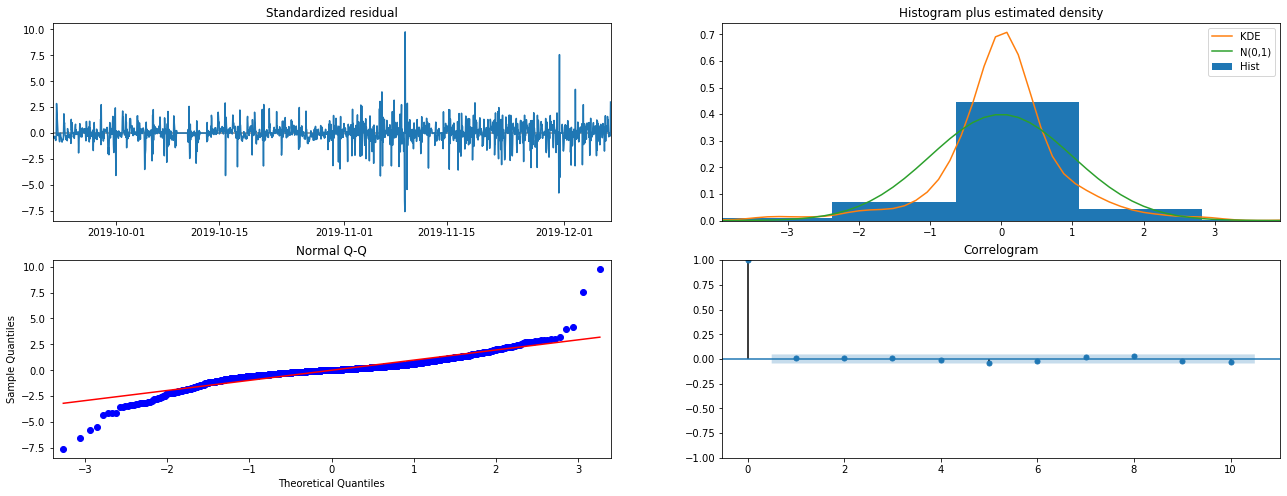

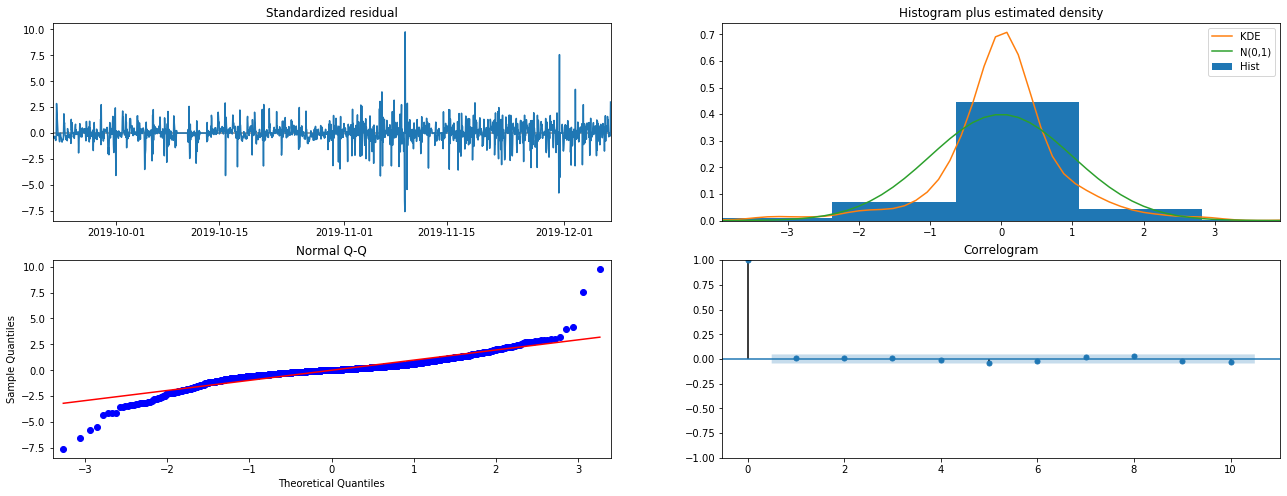

In [17]:
results.plot_diagnostics(figsize=(22,8))

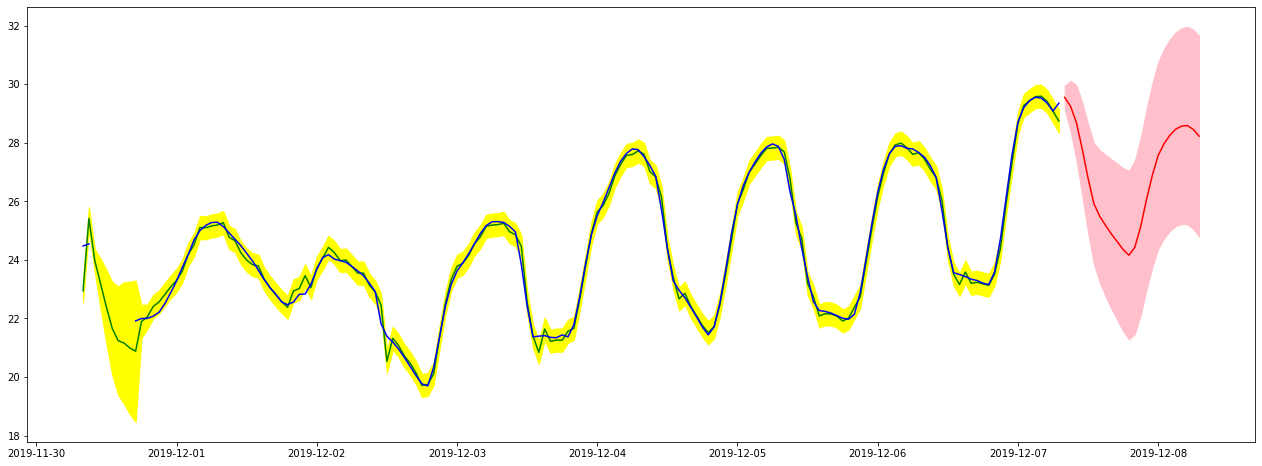

In [18]:
actual = df_temp[-168:]

prediction = results.get_prediction(start=-168, dynamic=False)
prediction_mean = prediction.predicted_mean
prediction_ci = prediction.conf_int()

forecast = results.get_forecast(steps=24, dynamic=True)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(22,8))



plt.plot(
    prediction_mean.index, 
    prediction_mean.values, 
    color='green', 
    label='prediction'
)
plt.fill_between(
    prediction_ci.index, 
    prediction_ci['lower value'], 
    prediction_ci['upper value'], 
    color='yellow'
)

plt.plot(
    forecast_mean.index, 
    forecast_mean.values, 
    color='red', 
    label='forecast'
)
plt.fill_between(
    forecast_ci.index, 
    forecast_ci['lower value'], 
    forecast_ci['upper value'], 
    color='pink'
)

plt.plot(
    actual.index,
    actual['value'],
    color='blue', 
    label='actual'
)